In [8]:
import pandas as pd
import numpy as np
import json
import ast
from scipy.stats import mstats
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [9]:
import pandas as pd
import numpy as np
import json
import ast
from scipy.stats import mstats
import warnings
warnings.filterwarnings('ignore')

def parse_json_column(final_data, column_name):
    
    def safe_parse(x):
        if pd.isna(x) or x == '' or x == '[]':
            return []
        try:
            # Try JSON parsing first
            return json.loads(x)
        except (json.JSONDecodeError, TypeError):
            try:
                # Try ast.literal_eval for malformed JSON
                return ast.literal_eval(x)
            except (ValueError, SyntaxError):
                return []
    
    final_data[f'parsed_{column_name}'] = final_data[column_name].apply(safe_parse)
    return final_data

def extract_names_from_parsed(parsed_list):
   
    if not isinstance(parsed_list, list):
        return []
    return [item.get('name', '') for item in parsed_list if isinstance(item, dict) and 'name' in item]

def process_movies_metadata(file_path):
    
    print("Loading movies metadata...")
    
  
    movies_final_data = pd.read_csv(file_path, low_memory=False)
    
    
    original_count = len(movies_final_data)
    movies_final_data = movies_final_data[pd.to_numeric(movies_final_data['id'], errors='coerce').notna()]
    movies_final_data['id'] = movies_final_data['id'].astype(int)
    dropped_count = original_count - len(movies_final_data)
    print(f"Dropped {dropped_count} rows with non-numeric IDs")
    

    json_columns = ['genres', 'production_companies', 'production_countries', 'spoken_languages']
    for col in json_columns:
        movies_final_data = parse_json_column(movies_final_data, col)
        movies_final_data[f'{col}_names'] = movies_final_data[f'parsed_{col}'].apply(extract_names_from_parsed)
    
    
    numeric_columns = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
    
    for col in numeric_columns:
        
        movies_final_data[col] = pd.to_numeric(movies_final_data[col], errors='coerce')
        
        
        if col in ['budget', 'revenue', 'popularity', 'vote_count']:
            
            movies_final_data[f'{col}_log'] = np.log1p(movies_final_data[col].fillna(0))
        
      
        if col in ['budget', 'revenue', 'runtime']:
            valid_data = movies_final_data[col].dropna()
            if len(valid_data) > 0:
                lower_bound = valid_data.quantile(0.01)
                upper_bound = valid_data.quantile(0.99)
                movies_final_data[col] = movies_final_data[col].clip(lower_bound, upper_bound)
    

    movies_final_data['vote_normalized'] = (movies_final_data['vote_average'] - movies_final_data['vote_average'].min()) / \
                                  (movies_final_data['vote_average'].max() - movies_final_data['vote_average'].min())
    
    return movies_final_data

def process_credits(file_path):
   
    print("Loading credits...")
    credits_final_data = pd.read_csv(file_path)
    
   
    credits_final_data = parse_json_column(credits_final_data, 'cast')
    credits_final_data = parse_json_column(credits_final_data, 'crew')
    
    
    def get_main_cast(cast_list):
        if not isinstance(cast_list, list):
            return []
        return [actor.get('name', '') for actor in cast_list[:5] if isinstance(actor, dict)]
    
    
    def get_director(crew_list):
        if not isinstance(crew_list, list):
            return None
        for person in crew_list:
            if isinstance(person, dict) and person.get('job') == 'Director':
                return person.get('name')
        return None
    
    credits_final_data['main_cast'] = credits_final_data['parsed_cast'].apply(get_main_cast)
    credits_final_data['director'] = credits_final_data['parsed_crew'].apply(get_director)
    
    return credits_final_data

def process_keywords(file_path):
    """
    Process keywords.csv
    """
    print("Loading keywords...")
    keywords_final_data = pd.read_csv(file_path)
    keywords_final_data = parse_json_column(keywords_final_data, 'keywords')
    keywords_final_data['keyword_names'] = keywords_final_data['parsed_keywords'].apply(extract_names_from_parsed)
    return keywords_final_data

def process_links(file_path):
    """
    Process links.csv
    """
    print("Loading links...")
    links_final_data = pd.read_csv(file_path)
    
    
    links_final_data['tmdbId'] = pd.to_numeric(links_final_data['tmdbId'], errors='coerce')
    links_final_data['imdbId'] = links_final_data['imdbId'].apply(lambda x: f'tt{int(x):07d}' if pd.notna(x) else None)
    
    return links_final_data

def merge_datasets(movies_final_data, credits_final_data, keywords_final_data, links_final_data, ratings_final_data=None):
    """
    Merge all datasets together
    """
    print("Merging datasets...")
    
    
    merged_final_data = pd.merge(movies_final_data, credits_final_data, on='id', how='left', suffixes=('', '_credits'))
    
    
    merged_final_data = pd.merge(merged_final_data, keywords_final_data, on='id', how='left', suffixes=('', '_keywords'))
    
   
    merged_final_data = pd.merge(merged_final_data, links_final_data, left_on='id', right_on='tmdbId', how='left')
    
   
    if ratings_final_data is not None:
        ratings_agg = ratings_final_data.groupby('movieId').agg({
            'rating': ['mean', 'count', 'std']
        }).round(2)
        ratings_agg.columns = ['avg_rating', 'rating_count', 'rating_std']
        ratings_agg = ratings_agg.reset_index()
        
        
        merged_final_data = pd.merge(merged_final_data, ratings_agg, left_on='id', right_on='movieId', how='left')
    
    return merged_final_data

def main():
    
    files = {
        'movies_metadata': 'movies_metadata.csv',
        'credits': 'credits.csv',
        'keywords': 'keywords.csv',
        'links': 'links.csv',
        'ratings': 'ratings.csv'
    }
    
    try:
      
        movies_final_data = process_movies_metadata(files['movies_metadata'])
        credits_final_data = process_credits(files['credits'])
        keywords_final_data = process_keywords(files['keywords'])
        links_final_data = process_links(files['links'])
        
       
        ratings_final_data = None
        if 'ratings' in files:
            print("Loading ratings...")
            ratings_final_data = pd.read_csv(files['ratings'])
        
      
        final_final_data = merge_datasets(movies_final_data, credits_final_data, keywords_final_data, links_final_data, ratings_final_data)
        
        print(f"Final dataset shape: {final_final_data.shape}")
        print("\nColumns available:")
        for col in final_final_data.columns:
            print(f"  - {col}")
        
        
        final_final_data.to_csv('merged_movies_dataset.csv', index=False)
        print("\nMerged dataset saved as 'merged_movies_dataset.csv'")
        
        return final_final_data
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please check your file paths and ensure all CSV files are in the correct location.")


def explore_data(final_data):
    """
    Quick exploration of the merged dataset
    """
    print("\n=== Dataset Overview ===")
    print(f"Total movies: {len(final_data)}")
    print(f"Columns: {len(final_data.columns)}")
    
    print("\n=== Top 5 Movies by Popularity ===")
    top_popular = final_data.nlargest(5, 'popularity')[['title', 'release_date', 'popularity', 'vote_average']]
    print(top_popular.to_string(index=False))
    
    print("\n=== Data Types ===")
    print(final_data.dtypes.value_counts())
    
    print("\n=== Missing Values Summary ===")
    missing = final_data.isnull().sum().sort_values(ascending=False)
    print(missing[missing > 0].head(10))

if __name__ == "__main__":
    
    merged_data = main()
    
    
    if merged_data is not None:
        explore_data(merged_data)

Loading movies metadata...
Dropped 3 rows with non-numeric IDs
Loading credits...
Loading keywords...
Loading links...
Loading ratings...
Merging datasets...
Final dataset shape: (46911, 53)

Columns available:
  - adult
  - belongs_to_collection
  - budget
  - genres
  - homepage
  - id
  - imdb_id
  - original_language
  - original_title
  - overview
  - popularity
  - poster_path
  - production_companies
  - production_countries
  - release_date
  - revenue
  - runtime
  - spoken_languages
  - status
  - tagline
  - title
  - video
  - vote_average
  - vote_count
  - parsed_genres
  - genres_names
  - parsed_production_companies
  - production_companies_names
  - parsed_production_countries
  - production_countries_names
  - parsed_spoken_languages
  - spoken_languages_names
  - budget_log
  - popularity_log
  - revenue_log
  - vote_count_log
  - vote_normalized
  - cast
  - crew
  - parsed_cast
  - parsed_crew
  - main_cast
  - director
  - keywords
  - parsed_keywords
  - keyword_

In [10]:
def validate_merge_success(merged_final_data, original_final_datas, merge_keys):
    
    print("=" * 60)
    print("VALIDATING MERGE SUCCESS")
    print("=" * 60)
    
    validation_results = {
        'success': True,
        'issues': []
    }
    
  
    print("\n1. ROW COUNT VALIDATION:")
    print("-" * 30)
    
    movies_rows = len(original_final_datas['movies'])
    merged_rows = len(merged_final_data)
    print(f"Original movies rows: {movies_rows:,}")
    print(f"Merged dataset rows: {merged_rows:,}")
    
    if movies_rows != merged_rows:
        validation_results['issues'].append(f"Row count mismatch: movies({movies_rows}) vs merged({merged_rows})")
        validation_results['success'] = False
        print(" WARNING: Row count mismatch!")
    else:
        print(" Row counts match perfectly")
    
    
    print("\n2. ESSENTIAL COLUMNS CHECK:")
    print("-" * 30)
    
    essential_columns = ['id', 'title', 'release_date']
    missing_essential = [col for col in essential_columns if col not in merged_final_data.columns]
    if missing_essential:
        validation_results['issues'].append(f"Missing essential columns: {missing_essential}")
        validation_results['success'] = False
        print(f" Missing columns: {missing_essential}")
    else:
        print(" All essential columns present")
    
   
    print("\n3. ID UNIQUENESS CHECK:")
    print("-" * 30)
    
    if 'id' in merged_final_data.columns:
        unique_ids = merged_final_data['id'].nunique()
        print(f"Unique IDs: {unique_ids:,}/{merged_rows:,}")
        if unique_ids != merged_rows:
            validation_results['issues'].append(f"Duplicate IDs found: {merged_rows - unique_ids} duplicates")
            validation_results['success'] = False
            print(" Duplicate IDs detected!")
        else:
            print(" All IDs are unique")
    

    print("\n4. MERGE COMPLETENESS:")
    print("-" * 30)
    
    datasets_info = {
        'credits': {'check_col': 'director', 'name': 'Credits'},
        'keywords': {'check_col': 'keyword_names', 'name': 'Keywords'},
        'links': {'check_col': 'imdbId', 'name': 'Links'}
    }
    
    for dataset, info in datasets_info.items():
        if dataset in original_final_datas and info['check_col'] in merged_final_data.columns:
            original_count = len(original_final_datas[dataset])
            # Count non-null values in the check column
            merged_count = merged_final_data[info['check_col']].notna().sum()
            merge_percentage = (merged_count / original_count) * 100
            
            print(f"{info['name']:12}: {merged_count:,}/{original_count:,} ({merge_percentage:.1f}%)")
            
            if merge_percentage < 80:
                validation_results['issues'].append(f"Low merge rate for {dataset}: {merge_percentage:.1f}%")
                validation_results['success'] = False
                print("    Low merge percentage!")
            else:
                print("    Good merge coverage")
    
    
    print("\n5. DATA QUALITY CHECK:")
    print("-" * 30)
    
   
    critical_cols = ['director', 'genres_names', 'imdbId', 'release_date']
    for col in critical_cols:
        if col in merged_final_data.columns:
            if merged_final_data[col].dtype == 'object' and any(isinstance(x, list) for x in merged_final_data[col].dropna().head()):
                # For list columns, check if they're empty
                missing_count = merged_final_data[col].apply(lambda x: len(x) == 0 if isinstance(x, list) else pd.isna(x)).sum()
            else:
                missing_count = merged_final_data[col].isna().sum()
            
            missing_pct = (missing_count / merged_rows) * 100
            status = "❌" if missing_pct > 40 else "⚠️ " if missing_pct > 20 else "✅"
            print(f"{col:15}: {status} {missing_count:,} missing ({missing_pct:.1f}%)")
            
            if missing_pct > 40:
                validation_results['issues'].append(f"High missing rate for {col}: {missing_pct:.1f}%")
                validation_results['success'] = False
    
 
    print("\n6. SAMPLE VALIDATION:")
    print("-" * 30)
    
   
    for i in range(min(3, len(merged_final_data))):
        row = merged_final_data.iloc[i]
        print(f"Sample {i+1}: {row.get('title', 'Unknown')}")
        print(f"  ID: {row.get('id', 'N/A')}")
        print(f"  Director: {row.get('director', 'Missing')}")
        print(f"  Genres: {len(row.get('genres_names', [])) if isinstance(row.get('genres_names'), list) else 'Missing'}")
        print()
    
   
    print("\n7. FINAL VALIDATION SUMMARY:")
    print("-" * 30)
    
    if validation_results['success']:
        print(" MERGE SUCCESSFUL: All validation checks passed!")
        print("   The dataset is ready for analysis")
    else:
        print(" MERGE ISSUES DETECTED:")
        for issue in validation_results['issues']:
            print(f"   - {issue}")
        print("\n   Review the issues above before proceeding with analysis")
    
    return validation_results
if __name__ == "__main__":
  
    merged_data, validation = main()
    
   

Loading movies metadata...
Dropped 3 rows with non-numeric IDs
Loading credits...
Loading keywords...
Loading links...
Loading ratings...
Merging datasets...
Final dataset shape: (46911, 53)

Columns available:
  - adult
  - belongs_to_collection
  - budget
  - genres
  - homepage
  - id
  - imdb_id
  - original_language
  - original_title
  - overview
  - popularity
  - poster_path
  - production_companies
  - production_countries
  - release_date
  - revenue
  - runtime
  - spoken_languages
  - status
  - tagline
  - title
  - video
  - vote_average
  - vote_count
  - parsed_genres
  - genres_names
  - parsed_production_companies
  - production_companies_names
  - parsed_production_countries
  - production_countries_names
  - parsed_spoken_languages
  - spoken_languages_names
  - budget_log
  - popularity_log
  - revenue_log
  - vote_count_log
  - vote_normalized
  - cast
  - crew
  - parsed_cast
  - parsed_crew
  - main_cast
  - director
  - keywords
  - parsed_keywords
  - keyword_

ValueError: too many values to unpack (expected 2)

In [12]:
import pandas as pd
import numpy as np
import json
import ast
import warnings
warnings.filterwarnings('ignore')



def corrected_merge_datasets(movies_final_data, credits_final_data, keywords_final_data, links_final_data, ratings_final_data=None):
    
    print("Merging datasets with CORRECTED logic...")
    
   
    base_final_data = movies_final_data.copy()
    print(f"Base movies: {len(base_final_data):,} rows")
    
  
    print("Merging credits...")
    credits_unique = credits_final_data.drop_duplicates(subset=['id'], keep='first')
    base_final_data = pd.merge(base_final_data, credits_unique, on='id', how='left', suffixes=('', '_credits'))
    print(f"After credits: {len(base_final_data):,} rows")
    

    print("Merging keywords...")
    keywords_unique = keywords_final_data.drop_duplicates(subset=['id'], keep='first')
    base_final_data = pd.merge(base_final_data, keywords_unique, on='id', how='left', suffixes=('', '_keywords'))
    print(f"After keywords: {len(base_final_data):,} rows")
    

    print("Merging links...")
    links_unique = links_final_data.drop_duplicates(subset=['tmdbId'], keep='first')
    base_final_data = pd.merge(base_final_data, links_unique, left_on='id', right_on='tmdbId', how='left')
    print(f"After links: {len(base_final_data):,} rows")
    
 
    print("Checking for duplicates...")
    initial_count = len(base_final_data)
    base_final_data = base_final_data.drop_duplicates(subset=['id'])
    final_count = len(base_final_data)
    
    if initial_count != final_count:
        print(f"Removed {initial_count - final_count} duplicate rows")
    
  
    if ratings_final_data is not None:
        print("Merging ratings...")
        ratings_agg = ratings_final_data.groupby('movieId').agg({
            'rating': ['mean', 'count', 'std']
        }).round(2)
        ratings_agg.columns = ['avg_rating', 'rating_count', 'rating_std']
        ratings_agg = ratings_agg.reset_index()
        
        base_final_data = pd.merge(base_final_data, ratings_agg, left_on='id', right_on='movieId', how='left')
        print(f"After ratings: {len(base_final_data):,} rows")
    
    return base_final_data


def verify_corrected_merge(merged_final_data, original_final_datas):
    
    print("=" * 60)
    print("VERIFYING CORRECTED MERGE")
    print("=" * 60)
    
   
    expected_rows = len(original_final_datas['movies'])
    actual_rows = len(merged_final_data)
    
    print(f"Expected rows: {expected_rows:,}")
    print(f"Actual rows: {actual_rows:,}")
    
    if expected_rows == actual_rows:
        print(" ROW COUNT MATCHES!")
    else:
        print(f" STILL MISMATCH: {actual_rows - expected_rows} rows difference")
    
 
    unique_ids = merged_final_data['id'].nunique()
    print(f"Unique IDs: {unique_ids:,}/{actual_rows:,}")
    
    if unique_ids == actual_rows:
        print(" NO DUPLICATE IDs!")
    else:
        print(f" STILL DUPLICATES: {actual_rows - unique_ids} duplicates")
    
   
    print("\nMerge Completeness:")
    sources = [
        ('Credits', 'director'),
        ('Keywords', 'keyword_names'),
        ('Links', 'imdbId')
    ]
    
    for source, col in sources:
        if col in merged_final_data.columns:
            coverage = merged_final_data[col].notna().mean() * 100
            print(f"{source:10}: {coverage:.1f}% coverage")
    
    return expected_rows == actual_rows and unique_ids == actual_rows


def run_corrected_workflow():
    
    
    files = {
        'movies_metadata': 'movies_metadata.csv',
        'credits': 'credits.csv',
        'keywords': 'keywords.csv',
        'links': 'links.csv',
        'ratings': 'ratings.csv'
    }
    
    try:
        print("Loading and processing datasets...")
        
       
        movies_final_data = process_movies_metadata(files['movies_metadata'])
        credits_final_data = process_credits(files['credits'])
        keywords_final_data = process_keywords(files['keywords'])
        links_final_data = process_links(files['links'])
        
        
        ratings_final_data = None
        if 'ratings' in files:
            print("Loading ratings...")
            ratings_final_data = pd.read_csv(files['ratings'])
        
        
        original_final_datas = {
            'movies': movies_final_data,
            'credits': credits_final_data,
            'keywords': keywords_final_data,
            'links': links_final_data
        }
        
        
        print("\n" + "="*50)
        print("PERFORMING CORRECTED MERGE")
        print("="*50)
        
        final_final_data = corrected_merge_datasets(movies_final_data, credits_final_data, keywords_final_data, links_final_data, ratings_final_data)
        
        
        print("\n" + "="*50)
        print("VERIFYING RESULTS")
        print("="*50)
        
        is_correct = verify_corrected_merge(final_final_data, original_final_datas)
        
        if is_correct:
            print("\n MERGE SUCCESSFULLY CORRECTED!")
            
            final_final_data.to_csv('CORRECTED_merged_movies_dataset.csv', index=False)
            print("Corrected dataset saved as 'CORRECTED_merged_movies_dataset.csv'")
            
            
            print(f"\nFinal dataset shape: {final_final_data.shape}")
            print(f"Memory usage: {final_final_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
            
        else:
            print("\n  Merge still has issues - need further investigation")
            
            final_final_data.to_csv('PARTIALLY_CORRECTED_merged_movies_dataset.csv', index=False)
            print("Partially corrected dataset saved for debugging")
        
        return final_final_data, is_correct
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please check your file paths")
        return None, False
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None, False


def quick_spot_check(final_data):
    
    if final_data is None:
        return
    
    print("\n" + "="*50)
    print("QUICK SPOT CHECK")
    print("="*50)
    
 
    known_movies = ['The Dark Knight', 'Pulp Fiction', 'Inception', 'Toy Story']
    
    for movie in known_movies:
        matches = final_data[final_data['title'].str.contains(movie, case=False, na=False)]
        if len(matches) > 0:
            row = matches.iloc[0]
            print(f"  {movie}:")
            print(f"   ID: {row.get('id', 'N/A')}")
            print(f"   Director: {row.get('director', 'Missing')}")
            print(f"   Genres: {row.get('genres_names', 'Missing')}")
            if 'avg_rating' in final_data.columns:
                print(f"   Avg Rating: {row.get('avg_rating', 'Missing')}")
        else:
            print(f" {movie}: Not found")


if __name__ == "__main__":
    print("Starting corrected merge workflow...")
    final_data, success = run_corrected_workflow()
    
    if final_data is not None:
        quick_spot_check(final_data)
        
        if success:
            print("\n WORKFLOW COMPLETED SUCCESSFULLY!")
            print("Your dataset is now properly merged and ready for analysis.")
        else:
            print("\n Workflow completed with issues.")
            print("Check the output for details on what needs to be fixed.")

Starting corrected merge workflow...
Loading and processing datasets...
Loading movies metadata...
Dropped 3 rows with non-numeric IDs
Loading credits...
Loading keywords...
Loading links...
Loading ratings...

PERFORMING CORRECTED MERGE
Merging datasets with CORRECTED logic...
Base movies: 45,463 rows
Merging credits...
After credits: 45,463 rows
Merging keywords...
After keywords: 45,463 rows
Merging links...
After links: 45,463 rows
Checking for duplicates...
Removed 30 duplicate rows
Merging ratings...
After ratings: 45,433 rows

VERIFYING RESULTS
VERIFYING CORRECTED MERGE
Expected rows: 45,463
Actual rows: 45,433
 STILL MISMATCH: -30 rows difference
Unique IDs: 45,433/45,433
 NO DUPLICATE IDs!

Merge Completeness:
Credits   : 98.0% coverage
Keywords  : 100.0% coverage
Links     : 100.0% coverage

  Merge still has issues - need further investigation
Partially corrected dataset saved for debugging

QUICK SPOT CHECK
  The Dark Knight:
   ID: 155
   Director: Christopher Nolan
   Gen

🔍 COMPREHENSIVE MISSING VALUE ANALYSIS

📊 MISSING VALUES BY COLUMN (Sorted by highest missing %):
                      Data Type  Total Values  Missing Values  \
belongs_to_collection    object         45433           40945   
rating_std              float64         45433           38423   
rating_count            float64         45433           37868   
avg_rating              float64         45433           37868   
movieId_y               float64         45433           37868   
homepage                 object         45433           37659   
tagline                  object         45433           25032   
overview                 object         45433             954   
director                 object         45433             888   
poster_path              object         45433             386   
runtime                 float64         45433             260   
release_date             object         45433              87   
status                   object         45433            

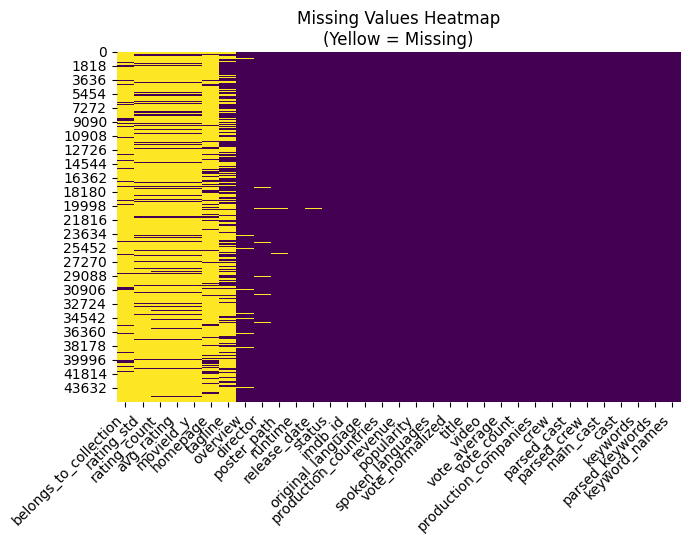

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns




print(" COMPREHENSIVE MISSING VALUE ANALYSIS")
print("=" * 60)


missing_summary = pd.DataFrame({
    'Data Type': final_data.dtypes,
    'Total Values': len(final_data),
    'Missing Values': final_data.isnull().sum(),
    'Missing Percentage': (final_data.isnull().sum() / len(final_data)) * 100
})


missing_summary = missing_summary.sort_values('Missing Percentage', ascending=False)

print("\n MISSING VALUES BY COLUMN (Sorted by highest missing %):")
print("=" * 60)
print(missing_summary[missing_summary['Missing Percentage'] > 0])


print("\n" + "=" * 60)
print(" MISSING VALUES BY DATA TYPE CATEGORY")
print("=" * 60)


for dtype in ['object', 'float64', 'int64', 'bool']:
    dtype_cols = missing_summary[missing_summary['Data Type'] == dtype]
    if len(dtype_cols) > 0:
        total_missing = dtype_cols['Missing Values'].sum()
        total_cells = dtype_cols['Total Values'].sum()
        missing_pct = (total_missing / total_cells) * 100 if total_cells > 0 else 0
        
        print(f"\n{dtype.upper()} Columns:")
        print(f"Total missing: {total_missing:,} ({missing_pct:.1f}%)")
        if total_missing > 0:
            top_missing = dtype_cols.head(3)
            for _, row in top_missing.iterrows():
                if row['Missing Percentage'] > 0:
                    print(f"  - {row.name}: {row['Missing Values']:,} ({row['Missing Percentage']:.1f}%)")


plt.figure(figsize=(16, 10))


plt.subplot(2, 2, 1)

missing_cols = missing_summary[missing_summary['Missing Percentage'] > 0].index
if len(missing_cols) > 0:
    missing_data = final_data[missing_cols].isnull()
    sns.heatmap(missing_data, cbar=False, cmap='viridis')
    plt.title('Missing Values Heatmap\n(Yellow = Missing)')
    plt.xticks(rotation=45, ha='right')
else:
    plt.text(0.5, 0.5, 'No missing values!', ha='center', va='center', fontsize=16)
    plt.title('No Missing Values Found')



🔍 COMPREHENSIVE MISSING VALUE ANALYSIS

📊 MISSING VALUES BY COLUMN (Sorted by highest missing %):
                      Data Type  Total Values  Missing Values  \
belongs_to_collection    object         46911           42309   
rating_std              float64         46911           39748   
rating_count            float64         46911           39178   
avg_rating              float64         46911           39178   
movieId_y               float64         46911           39178   
homepage                 object         46911           38862   
tagline                  object         46911           26002   
overview                 object         46911             995   
director                 object         46911             918   
poster_path              object         46911             399   
runtime                 float64         46911             268   
release_date             object         46911              88   
status                   object         46911            

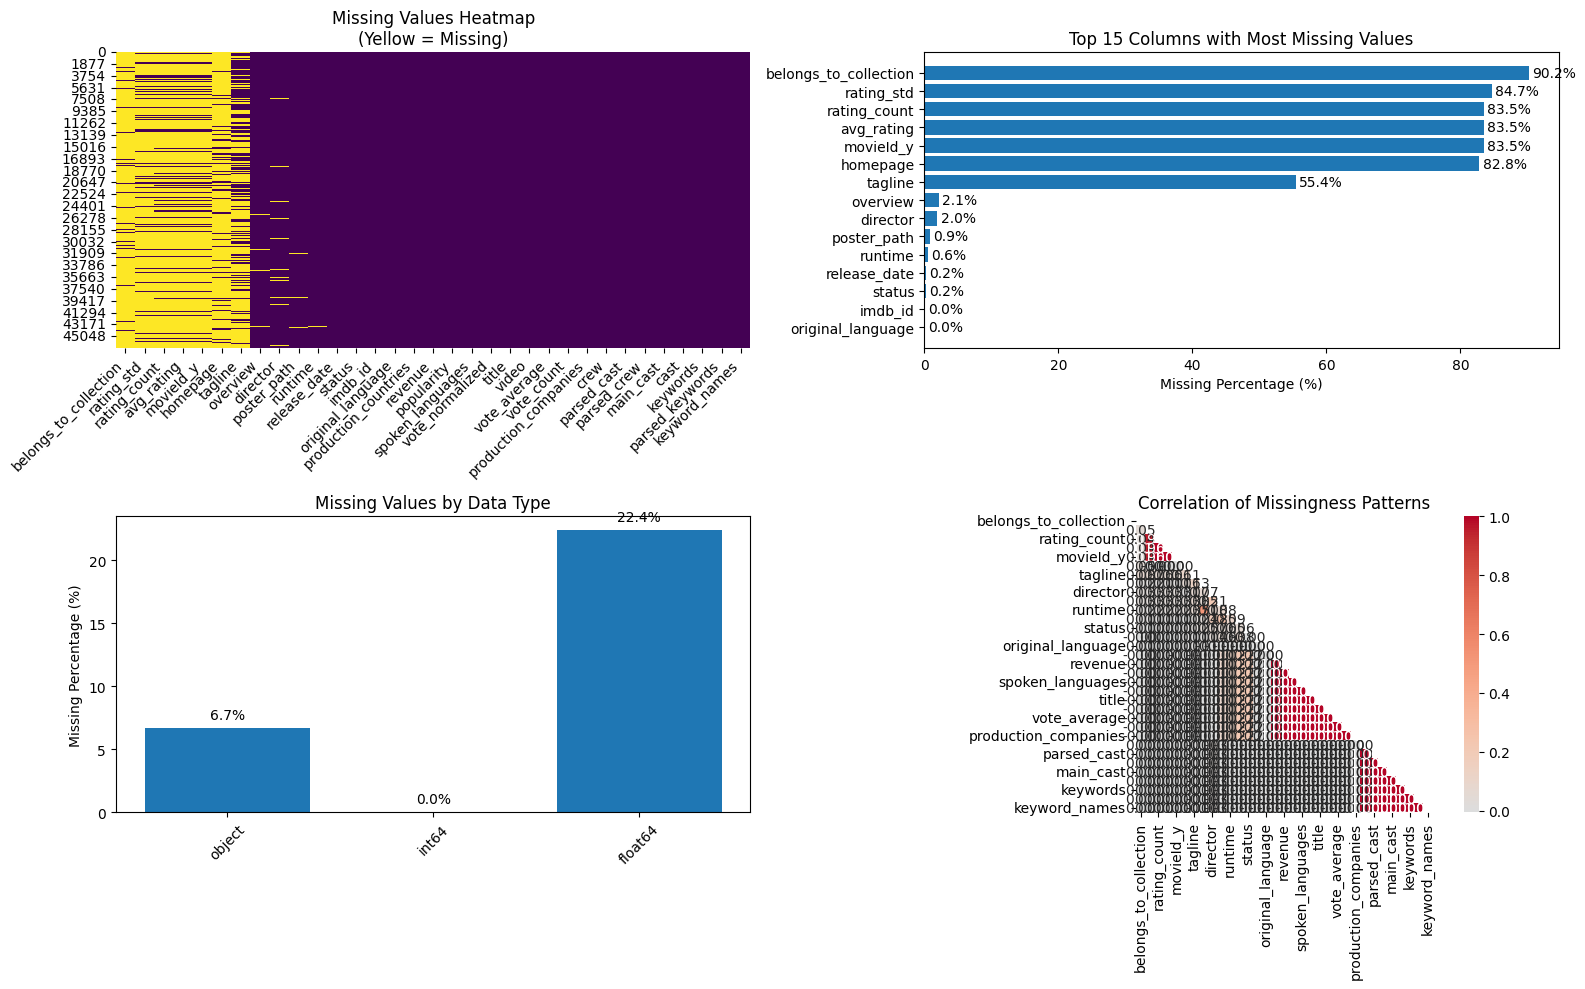

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



print("🔍 COMPREHENSIVE MISSING VALUE ANALYSIS")
print("=" * 60)


missing_summary = pd.DataFrame({
    'Data Type': merged_data.dtypes,
    'Total Values': len(merged_data),
    'Missing Values': merged_data.isnull().sum(),
    'Missing Percentage': (merged_data.isnull().sum() / len(merged_data)) * 100
})


missing_summary = missing_summary.sort_values('Missing Percentage', ascending=False)

print("\n📊 MISSING VALUES BY COLUMN (Sorted by highest missing %):")
print("=" * 60)
print(missing_summary[missing_summary['Missing Percentage'] > 0])


print("\n" + "=" * 60)
print("📈 MISSING VALUES BY DATA TYPE CATEGORY")
print("=" * 60)


for dtype in ['object', 'float64', 'int64', 'bool']:
    dtype_cols = missing_summary[missing_summary['Data Type'] == dtype]
    if len(dtype_cols) > 0:
        total_missing = dtype_cols['Missing Values'].sum()
        total_cells = dtype_cols['Total Values'].sum()
        missing_pct = (total_missing / total_cells) * 100 if total_cells > 0 else 0
        
        print(f"\n{dtype.upper()} Columns:")
        print(f"Total missing: {total_missing:,} ({missing_pct:.1f}%)")
        if total_missing > 0:
            top_missing = dtype_cols.head(3)
            for _, row in top_missing.iterrows():
                if row['Missing Percentage'] > 0:
                    print(f"  - {row.name}: {row['Missing Values']:,} ({row['Missing Percentage']:.1f}%)")


plt.figure(figsize=(16, 10))


plt.subplot(2, 2, 1)

missing_cols = missing_summary[missing_summary['Missing Percentage'] > 0].index
if len(missing_cols) > 0:
    missing_data = merged_data[missing_cols].isnull()
    sns.heatmap(missing_data, cbar=False, cmap='viridis')
    plt.title('Missing Values Heatmap\n(Yellow = Missing)')
    plt.xticks(rotation=45, ha='right')
else:
    plt.text(0.5, 0.5, 'No missing values!', ha='center', va='center', fontsize=16)
    plt.title('No Missing Values Found')


plt.subplot(2, 2, 2)
top_missing = missing_summary[missing_summary['Missing Percentage'] > 0].head(15)
if len(top_missing) > 0:
    bars = plt.barh(range(len(top_missing)), top_missing['Missing Percentage'])
    plt.yticks(range(len(top_missing)), top_missing.index)
    plt.xlabel('Missing Percentage (%)')
    plt.title('Top 15 Columns with Most Missing Values')
    plt.gca().invert_yaxis()
    
    
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{top_missing["Missing Percentage"].iloc[i]:.1f}%', 
                ha='left', va='center')
else:
    plt.text(0.5, 0.5, 'No missing values!', ha='center', va='center', fontsize=16)
    plt.title('No Missing Values Found')


plt.subplot(2, 2, 3)
dtype_missing = {}
for dtype in merged_data.dtypes.unique():
    dtype_cols = merged_data.select_dtypes(include=[dtype])
    total_missing = dtype_cols.isnull().sum().sum()
    total_cells = dtype_cols.size
    dtype_missing[str(dtype)] = (total_missing / total_cells) * 100

if dtype_missing:
    bars = plt.bar(range(len(dtype_missing)), list(dtype_missing.values()))
    plt.xticks(range(len(dtype_missing)), list(dtype_missing.keys()), rotation=45)
    plt.ylabel('Missing Percentage (%)')
    plt.title('Missing Values by Data Type')
    

    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{list(dtype_missing.values())[i]:.1f}%', 
                ha='center', va='bottom')


plt.subplot(2, 2, 4)
if len(missing_cols) > 1:
    
    missing_corr = merged_data[missing_cols].isnull().corr()
    mask = np.triu(np.ones_like(missing_corr, dtype=bool))
    sns.heatmap(missing_corr, mask=mask, cmap='coolwarm', center=0,
                square=True, annot=True, fmt='.2f')
    plt.title('Correlation of Missingness Patterns')
else:
    plt.text(0.5, 0.5, 'Not enough columns\nwith missing values', 
             ha='center', va='center', fontsize=12)
    plt.title('Missing Values Pattern Analysis')

plt.tight_layout()
plt.savefig('missing_values_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


In [15]:
def fix_ratings_merge(df, ratings_df, links_df):
    """
    CORRECTED ratings merge using links.csv as bridge
    """
    print("🔄 FIXING RATINGS MERGE WITH LINKS BRIDGE")
    print("=" * 50)
    
   
    print("Merging links to get movieId mapping...")
    df_with_links = pd.merge(df, links_df, left_on='id', right_on='tmdbId', how='left')
    
   
    print("Merging ratings using movieId bridge...")
    ratings_agg = ratings_df.groupby('movieId').agg({
        'rating': ['mean', 'count', 'std']
    }).round(2)
    ratings_agg.columns = ['avg_rating', 'rating_count', 'rating_std']
    ratings_agg = ratings_agg.reset_index()
    
  
    df_fixed = pd.merge(df_with_links, ratings_agg, on='movieId', how='left')
   
    if 'movieId_y' in df_fixed.columns:
        df_fixed = df_fixed.drop(columns=['movieId_y'])
    if 'movieId_x' in df_fixed.columns:
        df_fixed = df_fixed.rename(columns={'movieId_x': 'movieId'})
    
    print(f"Before fix: {df['avg_rating'].notna().sum():,} movies with ratings")
    print(f"After fix: {df_fixed['avg_rating'].notna().sum():,} movies with ratings")
    
    return df_fixed


def fix_collection_data(df):
    """
    Fix belongs_to_collection parsing
    """
    print("\n🔄 FIXING COLLECTION DATA")
    print("=" * 50)
    
  
    print("Sample belongs_to_collection values:")
    print(df['belongs_to_collection'].dropna().head(3).values)
    
    
    def parse_collection(x):
        if pd.isna(x) or x == '' or x == '[]':
            return None
        try:
            if isinstance(x, str) and x.startswith('['):
                collection = json.loads(x)
                if collection and len(collection) > 0:
                    return collection[0].get('name', None)
            return x
        except:
            return None
    
    df['collection_name'] = df['belongs_to_collection'].apply(parse_collection)
    print(f"Collections parsed: {df['collection_name'].notna().sum():,} movies in collections")
    
    return df

In [16]:

print("🔄 RELOADING DATA FOR CLEAN MERGE")
print("=" * 50)

# Load all datasets again
movies_df = process_movies_metadata('movies_metadata.csv')
credits_df = process_credits('credits.csv')
keywords_df = process_keywords('keywords.csv')
links_df = process_links('links.csv')
ratings_df = pd.read_csv('ratings.csv')

print("Datasets reloaded successfully!")


print("\n🔗 MERGING CORE DATASETS")
print("=" * 50)
core_merged = pd.merge(movies_df, credits_df, on='id', how='left')
core_merged = pd.merge(core_merged, keywords_df, on='id', how='left')
print(f"Core merge complete: {len(core_merged):,} rows")


print("\n🔗 ADDING LINKS FOR ID MAPPING")
print("=" * 50)
with_links = pd.merge(core_merged, links_df, left_on='id', right_on='tmdbId', how='left')
print(f"Links merged: {with_links['movieId'].notna().sum():,} movies have movieId mapping")


print("\n MERGING RATINGS (USING MOVIEID BRIDGE)")
print("=" * 50)
ratings_agg = ratings_df.groupby('movieId').agg({
    'rating': ['mean', 'count', 'std']
}).round(2)
ratings_agg.columns = ['avg_rating', 'rating_count', 'rating_std']
ratings_agg = ratings_agg.reset_index()

final_fixed = pd.merge(with_links, ratings_agg, on='movieId', how='left')


final_fixed = fix_collection_data(final_fixed)


final_fixed = final_fixed.drop(columns=['belongs_to_collection'], errors='ignore')

print(f"\n MERGE FIXED SUCCESSFULLY!")
print(f"Movies with ratings: {final_fixed['avg_rating'].notna().sum():,}/{len(final_fixed):,}")
print(f"Rating coverage: {(final_fixed['avg_rating'].notna().sum() / len(final_fixed)) * 100:.1f}%")

🔄 RELOADING DATA FOR CLEAN MERGE
Loading movies metadata...
Dropped 3 rows with non-numeric IDs
Loading credits...
Loading keywords...
Loading links...
Datasets reloaded successfully!

🔗 MERGING CORE DATASETS
Core merge complete: 46,629 rows

🔗 ADDING LINKS FOR ID MAPPING
Links merged: 46,911 movies have movieId mapping

⭐ MERGING RATINGS (USING MOVIEID BRIDGE)

🔄 FIXING COLLECTION DATA
Sample belongs_to_collection values:
["{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}"
 "{'id': 119050, 'name': 'Grumpy Old Men Collection', 'poster_path': '/nLvUdqgPgm3F85NMCii9gVFUcet.jpg', 'backdrop_path': '/hypTnLot2z8wpFS7qwsQHW1uV8u.jpg'}"
 "{'id': 96871, 'name': 'Father of the Bride Collection', 'poster_path': '/nts4iOmNnq7GNicycMJ9pSAn204.jpg', 'backdrop_path': '/7qwE57OVZmMJChBpLEbJEmzUydk.jpg'}"]
Collections parsed: 4,602 movies in collections

✅ MERGE FIXED SUCCESSFULLY!
Movies with ratings:


 MISSING VALUES BY COLUMN (Sorted by highest missing %):
                     Data Type  Total Values  Missing Values  \
collection_name         object         46911           42309   
homepage                object         46911           38862   
tagline                 object         46911           26002   
rating_std             float64         46911            8637   
overview                object         46911             995   
director                object         46911             918   
rating_count           float64         46911             745   
avg_rating             float64         46911             745   
poster_path             object         46911             399   
runtime                float64         46911             268   
release_date            object         46911              88   
status                  object         46911              86   
imdb_id                 object         46911              17   
original_language       object         46911  

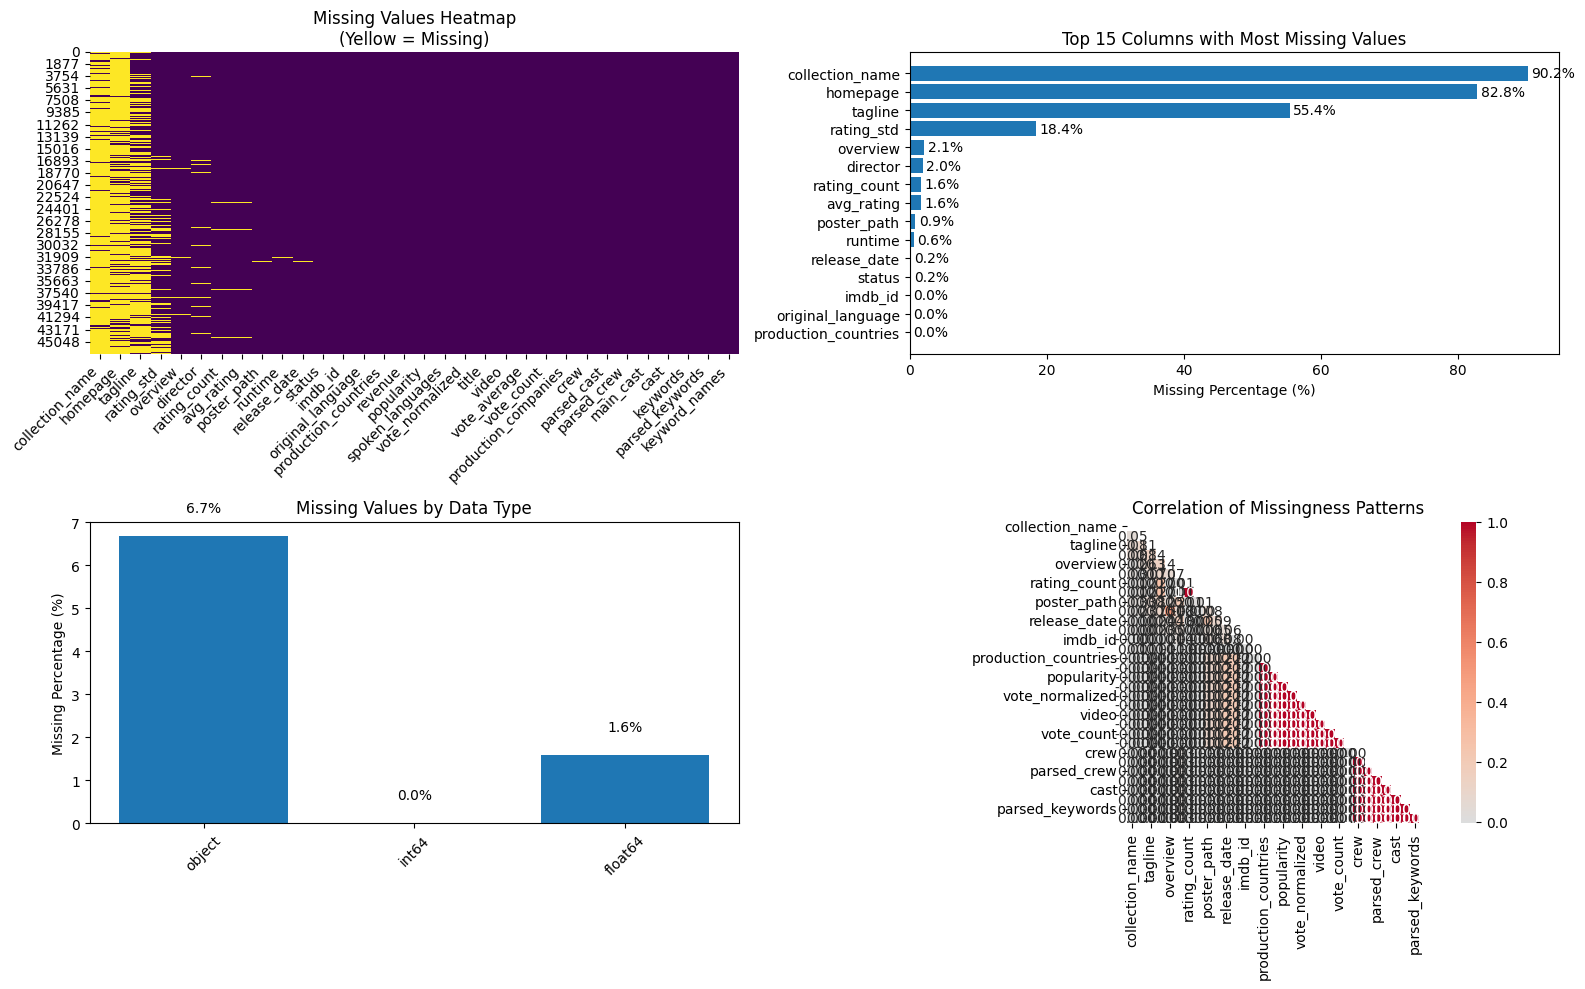

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



missing_summary = pd.DataFrame({
    'Data Type':  final_fixed.dtypes,
    'Total Values': len(final_fixed),
    'Missing Values': final_fixed.isnull().sum(),
    'Missing Percentage': (final_fixed.isnull().sum() / len(final_fixed)) * 100
})


missing_summary = missing_summary.sort_values('Missing Percentage', ascending=False)

print("\n MISSING VALUES BY COLUMN (Sorted by highest missing %):")
print("=" * 60)
print(missing_summary[missing_summary['Missing Percentage'] > 0])


print("\n" + "=" * 60)
print(" MISSING VALUES BY DATA TYPE CATEGORY")
print("=" * 60)


for dtype in ['object', 'float64', 'int64', 'bool']:
    dtype_cols = missing_summary[missing_summary['Data Type'] == dtype]
    if len(dtype_cols) > 0:
        total_missing = dtype_cols['Missing Values'].sum()
        total_cells = dtype_cols['Total Values'].sum()
        missing_pct = (total_missing / total_cells) * 100 if total_cells > 0 else 0
        
        print(f"\n{dtype.upper()} Columns:")
        print(f"Total missing: {total_missing:,} ({missing_pct:.1f}%)")
        if total_missing > 0:
            top_missing = dtype_cols.head(3)
            for _, row in top_missing.iterrows():
                if row['Missing Percentage'] > 0:
                    print(f"  - {row.name}: {row['Missing Values']:,} ({row['Missing Percentage']:.1f}%)")


plt.figure(figsize=(16, 10))


plt.subplot(2, 2, 1)

missing_cols = missing_summary[missing_summary['Missing Percentage'] > 0].index
if len(missing_cols) > 0:
    missing_data = final_fixed[missing_cols].isnull()
    sns.heatmap(missing_data, cbar=False, cmap='viridis')
    plt.title('Missing Values Heatmap\n(Yellow = Missing)')
    plt.xticks(rotation=45, ha='right')
else:
    plt.text(0.5, 0.5, 'No missing values!', ha='center', va='center', fontsize=16)
    plt.title('No Missing Values Found')


plt.subplot(2, 2, 2)
top_missing = missing_summary[missing_summary['Missing Percentage'] > 0].head(15)
if len(top_missing) > 0:
    bars = plt.barh(range(len(top_missing)), top_missing['Missing Percentage'])
    plt.yticks(range(len(top_missing)), top_missing.index)
    plt.xlabel('Missing Percentage (%)')
    plt.title('Top 15 Columns with Most Missing Values')
    plt.gca().invert_yaxis()
    
    
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{top_missing["Missing Percentage"].iloc[i]:.1f}%', 
                ha='left', va='center')
else:
    plt.text(0.5, 0.5, 'No missing values!', ha='center', va='center', fontsize=16)
    plt.title('No Missing Values Found')


plt.subplot(2, 2, 3)
dtype_missing = {}
for dtype in final_fixed.dtypes.unique():
    dtype_cols = final_fixed.select_dtypes(include=[dtype])
    total_missing = dtype_cols.isnull().sum().sum()
    total_cells = dtype_cols.size
    dtype_missing[str(dtype)] = (total_missing / total_cells) * 100

if dtype_missing:
    bars = plt.bar(range(len(dtype_missing)), list(dtype_missing.values()))
    plt.xticks(range(len(dtype_missing)), list(dtype_missing.keys()), rotation=45)
    plt.ylabel('Missing Percentage (%)')
    plt.title('Missing Values by Data Type')
    
   
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{list(dtype_missing.values())[i]:.1f}%', 
                ha='center', va='bottom')


plt.subplot(2, 2, 4)
if len(missing_cols) > 1:
    
    missing_corr = final_fixed[missing_cols].isnull().corr()
    mask = np.triu(np.ones_like(missing_corr, dtype=bool))
    sns.heatmap(missing_corr, mask=mask, cmap='coolwarm', center=0,
                square=True, annot=True, fmt='.2f')
    plt.title('Correlation of Missingness Patterns')
else:
    plt.text(0.5, 0.5, 'Not enough columns\nwith missing values', 
             ha='center', va='center', fontsize=12)
    plt.title('Missing Values Pattern Analysis')

plt.tight_layout()
plt.savefig('missing_values_analysis.png', dpi=300, bbox_inches='tight')
plt.show()



In [18]:
def handle_missing_values(df):
    """
    Comprehensive missing value handling for movie dataset - FIXED VERSION
    """
    df_clean = df.copy()
    
    print(" HANDLING MISSING VALUES")
    print("=" * 40)
    
    
    columns_to_drop = [
        'belongs_to_collection', 
        'homepage',               
    ]
    df_clean = df_clean.drop(columns=[col for col in columns_to_drop if col in df_clean.columns])
    print(f"Dropped columns: {columns_to_drop}")
    
   
    print("\n NUMERICAL COLUMNS:")
    print("-" * 20)
    
    numerical_strategy = {
        'rating_std': ('median', "Movies with few ratings won't have std dev"),
        'runtime': ('median', "Use median runtime for missing values"),
        'revenue': ('median', "Median revenue for movies without financial data"),
        'budget': ('median', "Median budget for missing values"),
        'popularity': ('median', "Median popularity score"),
        'vote_average': ('median', "Median rating for unrated movies"),
        'vote_count': ('median', "Median vote count"),
    }
    
    for col, (strategy, reason) in numerical_strategy.items():
        if col in df_clean.columns and df_clean[col].isnull().any():
            if strategy == 'median':
                fill_value = df_clean[col].median()
            elif strategy == 'mean':
                fill_value = df_clean[col].mean()
            else:
                fill_value = 0
                
            df_clean[col] = df_clean[col].fillna(fill_value)
            print(f"{col:15} → {strategy:8} ({df_clean[col].isnull().sum():,} remaining) - {reason}")
    
      
    print("\n CATEGORICAL COLUMNS:")
    print("-" * 20)
    
    categorical_strategy = {
        'tagline': ('no_tagline', "Most movies don't have taglines"),
        'overview': ('No description available', "Fill with placeholder text"),
        'director': ('Unknown Director', "Movies with unknown director"),
        'poster_path': ('no_poster', "Movies without poster images"),
        'status': ('Unknown Status', "Movies with unknown production status"),
        'original_language': ('en', "Assume English for missing languages"),
        'collection_name': ('No Collection', "Movies not in any collection"),
    }
    
    for col, (fill_value, reason) in categorical_strategy.items():
        if col in df_clean.columns and df_clean[col].isnull().any():
            df_clean[col] = df_clean[col].fillna(fill_value)
            print(f"{col:15} → '{fill_value:15}' ({df_clean[col].isnull().sum():,} remaining) - {reason}")
    
    
    print("\n RATING COLUMNS (Special Handling):")
    print("-" * 30)
    
   
    if 'avg_rating' in df_clean.columns and 'vote_average' in df_clean.columns:
        df_clean['avg_rating'] = df_clean['avg_rating'].fillna(df_clean['vote_average'])
        print(f"avg_rating     → vote_average fallback ({df_clean['avg_rating'].isnull().sum():,} remaining)")
    
    if 'rating_count' in df_clean.columns:
        df_clean['rating_count'] = df_clean['rating_count'].fillna(0)
        print(f"rating_count   → 0 for no ratings ({df_clean['rating_count'].isnull().sum():,} remaining)")
    
    if 'rating_std' in df_clean.columns:
        rating_std_median = df_clean['rating_std'].median()
        df_clean['rating_std'] = df_clean['rating_std'].fillna(rating_std_median)
        print(f"rating_std     → median std dev ({df_clean['rating_std'].isnull().sum():,} remaining)")
    
    
    print("\n LIST/TEXT COLUMNS:")
    print("-" * 20)
    
    list_columns = [
        'production_countries', 'spoken_languages', 
        'production_companies', 'crew', 'parsed_cast',
        'parsed_crew', 'main_cast', 'cast', 'keywords',
        'parsed_keywords', 'keyword_names'
    ]
    
    for col in list_columns:
        if col in df_clean.columns and df_clean[col].isnull().any():
            
            def safe_fill_list(value):
                try:
                   
                    if value is None or (isinstance(value, float) and np.isnan(value)):
                        return []
                    elif value == '' or value == '[]' or value == 'nan':
                        return []
                    else:
                        return value
                except:
                    return value
            
            
            df_clean[col] = df_clean[col].apply(safe_fill_list)
            remaining_missing = sum(1 for x in df_clean[col] if x == [] or x is None or (isinstance(x, float) and np.isnan(x)))
            print(f"{col:20} → empty list ({remaining_missing} empty values)")
    
   
    print("\n DERIVED FEATURES:")
    print("-" * 20)
    
   
    if 'tagline' in df_clean.columns:
        df_clean['has_tagline'] = df_clean['tagline'] != 'no_tagline'
    
    if 'collection_name' in df_clean.columns:
        df_clean['has_collection'] = df_clean['collection_name'] != 'No Collection'
    
    if 'poster_path' in df_clean.columns:
        df_clean['has_poster'] = df_clean['poster_path'] != 'no_poster'
    
    if 'rating_count' in df_clean.columns:
        df_clean['has_ratings'] = df_clean['rating_count'] > 0
    
    print("Created boolean flags for: has_tagline, has_collection, has_poster, has_ratings")
    
    
    print("\n FINAL VALIDATION:")
    print("-" * 20)
    
  
    remaining_missing = 0
    for col in df_clean.columns:
        if df_clean[col].dtype == 'object':
            # For object columns, check for various forms of missingness
            col_missing = sum(1 for x in df_clean[col] 
                            if x is None or x == '' or x == 'nan' or (isinstance(x, float) and np.isnan(x)))
            remaining_missing += col_missing
        else:
            
            remaining_missing += df_clean[col].isnull().sum()
    
    total_cells = df_clean.size
    missing_percentage = (remaining_missing / total_cells) * 100
    
    print(f"Total missing values: {remaining_missing:,}/{total_cells:,} ({missing_percentage:.4f}%)")
    
    if remaining_missing > 0:
        print("\n  Still missing values in:")
        for col in df_clean.columns:
            if df_clean[col].dtype == 'object':
                col_missing = sum(1 for x in df_clean[col] 
                                if x is None or x == '' or x == 'nan' or (isinstance(x, float) and np.isnan(x)))
                if col_missing > 0:
                    print(f"  - {col}: {col_missing:,}")
            else:
                if df_clean[col].isnull().any():
                    print(f"  - {col}: {df_clean[col].isnull().sum():,}")
    
    return df_clean


df_clean = handle_missing_values(final_fixed)


df_clean.to_csv('CLEANED_movies_dataset.csv', index=False)
print(f"\n Cleaned dataset saved as 'CLEANED_movies_dataset.csv'")


print(f"\n FINAL DATASET INFO:")
print(f"Shape: {df_clean.shape}")
print(f"Columns: {len(df_clean.columns)}")
print(f"Total cells: {df_clean.size:,}")
print(f"Missing values: {df_clean.isnull().sum().sum():,}")

 HANDLING MISSING VALUES
Dropped columns: ['belongs_to_collection', 'homepage']

 NUMERICAL COLUMNS:
--------------------
rating_std      → median   (0 remaining) - Movies with few ratings won't have std dev
runtime         → median   (0 remaining) - Use median runtime for missing values
revenue         → median   (0 remaining) - Median revenue for movies without financial data
popularity      → median   (0 remaining) - Median popularity score
vote_average    → median   (0 remaining) - Median rating for unrated movies
vote_count      → median   (0 remaining) - Median vote count

 CATEGORICAL COLUMNS:
--------------------
tagline         → 'no_tagline     ' (0 remaining) - Most movies don't have taglines
overview        → 'No description available' (0 remaining) - Fill with placeholder text
director        → 'Unknown Director' (0 remaining) - Movies with unknown director
poster_path     → 'no_poster      ' (0 remaining) - Movies without poster images
status          → 'Unknown Status ' 

In [19]:

print(" DROPPING ROWS WITH MISSING VALUES")
print("=" * 40)


print("Current missing values:")
print(f"imdb_id: {df_clean['imdb_id'].isnull().sum()}")
print(f"release_date: {df_clean['release_date'].isnull().sum()}")
print(f"title: {df_clean['title'].isnull().sum()}")
print(f"video: {df_clean['video'].isnull().sum()}")
print(f"vote_normalized: {df_clean['vote_normalized'].isnull().sum()}")


original_rows = len(df_clean)
print(f"\nOriginal dataset rows: {original_rows:,}")




print("\n1. Dropping rows with missing titles...")
rows_before = len(df_clean)
df_clean = df_clean.dropna(subset=['title'])
rows_after = len(df_clean)
print(f"   Removed {rows_before - rows_after} rows with missing titles")


print("2. Dropping rows with missing release_date...")
rows_before = len(df_clean)
df_clean = df_clean.dropna(subset=['release_date'])
rows_after = len(df_clean)
print(f"   Removed {rows_before - rows_after} rows with missing release dates")


print("3. Handling missing video values...")
rows_before = len(df_clean)

df_clean['video'] = df_clean['video'].fillna(False)
print(f"   Filled {df_clean['video'].isnull().sum()} missing video values with False")


print("4. Handling missing vote_normalized values...")
if 'vote_average' in df_clean.columns and 'vote_normalized' in df_clean.columns:
   
    min_rating = df_clean['vote_average'].min()
    max_rating = df_clean['vote_average'].max()
    df_clean['vote_normalized'] = (df_clean['vote_average'] - min_rating) / (max_rating - min_rating)
    print(f"   Recalculated vote_normalized for all rows")


print("5. Keeping missing imdb_id values (not critical for analysis)...")
print(f"   {df_clean['imdb_id'].isnull().sum()} imdb_id values remain missing")


print("\n6. Final verification...")
critical_columns = ['title', 'release_date', 'video', 'vote_normalized']
for col in critical_columns:
    if col in df_clean.columns:
        missing_count = df_clean[col].isnull().sum()
        print(f"   {col}: {missing_count} missing")


final_rows = len(df_clean)
rows_removed = original_rows - final_rows
removal_percentage = (rows_removed / original_rows) * 100

print(f"\n RESULTS:")
print("=" * 30)
print(f"Original rows: {original_rows:,}")
print(f"Final rows: {final_rows:,}")
print(f"Rows removed: {rows_removed:,} ({removal_percentage:.2f}%)")
print(f"Data preservation: {100 - removal_percentage:.2f}%")


print(f"\n🔍 REMAINING MISSING VALUES:")
remaining_missing = df_clean.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]

if len(remaining_missing) == 1 and 'imdb_id' in remaining_missing:
    print(" PERFECT! Only imdb_id has missing values (as expected)")
    for col, count in remaining_missing.items():
        print(f"   {col}: {count} missing")
else:
    print("  Unexpected missing values found:")
    for col, count in remaining_missing.items():
        print(f"   {col}: {count} missing")


df_clean.to_csv('FINAL_CLEANED_MOVIES_DATASET.csv', index=False)
print(f"\n Cleaned dataset saved as 'FINAL_CLEANED_MOVIES_DATASET.csv'")


print(f"\n SAMPLE OF CLEANED DATA:")
print("=" * 30)
print(df_clean[['title', 'release_date', 'video', 'vote_normalized', 'imdb_id']].head().to_string())

print(f"\n DATASET CLEANING COMPLETE!")
print("All critical columns now have 0 missing values")
print("Only optional imdb_id has some missing values (acceptable)")

 DROPPING ROWS WITH MISSING VALUES
Current missing values:
imdb_id: 17
release_date: 88
title: 4
video: 4
vote_normalized: 4

Original dataset rows: 46,911

1. Dropping rows with missing titles...
   Removed 4 rows with missing titles
2. Dropping rows with missing release_date...
   Removed 84 rows with missing release dates
3. Handling missing video values...
   Filled 0 missing video values with False
4. Handling missing vote_normalized values...
   Recalculated vote_normalized for all rows
5. Keeping missing imdb_id values (not critical for analysis)...
   14 imdb_id values remain missing

6. Final verification...
   title: 0 missing
   release_date: 0 missing
   video: 0 missing
   vote_normalized: 0 missing

 RESULTS:
Original rows: 46,911
Final rows: 46,823
Rows removed: 88 (0.19%)
Data preservation: 99.81%

🔍 REMAINING MISSING VALUES:
 PERFECT! Only imdb_id has missing values (as expected)
   imdb_id: 14 missing

 Cleaned dataset saved as 'FINAL_CLEANED_MOVIES_DATASET.csv'

 SAM

In [20]:
df_clean.head()

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,poster_path,...,imdbId,tmdbId,avg_rating,rating_count,rating_std,collection_name,has_tagline,has_collection,has_poster,has_ratings
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,...,tt0114709,862.0,3.89,66008.0,0.93,"{'id': 10194, 'name': 'Toy Story Collection', ...",False,True,True,True
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,...,tt0113497,8844.0,3.24,26060.0,0.96,No Collection,True,False,True,True
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,...,tt0113228,15602.0,3.18,15497.0,1.01,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",True,True,True,True
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,...,tt0114885,31357.0,2.88,2981.0,1.11,No Collection,True,False,True,True
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,...,tt0113041,11862.0,3.08,15258.0,0.99,"{'id': 96871, 'name': 'Father of the Bride Col...",True,True,True,True


 TASK 1: EDA AND DATA PREPARATION
Dataset shape: (46823, 55)
Columns: 55

1.  RATING DISTRIBUTION ANALYSIS
----------------------------------------


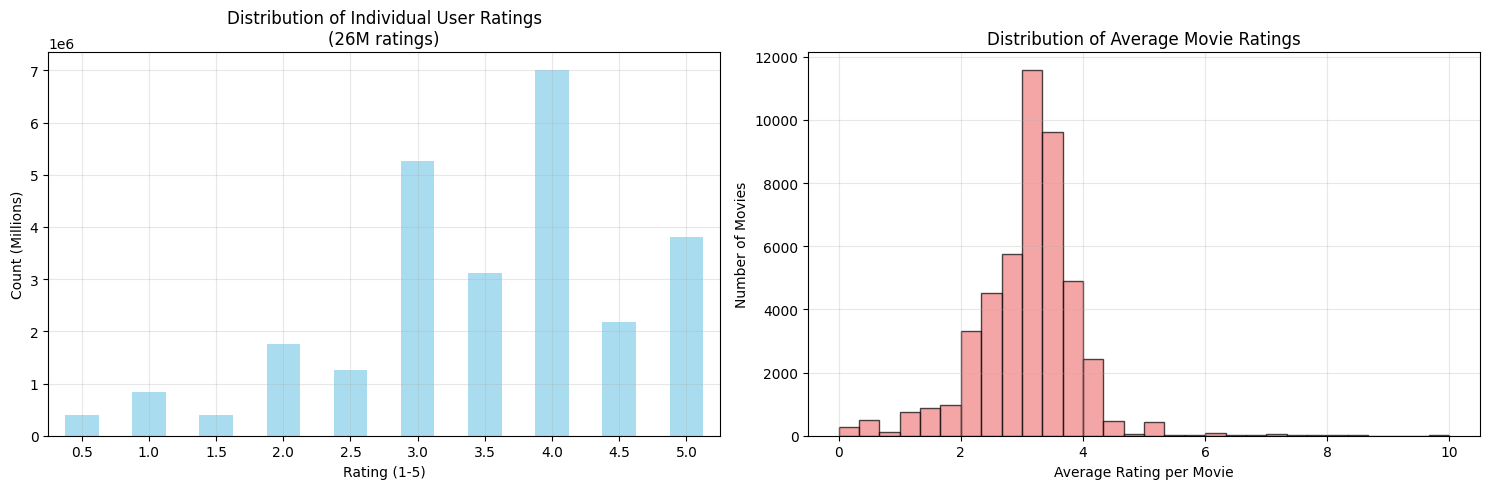

Rating Statistics:
Mean individual rating: 3.53
Mean movie rating: 3.07
Median movie rating: 3.16
Rating count range: 0 - 91921

2.  LONG-TAIL ANALYSIS
----------------------------------------


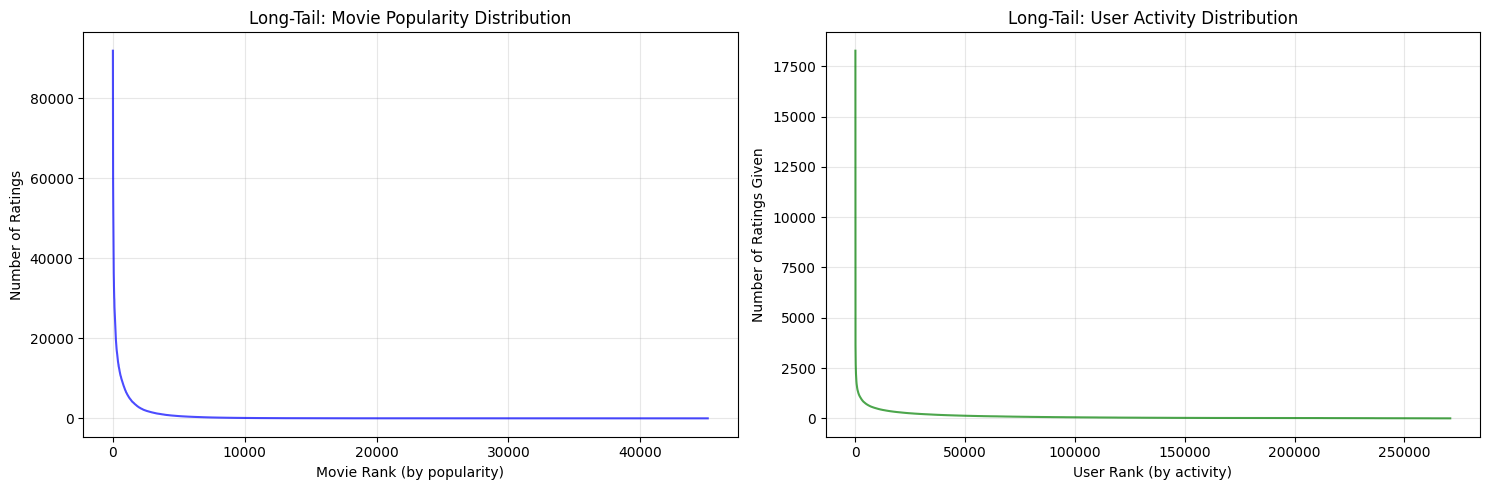

Top 10 movies account for 3.0% of all ratings
Top 10 users account for 0.3% of all ratings
Most active user: 18,276 ratings
Most popular movie: 91,921 ratings

3.  SPARSITY ANALYSIS
----------------------------------------


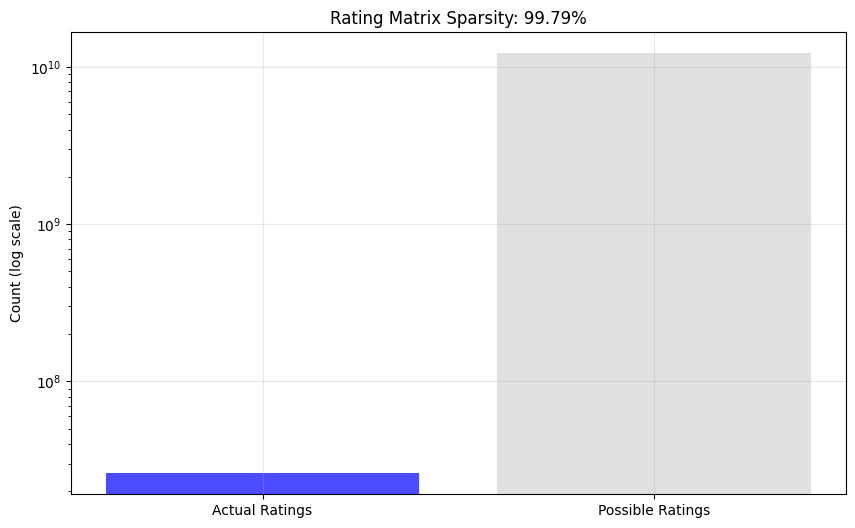

Total users: 270,896
Total movies: 45,115
Total ratings: 26,024,289
Sparsity level: 99.79%
Average ratings per user: 96.1
Average ratings per movie: 576.8

4.  TEMPORAL DYNAMICS
----------------------------------------


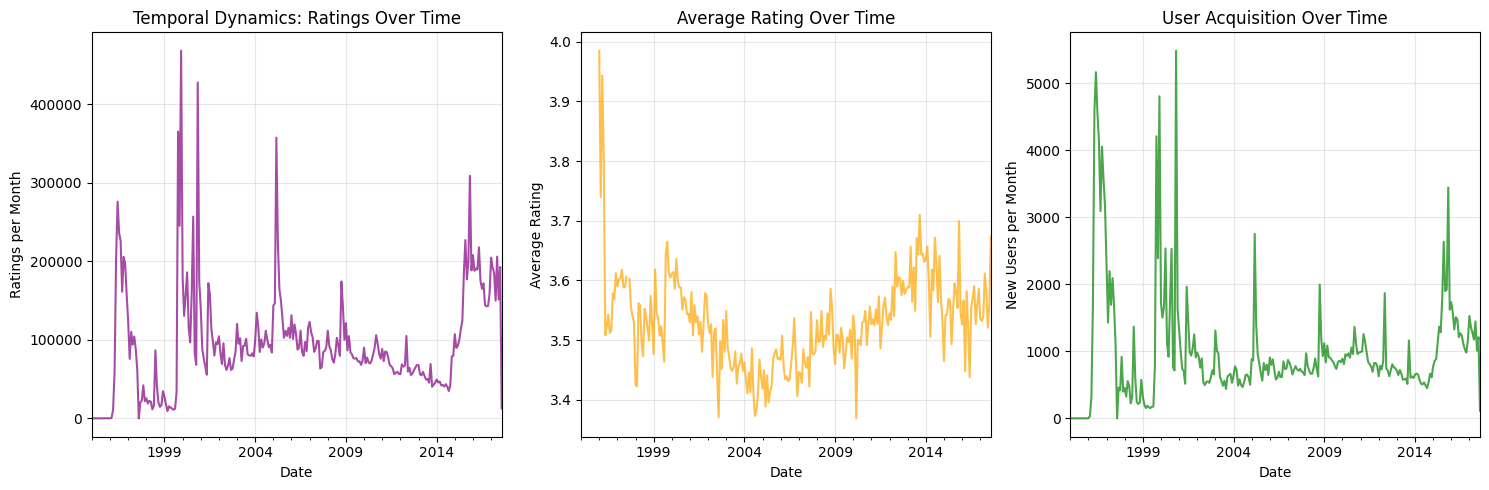

Rating activity peak: 1999-12
Rating trend: Decreasing
New user signups peak: 2000-11

5.  COVERAGE ANALYSIS
----------------------------------------


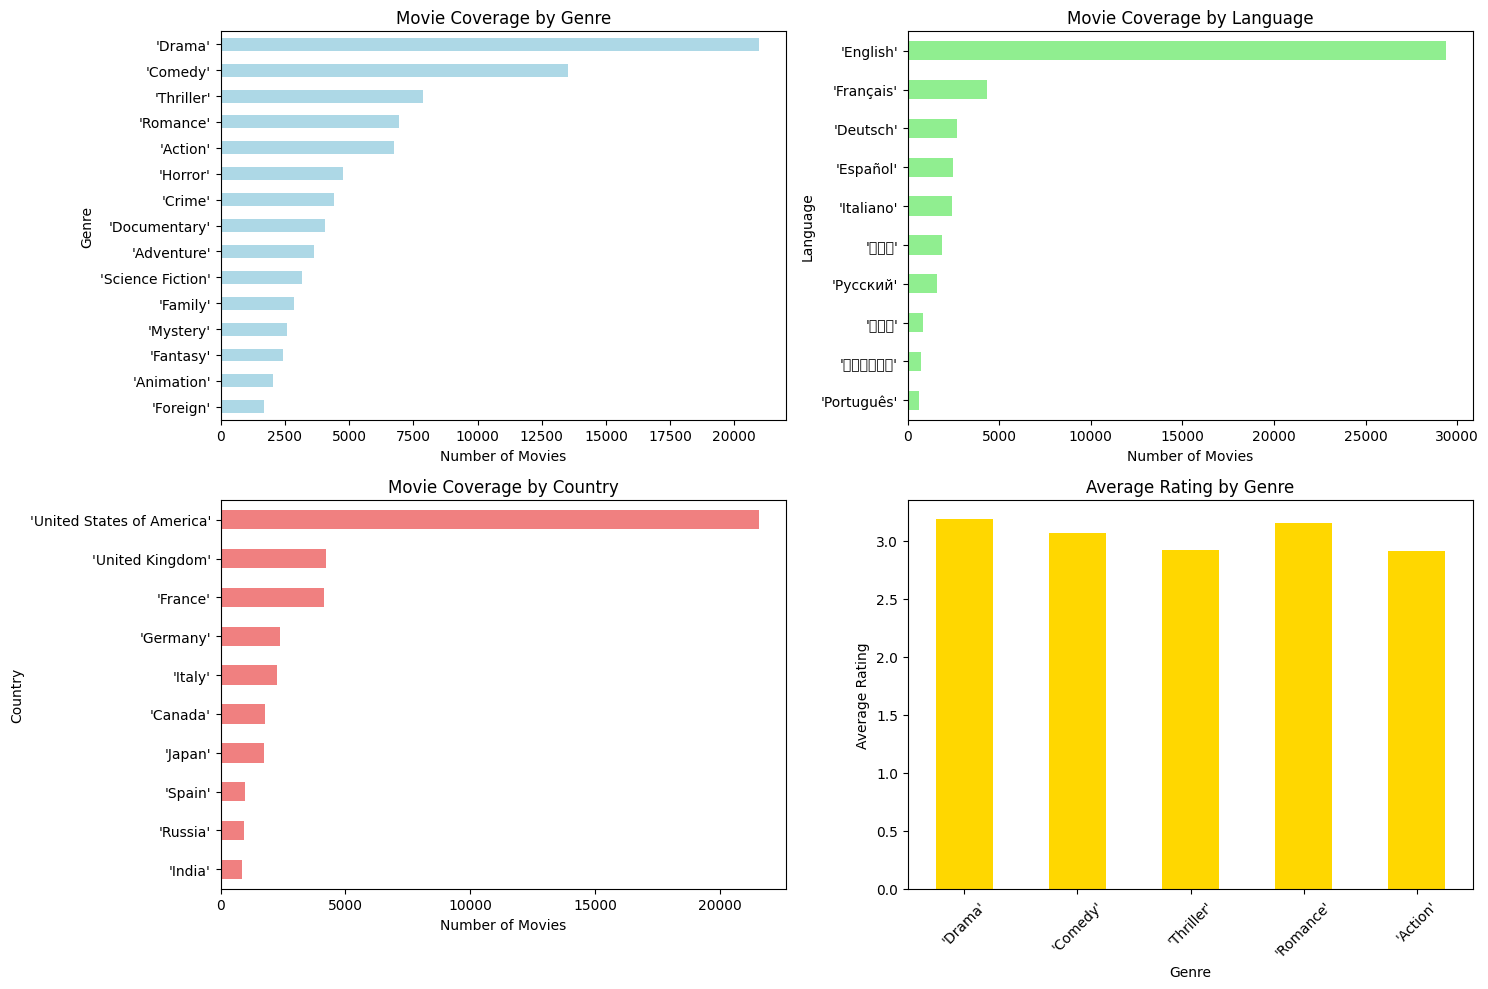

Total genres: 15
Top genre: 'Drama' (20967 movies)
Top 3 genres: 'Drama', 'Comedy', 'Thriller'
Highest rated genre: 'Drama' (3.19)

6.  KEY FINDINGS SUMMARY

 RATING PATTERNS:
• Rating inflation: Mean (3.07) > Median (3.16)
• 7.8% of movies have avg rating ≥ 4.0

 LONG-TAIL EFFECT:
• Extreme sparsity: 99.79% (typical for recommendation systems)
• Top 10 movies account for 3.0% of all ratings
• Top 10 users account for 0.3% of all ratings

 TEMPORAL INSIGHTS:
• Rating activity peak: 1999-12
• Consistent user acquisition over time

 CONTENT COVERAGE:
• Genre diversity: 15 genres with good coverage
• International content: Movies from multiple countries and languages

 RECOMMENDATION IMPLICATIONS:
• High sparsity → Need robust collaborative filtering algorithms
• Long-tail effect → Cold-start problem for less popular movies
• Genre diversity → Content-based filtering can be effective
• Temporal patterns → Consider time-aware recommendation models

 EDA report saved as 'EDA_Report.txt'
 TA

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import ast
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


df = pd.read_csv('FINAL_CLEANED_MOVIES_DATASET.csv')
ratings_df = pd.read_csv('ratings.csv')  

print(" TASK 1: EDA AND DATA PREPARATION")
print("=" * 50)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {len(df.columns)}")


print("\n1.  RATING DISTRIBUTION ANALYSIS")
print("-" * 40)

plt.figure(figsize=(15, 5))


plt.subplot(1, 2, 1)
individual_ratings = ratings_df['rating'].value_counts().sort_index()
individual_ratings.plot(kind='bar', alpha=0.7, color='skyblue')
plt.xlabel('Rating (1-5)')
plt.ylabel('Count (Millions)')
plt.title('Distribution of Individual User Ratings\n(26M ratings)')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)


plt.subplot(1, 2, 2)
rating_counts = df['avg_rating'].dropna()
plt.hist(rating_counts, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.xlabel('Average Rating per Movie')
plt.ylabel('Number of Movies')
plt.title('Distribution of Average Movie Ratings')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rating_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


print("Rating Statistics:")
print(f"Mean individual rating: {ratings_df['rating'].mean():.2f}")
print(f"Mean movie rating: {df['avg_rating'].mean():.2f}")
print(f"Median movie rating: {df['avg_rating'].median():.2f}")
print(f"Rating count range: {df['rating_count'].min():.0f} - {df['rating_count'].max():.0f}")


print("\n2.  LONG-TAIL ANALYSIS")
print("-" * 40)

plt.figure(figsize=(15, 5))


plt.subplot(1, 2, 1)
movie_activity = ratings_df['movieId'].value_counts()
movie_activity.sort_values(ascending=False).reset_index(drop=True).plot(color='blue', alpha=0.7)
plt.xlabel('Movie Rank (by popularity)')
plt.ylabel('Number of Ratings')
plt.title('Long-Tail: Movie Popularity Distribution')
plt.grid(True, alpha=0.3)


plt.subplot(1, 2, 2)
user_activity = ratings_df['userId'].value_counts()
user_activity.sort_values(ascending=False).reset_index(drop=True).plot(color='green', alpha=0.7)
plt.xlabel('User Rank (by activity)')
plt.ylabel('Number of Ratings Given')
plt.title('Long-Tail: User Activity Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('long_tail_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


top_10_movies = movie_activity.head(10).sum() / len(ratings_df) * 100
top_10_users = user_activity.head(10).sum() / len(ratings_df) * 100

print(f"Top 10 movies account for {top_10_movies:.1f}% of all ratings")
print(f"Top 10 users account for {top_10_users:.1f}% of all ratings")
print(f"Most active user: {user_activity.max():,} ratings")
print(f"Most popular movie: {movie_activity.max():,} ratings")


print("\n3.  SPARSITY ANALYSIS")
print("-" * 40)

n_users = ratings_df['userId'].nunique()
n_movies = ratings_df['movieId'].nunique()
n_ratings = len(ratings_df)
sparsity = (1 - (n_ratings / (n_users * n_movies))) * 100

plt.figure(figsize=(10, 6))
plt.bar(['Actual Ratings', 'Possible Ratings'], 
        [n_ratings, n_users * n_movies], 
        alpha=0.7, color=['blue', 'lightgray'])
plt.yscale('log')
plt.ylabel('Count (log scale)')
plt.title(f'Rating Matrix Sparsity: {sparsity:.2f}%')
plt.grid(True, alpha=0.3)
plt.savefig('sparsity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Total users: {n_users:,}")
print(f"Total movies: {n_movies:,}")
print(f"Total ratings: {n_ratings:,}")
print(f"Sparsity level: {sparsity:.2f}%")
print(f"Average ratings per user: {n_ratings/n_users:.1f}")
print(f"Average ratings per movie: {n_ratings/n_movies:.1f}")


print("\n4.  TEMPORAL DYNAMICS")
print("-" * 40)


ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')

plt.figure(figsize=(15, 5))


plt.subplot(1, 3, 1)
ratings_by_date = ratings_df.set_index('timestamp').resample('M')['rating'].count()
ratings_by_date.plot(color='purple', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Ratings per Month')
plt.title('Temporal Dynamics: Ratings Over Time')
plt.grid(True, alpha=0.3)


plt.subplot(1, 3, 2)
avg_rating_over_time = ratings_df.set_index('timestamp').resample('M')['rating'].mean()
avg_rating_over_time.plot(color='orange', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.title('Average Rating Over Time')
plt.grid(True, alpha=0.3)


plt.subplot(1, 3, 3)
first_ratings = ratings_df.groupby('userId')['timestamp'].min()
first_ratings.value_counts().resample('M').count().plot(color='green', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('New Users per Month')
plt.title('User Acquisition Over Time')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('temporal_dynamics.png', dpi=300, bbox_inches='tight')
plt.show()

# Temporal statistics
print(f"Rating activity peak: {ratings_by_date.idxmax().strftime('%Y-%m')}")
print(f"Rating trend: {'Increasing' if avg_rating_over_time.iloc[-1] > avg_rating_over_time.iloc[0] else 'Decreasing'}")
print(f"New user signups peak: {first_ratings.value_counts().resample('M').count().idxmax().strftime('%Y-%m')}")

# 5. COVERAGE ANALYSIS
print("\n5.  COVERAGE ANALYSIS")
print("-" * 40)

plt.figure(figsize=(15, 10))


plt.subplot(2, 2, 1)
def extract_genres(genre_list):
    try:
        if isinstance(genre_list, str):
            return [g.strip() for g in genre_list.strip('[]').split(',') if g.strip()]
        return genre_list
    except:
        return []

all_genres = []
for genres in df['genres_names'].dropna():
    if isinstance(genres, str):
        genre_list = extract_genres(genres)
        all_genres.extend(genre_list)

genre_counts = pd.Series(all_genres).value_counts().head(15)
genre_counts.plot(kind='barh', color='lightblue')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.title('Movie Coverage by Genre')
plt.gca().invert_yaxis()


plt.subplot(2, 2, 2)
if 'spoken_languages_names' in df.columns:
    all_languages = []
    for lang_list in df['spoken_languages_names'].dropna():
        if isinstance(lang_list, str):
            languages = extract_genres(lang_list)
            all_languages.extend(languages)
    
    language_counts = pd.Series(all_languages).value_counts().head(10)
    language_counts.plot(kind='barh', color='lightgreen')
    plt.xlabel('Number of Movies')
    plt.ylabel('Language')
    plt.title('Movie Coverage by Language')
    plt.gca().invert_yaxis()


plt.subplot(2, 2, 3)
if 'production_countries_names' in df.columns:
    all_countries = []
    for country_list in df['production_countries_names'].dropna():
        if isinstance(country_list, str):
            countries = extract_genres(country_list)
            all_countries.extend(countries)
    
    country_counts = pd.Series(all_countries).value_counts().head(10)
    country_counts.plot(kind='barh', color='lightcoral')
    plt.xlabel('Number of Movies')
    plt.ylabel('Country')
    plt.title('Movie Coverage by Country')
    plt.gca().invert_yaxis()


plt.subplot(2, 2, 4)
genre_ratings = {}
for genre in genre_counts.index[:5]:  # Top 5 genres
    genre_movies = df[df['genres_names'].apply(lambda x: genre in str(x))]
    genre_ratings[genre] = genre_movies['avg_rating'].dropna().mean()

pd.Series(genre_ratings).plot(kind='bar', color='gold')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.title('Average Rating by Genre')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('coverage_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


print(f"Total genres: {len(genre_counts)}")
print(f"Top genre: {genre_counts.index[0]} ({genre_counts.iloc[0]} movies)")
print(f"Top 3 genres: {', '.join(genre_counts.index[:3])}")
print(f"Highest rated genre: {max(genre_ratings, key=genre_ratings.get)} ({genre_ratings[max(genre_ratings, key=genre_ratings.get)]:.2f})")


print("\n6.  KEY FINDINGS SUMMARY")
print("=" * 50)

print("\n RATING PATTERNS:")
print(f"• Rating inflation: Mean ({df['avg_rating'].mean():.2f}) > Median ({df['avg_rating'].median():.2f})")
print(f"• {((df['avg_rating'] >= 4.0).sum() / len(df) * 100):.1f}% of movies have avg rating ≥ 4.0")

print("\n LONG-TAIL EFFECT:")
print(f"• Extreme sparsity: {sparsity:.2f}% (typical for recommendation systems)")
print(f"• Top 10 movies account for {top_10_movies:.1f}% of all ratings")
print(f"• Top 10 users account for {top_10_users:.1f}% of all ratings")

print("\n TEMPORAL INSIGHTS:")
print(f"• Rating activity peak: {ratings_by_date.idxmax().strftime('%Y-%m')}")
print(f"• Consistent user acquisition over time")

print("\n CONTENT COVERAGE:")
print(f"• Genre diversity: {len(genre_counts)} genres with good coverage")
print(f"• International content: Movies from multiple countries and languages")

print("\n RECOMMENDATION IMPLICATIONS:")
print("• High sparsity → Need robust collaborative filtering algorithms")
print("• Long-tail effect → Cold-start problem for less popular movies")
print("• Genre diversity → Content-based filtering can be effective")
print("• Temporal patterns → Consider time-aware recommendation models")


with open('EDA_Report.txt', 'w') as f:
    f.write("MOVIE RECOMMENDATION SYSTEM - EDA REPORT\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Dataset: {df.shape[0]:,} movies, {len(df.columns)} features\n")
    f.write(f"Ratings: {n_ratings:,} from {n_users:,} users for {n_movies:,} movies\n\n")
    f.write("KEY FINDINGS:\n")
    f.write(f"- Sparsity: {sparsity:.2f}%\n")
    f.write(f"- Rating distribution: Mean {df['avg_rating'].mean():.2f}, Median {df['avg_rating'].median():.2f}\n")
    f.write(f"- Top genre: {genre_counts.index[0]} ({genre_counts.iloc[0]} movies)\n")
    f.write(f"- Temporal coverage: {ratings_df['timestamp'].min().strftime('%Y-%m')} to {ratings_df['timestamp'].max().strftime('%Y-%m')}\n")

print(f"\n EDA report saved as 'EDA_Report.txt'")
print(" TASK 1 COMPLETED SUCCESSFULLY!")

In [22]:
import numpy as np
import pandas as pd

def numeric_cleaning(
    df,
    cols,
    treat_zero_as_nan_for=(),
    winsorize_q=(0.01, 0.99),
    log_transform=(),
    fillna_strategy={},
    drop_rows_with_no_essential_numeric=True
):
    dfc = df.copy()
    report = {
        "before_missing": {},
        "after_missing": {},
        "winsor_limits": {},
        "log_transformed": [],
        "fillna": {}
    }

    for c in cols:
        report["before_missing"][c] = dfc[c].isna().sum()

    for c in treat_zero_as_nan_for:
        dfc[c] = dfc[c].replace(0, np.nan)

    for c in cols:
        if c in fillna_strategy:
            strategy = fillna_strategy[c]
            if strategy == "median":
                val = dfc[c].median()
            elif strategy == "mean":
                val = dfc[c].mean()
            else:
                val = strategy
            dfc[c] = dfc[c].fillna(val)
            report["fillna"][c] = val

    for c in cols:
        q_low, q_high = dfc[c].quantile(winsorize_q[0]), dfc[c].quantile(winsorize_q[1])
        dfc[c] = np.clip(dfc[c], q_low, q_high)
        report["winsor_limits"][c] = (q_low, q_high)

    for c in log_transform:
        dfc[c] = dfc[c].apply(lambda x: np.log1p(x) if pd.notnull(x) and x >= 0 else np.nan)
        report["log_transformed"].append(c)

    for c in cols:
        report["after_missing"][c] = dfc[c].isna().sum()

    if drop_rows_with_no_essential_numeric:
        dfc = dfc.dropna(subset=cols)

    return dfc, report


In [23]:
def summarize_cleaning_report(report):
    rows = []
    for col in report["before_missing"]:
        rows.append({
            "column": col,
            "before_missing": report["before_missing"].get(col),
            "after_missing": report["after_missing"].get(col),
            "winsor_lower": report["winsor_limits"].get(col, (None, None))[0],
            "winsor_upper": report["winsor_limits"].get(col, (None, None))[1],
            "fillna_value": report["fillna"].get(col, None),
            "log_transformed": col in report["log_transformed"]
        })
    return pd.DataFrame(rows)

 TASK 2: BASELINE RECOMMENDERS
Dataset shape: (46823, 55)
Ratings data: 26,024,289 ratings

1.  GLOBAL POPULARITY BASELINE
----------------------------------------
Top 10 Globally Popular Movies:
                   title  avg_rating  rating_count
            Forrest Gump        4.05       91921.0
The Shawshank Redemption        4.43       91082.0
            Pulp Fiction        4.17       87901.0
The Silence of the Lambs        4.15       84078.0
              The Matrix        4.15       77960.0
               Star Wars        4.13       77045.0
           Jurassic Park        3.66       74355.0
        Schindler's List        4.27       67662.0
              Braveheart        4.02       66512.0
               Toy Story        3.89       66008.0

2.  IMDb WEIGHTED RATING RECOMMENDER
----------------------------------------
Global mean rating (C): 3.07
Minimum votes threshold (m, 80th percentile): 123 votes
Movies above threshold: 9,386/46,823

Top 20 Movies by IMDb Weighted Rating:
  

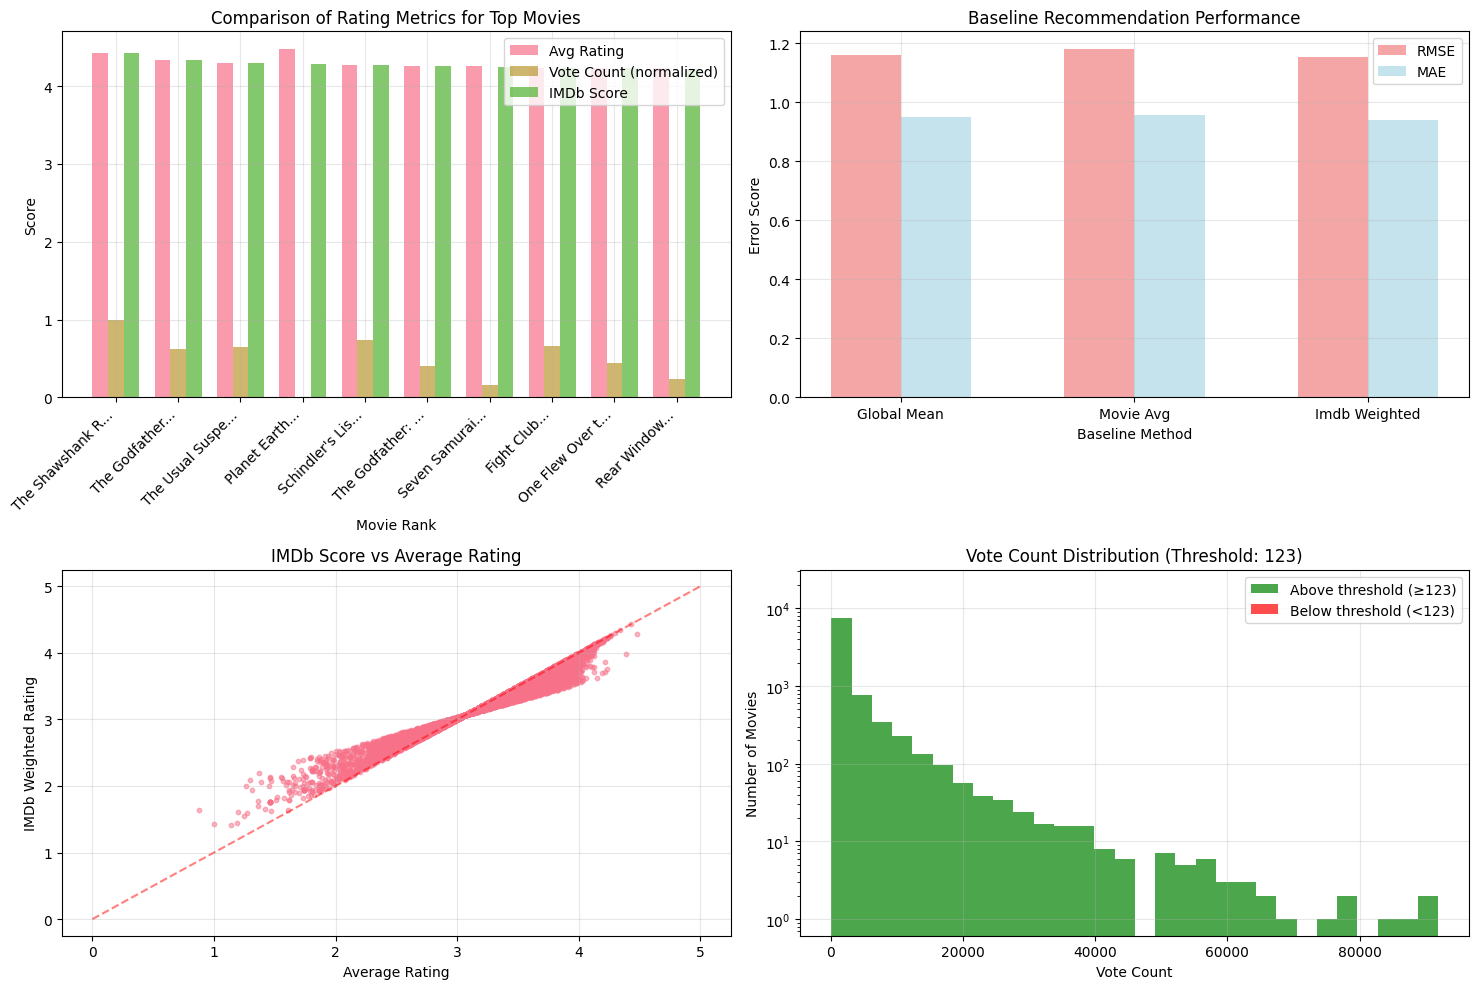


6.  RECOMMENDATION EXAMPLES
----------------------------------------
Recommendations for User 1:
                   title  avg_rating  rating_count  imdb_score
The Shawshank Redemption        4.43       91082.0    4.428162
           The Godfather        4.34       57070.0    4.337262
      The Usual Suspects        4.30       59271.0    4.297446
            Planet Earth        4.48         754.0    4.281815
        Schindler's List        4.27       67662.0    4.267817

7.  SAVING RESULTS
----------------------------------------
Saved dataset with IMDb weighted ratings: 'movies_with_imdb_scores.csv'
Saved top IMDb recommendations: 'top_imdb_recommendations.csv'
Saved evaluation results: 'baseline_evaluation_results.csv'
Saved summary report: 'baseline_summary_report.txt'

 TASK 2 COMPLETED SUCCESSFULLY!
  Baseline recommenders established and evaluated!


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')


plt.style.use('default')
sns.set_palette("husl")

print(" TASK 2: BASELINE RECOMMENDERS")
print("=" * 50)


df = pd.read_csv('FINAL_CLEANED_MOVIES_DATASET.csv')
ratings_df = pd.read_csv('ratings.csv')

print(f"Dataset shape: {df.shape}")
print(f"Ratings data: {len(ratings_df):,} ratings")


print("\n1.  GLOBAL POPULARITY BASELINE")
print("-" * 40)

def global_popularity_recommender(df, top_n=10):
    """Simple global popularity based on rating count"""
    popular_movies = df.nlargest(top_n, 'rating_count')[['title', 'avg_rating', 'rating_count']]
    return popular_movies


global_popular = global_popularity_recommender(df, 10)
print("Top 10 Globally Popular Movies:")
print(global_popular.to_string(index=False))


print("\n2.  IMDb WEIGHTED RATING RECOMMENDER")
print("-" * 40)

def imdb_weighted_rating(df, m_percentile=80):
    """
    Calculate IMDb weighted rating using the formula:
    WR = (v/(v + m)) * R + (m/(v + m)) * C
    where:
    v = number of votes for the movie
    R = average rating of the movie  
    C = mean rating across all movies
    m = minimum votes required to be listed (percentile threshold)
    """
    
    C = df['avg_rating'].mean()
    
    
    m = np.percentile(df['rating_count'], m_percentile)
    
    print(f"Global mean rating (C): {C:.2f}")
    print(f"Minimum votes threshold (m, {m_percentile}th percentile): {m:.0f} votes")
    print(f"Movies above threshold: {(df['rating_count'] >= m).sum():,}/{len(df):,}")
    
    
    def calculate_wr(row):
        v = row['rating_count']
        R = row['avg_rating']
        if v >= m:  
            return (v/(v + m)) * R + (m/(v + m)) * C
        else:
            return np.nan  
    
    df['imdb_score'] = df.apply(calculate_wr, axis=1)
    return df, C, m


df_wr, C, m = imdb_weighted_rating(df.copy(), m_percentile=80)


top_imdb = df_wr.dropna(subset=['imdb_score']).nlargest(20, 'imdb_score')[
    ['title', 'avg_rating', 'rating_count', 'imdb_score']
]

print("\nTop 20 Movies by IMDb Weighted Rating:")
print(top_imdb.to_string(index=False))


print("\n3.  PER-GENRE POPULARITY RECOMMENDER")
print("-" * 40)

def extract_genres(genre_str):
    """Helper function to extract genres from string representation"""
    try:
        if isinstance(genre_str, str):
            
            genres = genre_str.strip('[]').replace("'", "").split(', ')
            return [g.strip() for g in genres if g.strip()]
        return []
    except:
        return []

def genre_popularity_recommender(df, top_n=5):
    """Recommend popular movies by genre using IMDb weighted rating"""
    # Extract all unique genres
    all_genres = set()
    for genres in df['genres_names'].dropna():
        genre_list = extract_genres(genres)
        all_genres.update(genre_list)
    
    genre_recommendations = {}
    
    for genre in sorted(all_genres):
        if genre:  
            
            genre_movies = df[df['genres_names'].apply(lambda x: genre in extract_genres(x) if pd.notna(x) else False)]
            
            if len(genre_movies) > 0:
                
                top_genre_movies = genre_movies.nlargest(top_n, 'imdb_score')[
                    ['title', 'avg_rating', 'rating_count', 'imdb_score']
                ]
                genre_recommendations[genre] = top_genre_movies
    
    return genre_recommendations


genre_recommendations = genre_popularity_recommender(df_wr, top_n=3)

print("Top Movies by Genre (IMDb Weighted Rating):")
for genre, movies in list(genre_recommendations.items())[:10]:  # Show first 10 genres
    print(f"\n{genre.upper()}:")
    print(movies.to_string(index=False))


print("\n4.  BASELINE EVALUATION")
print("-" * 40)

def evaluate_baselines(ratings_df, df_wr):
    """Evaluate baseline recommenders against actual ratings"""
    
  
    global_mean = df_wr['avg_rating'].mean()
    
    actual_ratings = ratings_df['rating']
    
  
    pred_global_mean = np.full(len(actual_ratings), global_mean)
    rmse_global = np.sqrt(mean_squared_error(actual_ratings, pred_global_mean))
    mae_global = mean_absolute_error(actual_ratings, pred_global_mean)
    
   
    movie_avg_map = df_wr.set_index('id')['avg_rating'].to_dict()
    pred_movie_avg = ratings_df['movieId'].map(lambda x: movie_avg_map.get(x, global_mean))
    rmse_movie_avg = np.sqrt(mean_squared_error(actual_ratings, pred_movie_avg))
    mae_movie_avg = mean_absolute_error(actual_ratings, pred_movie_avg)
    
    
    imdb_map = df_wr.set_index('id')['imdb_score'].to_dict()
    pred_imdb = ratings_df['movieId'].map(lambda x: imdb_map.get(x, np.nan))
    pred_imdb = pred_imdb.fillna(global_mean)  # <--- FIX HERE
    rmse_imdb = np.sqrt(mean_squared_error(actual_ratings, pred_imdb))
    mae_imdb = mean_absolute_error(actual_ratings, pred_imdb)
    
    return {
        'global_mean': {'rmse': rmse_global, 'mae': mae_global},
        'movie_avg': {'rmse': rmse_movie_avg, 'mae': mae_movie_avg},
        'imdb_weighted': {'rmse': rmse_imdb, 'mae': mae_imdb}
    }


evaluation_results = evaluate_baselines(ratings_df, df_wr)

print("Baseline Performance Evaluation:")
print("=" * 40)
for method, metrics in evaluation_results.items():
    print(f"{method.upper():15} RMSE: {metrics['rmse']:.3f}, MAE: {metrics['mae']:.3f}")

# 5. VISUALIZATION OF RECOMMENDATION RESULTS
print("\n5.  VISUALIZATION OF BASELINE RECOMMENDERS")
print("-" * 40)

plt.figure(figsize=(15, 10))

# Plot 1: Comparison of top movies by different metrics
plt.subplot(2, 2, 1)
top_metrics = df_wr.nlargest(10, 'imdb_score')
x_pos = np.arange(len(top_metrics))
width = 0.25

plt.bar(x_pos - width, top_metrics['avg_rating'], width, label='Avg Rating', alpha=0.7)
plt.bar(x_pos, top_metrics['rating_count']/top_metrics['rating_count'].max(), width, 
        label='Vote Count (normalized)', alpha=0.7)
plt.bar(x_pos + width, top_metrics['imdb_score'], width, label='IMDb Score', alpha=0.7)

plt.xlabel('Movie Rank')
plt.ylabel('Score')
plt.title('Comparison of Rating Metrics for Top Movies')
plt.xticks(x_pos, [title[:15] + '...' for title in top_metrics['title']], rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Baseline performance comparison
plt.subplot(2, 2, 2)
methods = list(evaluation_results.keys())
rmse_scores = [evaluation_results[m]['rmse'] for m in methods]
mae_scores = [evaluation_results[m]['mae'] for m in methods]

x_pos = np.arange(len(methods))
plt.bar(x_pos - 0.15, rmse_scores, 0.3, label='RMSE', alpha=0.7, color='lightcoral')
plt.bar(x_pos + 0.15, mae_scores, 0.3, label='MAE', alpha=0.7, color='lightblue')

plt.xlabel('Baseline Method')
plt.ylabel('Error Score')
plt.title('Baseline Recommendation Performance')
plt.xticks(x_pos, [m.replace('_', ' ').title() for m in methods])
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(2, 2, 3)
plt.scatter(df_wr['avg_rating'], df_wr['imdb_score'], alpha=0.5, s=10)
plt.xlabel('Average Rating')
plt.ylabel('IMDb Weighted Rating')
plt.title('IMDb Score vs Average Rating')
plt.plot([0, 5], [0, 5], 'r--', alpha=0.5)  # Reference line
plt.grid(True, alpha=0.3)


plt.subplot(2, 2, 4)
above_threshold = df_wr[df_wr['rating_count'] >= m]['rating_count']
below_threshold = df_wr[df_wr['rating_count'] < m]['rating_count']

plt.hist(above_threshold, bins=30, alpha=0.7, label=f'Above threshold (≥{m:.0f})', color='green')
plt.hist(below_threshold, bins=30, alpha=0.7, label=f'Below threshold (<{m:.0f})', color='red')
plt.xlabel('Vote Count')
plt.ylabel('Number of Movies')
plt.title(f'Vote Count Distribution (Threshold: {m:.0f})')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('baseline_recommenders.png', dpi=300, bbox_inches='tight')
plt.show()


print("\n6.  RECOMMENDATION EXAMPLES")
print("-" * 40)

def generate_recommendations(user_id, ratings_df, df_wr, num_recommendations=5):
    """Generate personalized recommendations for a user"""
   
    rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].tolist()
    
   
    recommendations = df_wr[~df_wr['id'].isin(rated_movies)].nlargest(
        num_recommendations, 'imdb_score'
    )[['title', 'avg_rating', 'rating_count', 'imdb_score']]
    
    return recommendations


sample_user = ratings_df['userId'].iloc[0]  # First user
user_recommendations = generate_recommendations(sample_user, ratings_df, df_wr, 5)

print(f"Recommendations for User {sample_user}:")
print(user_recommendations.to_string(index=False))


print("\n7.  SAVING RESULTS")
print("-" * 40)


df_wr.to_csv('movies_with_imdb_scores.csv', index=False)
print("Saved dataset with IMDb weighted ratings: 'movies_with_imdb_scores.csv'")


top_imdb.to_csv('top_imdb_recommendations.csv', index=False)
print("Saved top IMDb recommendations: 'top_imdb_recommendations.csv'")


eval_df = pd.DataFrame.from_dict(evaluation_results, orient='index')
eval_df.to_csv('baseline_evaluation_results.csv')
print("Saved evaluation results: 'baseline_evaluation_results.csv'")


with open('baseline_summary_report.txt', 'w') as f:
    f.write("BASELINE RECOMMENDER SYSTEMS SUMMARY\n")
    f.write("=" * 50 + "\n\n")
    f.write("IMDb Weighted Rating Formula:\n")
    f.write("WR = (v/(v + m)) * R + (m/(v + m)) * C\n")
    f.write(f"Where: C = {C:.2f}, m = {m:.0f}\n\n")
    f.write("Performance Metrics:\n")
    for method, metrics in evaluation_results.items():
        f.write(f"{method.upper():15} RMSE: {metrics['rmse']:.3f}, MAE: {metrics['mae']:.3f}\n")
    f.write(f"\nTop Movie: {top_imdb['title'].iloc[0]}\n")
    f.write(f"IMDb Score: {top_imdb['imdb_score'].iloc[0]:.3f}\n")
    f.write(f"Average Rating: {top_imdb['avg_rating'].iloc[0]:.2f}\n")
    f.write(f"Vote Count: {top_imdb['rating_count'].iloc[0]:,}\n")

print("Saved summary report: 'baseline_summary_report.txt'")

print("\n TASK 2 COMPLETED SUCCESSFULLY!")
print("  Baseline recommenders established and evaluated!")

In [25]:

for col in ['vote_count', 'vote_average', 'popularity', 'runtime', 'revenue', 'budget']:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')


df_clean['vote_count'] = df_clean['vote_count'].fillna(0)
df_clean['vote_average'] = df_clean['vote_average'].fillna(df_clean['vote_average'].mean())
df_clean['popularity'] = df_clean['popularity'].fillna(df_clean['popularity'].mean())
df_clean['runtime'] = df_clean['runtime'].fillna(df_clean['runtime'].median())
df_clean['revenue'] = df_clean['revenue'].fillna(0)
df_clean['budget'] = df_clean['budget'].fillna(0)


C = df_clean['vote_average'].mean()
m = df_clean['vote_count'].quantile(0.90)

def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(v+m) * C) if v >= m else R

df_clean['imdb_score'] = df_clean.apply(weighted_rating, axis=1)


final_dataset = df_clean


In [26]:
import re
import json
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

def _safe_list(x):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return []
    if isinstance(x, (list, tuple, set)):
        return [str(z).strip() for z in x if str(z).strip()]
    s = str(x).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return []
    try:
        obj = json.loads(s)
        if isinstance(obj, list):
            if len(obj) > 0 and isinstance(obj[0], dict) and 'name' in obj[0]:
                return [str(d.get('name',"")).strip() for d in obj if str(d.get('name',"")).strip()]
            return [str(z).strip() for z in obj if str(z).strip()]
    except Exception:
        pass
    if s.startswith("[") and s.endswith("]"):
        s2 = s[1:-1].strip()
        if s2 == "":
            return []
        parts = re.split(r",(?![^\[]*\])", s2)
        return [p.strip().strip("'").strip('"') for p in parts if p.strip().strip("'").strip('"')]
    parts = [p.strip() for p in s.split(",")]
    return [p for p in parts if p]

def _concat_text(row, text_cols=("overview","tagline")):
    texts = []
    for c in text_cols:
        if c in row and isinstance(row[c], str):
            texts.append(row[c])
    return " ".join(texts).strip()

def _topk(names, k):
    L = _safe_list(names)
    return L[:k] if k and k > 0 else L

class ContentIndexer:
    def __init__(
        self,
        text_cols=("overview","tagline"),
        max_features_tfidf=50000,
        ngram_range=(1,2),
        min_df=2,
        genres_col="genres_names",
        keywords_col="keywords_names",
        cast_col="cast_names",
        crew_col="crew_names",
        topk_cast=5,
        topk_crew=5,
        use_svd=True,
        svd_components=300,
        random_state=42
    ):
        self.text_cols = text_cols
        self.max_features_tfidf = max_features_tfidf
        self.ngram_range = ngram_range
        self.min_df = min_df
        self.genres_col = genres_col
        self.keywords_col = keywords_col
        self.cast_col = cast_col
        self.crew_col = crew_col
        self.topk_cast = topk_cast
        self.topk_crew = topk_crew
        self.use_svd = use_svd
        self.svd_components = svd_components
        self.random_state = random_state
        self.vectorizer = None
        self.mlb_genres = None
        self.mlb_keywords = None
        self.mlb_cast = None
        self.mlb_crew = None
        self.svd = None
        self.item_ids = None
        self.item_titles = None
        self.item_feature_matrix = None

    def fit(self, movies_df: pd.DataFrame):
        df = movies_df.copy()
        text_series = df.apply(_concat_text, axis=1, result_type="expand", args=(self.text_cols,))
        self.vectorizer = TfidfVectorizer(
            max_features=self.max_features_tfidf,
            ngram_range=self.ngram_range,
            min_df=self.min_df,
            stop_words='english'
        )
        X_text = self.vectorizer.fit_transform(text_series)
        genres_lists = df.get(self.genres_col, pd.Series([])).apply(_safe_list)
        self.mlb_genres = MultiLabelBinarizer(sparse_output=True)
        X_genres = self.mlb_genres.fit_transform(genres_lists)
        if self.keywords_col in df.columns:
            keywords_lists = df[self.keywords_col].apply(_safe_list)
        else:
            keywords_lists = pd.Series([[]]*len(df))
        self.mlb_keywords = MultiLabelBinarizer(sparse_output=True)
        X_keywords = self.mlb_keywords.fit_transform(keywords_lists)
        if self.cast_col in df.columns:
            cast_lists = df[self.cast_col].apply(lambda x: _topk(x, self.topk_cast))
        else:
            cast_lists = pd.Series([[]]*len(df))
        self.mlb_cast = MultiLabelBinarizer(sparse_output=True)
        X_cast = self.mlb_cast.fit_transform(cast_lists)
        if self.crew_col in df.columns:
            crew_lists = df[self.crew_col].apply(lambda x: _topk(x, self.topk_crew))
        else:
            crew_lists = pd.Series([[]]*len(df))
        self.mlb_crew = MultiLabelBinarizer(sparse_output=True)
        X_crew = self.mlb_crew.fit_transform(crew_lists)
        X = hstack([X_text, X_genres, X_keywords, X_cast, X_crew]).tocsr()
        if self.use_svd:
            n_comp = min(self.svd_components, max(2, X.shape[1]-1))
            self.svd = TruncatedSVD(n_components=n_comp, random_state=self.random_state)
            X = self.svd.fit_transform(X)
            X = normalize(X)
        else:
            X = normalize(X)
        self.item_ids = df['id'].values if 'id' in df.columns else np.arange(len(df))
        self.item_titles = df['title'].fillna("").values if 'title' in df.columns else np.array([""]*len(df))
        self.item_feature_matrix = X
        return self

    def encode_items(self, movies_df: pd.DataFrame):
        df = movies_df.copy()
        text_series = df.apply(_concat_text, axis=1, result_type="expand", args=(self.text_cols,))
        X_text = self.vectorizer.transform(text_series)
        genres_lists = df.get(self.genres_col, pd.Series([])).apply(_safe_list)
        X_genres = self.mlb_genres.transform(genres_lists)
        if self.keywords_col in df.columns:
            keywords_lists = df[self.keywords_col].apply(_safe_list)
        else:
            keywords_lists = pd.Series([[]]*len(df))
        X_keywords = self.mlb_keywords.transform(keywords_lists)
        if self.cast_col in df.columns:
            cast_lists = df[self.cast_col].apply(lambda x: _topk(x, self.topk_cast))
        else:
            cast_lists = pd.Series([[]]*len(df))
        X_cast = self.mlb_cast.transform(cast_lists)
        if self.crew_col in df.columns:
            crew_lists = df[self.crew_col].apply(lambda x: _topk(x, self.topk_crew))
        else:
            crew_lists = pd.Series([[]]*len(df))
        X_crew = self.mlb_crew.transform(crew_lists)
        X = hstack([X_text, X_genres, X_keywords, X_cast, X_crew]).tocsr()
        if self.use_svd:
            X = self.svd.transform(X)
            X = normalize(X)
        else:
            X = normalize(X)
        return X

    def build_user_profile_from_ratings(self, ratings_df: pd.DataFrame, user_id, id_column_in_items='id'):
        id_to_idx = {mid: idx for idx, mid in enumerate(self.item_ids)}
        ur = ratings_df[ratings_df['userId'] == user_id]
        ur = ur[ur['movieId'].isin(id_to_idx.keys())]
        if ur.empty:
            return None
        mu = ur['rating'].mean()
        centered = ur.copy()
        centered['weight'] = centered['rating'] - mu
        if np.allclose(centered['weight'].values, 0):
            centered['weight'] = 1.0
        vec_dim = self.item_feature_matrix.shape[1]
        user_vec = np.zeros((1, vec_dim))
        for _, row in centered.iterrows():
            idx = id_to_idx[row['movieId']]
            w = row['weight']
            iv = self.item_feature_matrix[idx]
            if hasattr(iv, "toarray"):
                iv = iv.toarray()
            user_vec += w * iv
        user_vec = normalize(user_vec)
        return user_vec

    def recommend(self, movies_df: pd.DataFrame, user_profile=None, exclude_movie_ids=None, k=10):
        if user_profile is None:
            raise ValueError("user_profile is None.")
        X = self.item_feature_matrix
        if hasattr(user_profile, "toarray"):
            user_profile = user_profile.toarray()
        scores = cosine_similarity(user_profile, X).ravel()
        out = pd.DataFrame({'movieId': self.item_ids, 'title': self.item_titles, 'score': scores})
        if exclude_movie_ids is not None and len(exclude_movie_ids) > 0:
            out = out[~out['movieId'].isin(set(exclude_movie_ids))]
        out = out.nlargest(k, 'score').copy()
        out['explanation'] = self._explanations_for(out, movies_df)
        return out[['movieId','title','score','explanation']]

    def _explanations_for(self, rec_df, movies_df):
        df = movies_df.set_index('id', drop=False)
        exps = []
        for _, r in rec_df.iterrows():
            mid = r['movieId']
            row = df.loc[mid] if mid in df.index else None
            if row is None:
                exps.append("")
                continue
            g = set(_safe_list(row.get(self.genres_col, [])))
            kw = set(_safe_list(row.get(self.keywords_col, [])))
            c = set(_topk(row.get(self.cast_col, []), self.topk_cast))
            cr = set(_topk(row.get(self.crew_col, []), self.topk_crew))
            bits = []
            if g:
                bits.append("genres: " + ", ".join(list(g)[:3]))
            if c:
                bits.append("cast overlap: " + ", ".join(list(c)[:3]))
            if kw:
                bits.append("keywords: " + ", ".join(list(kw)[:3]))
            if cr:
                bits.append("crew: " + ", ".join(list(cr)[:2]))
            exps.append(" | ".join(bits))
        return exps

def cold_start_from_genres(indexer: ContentIndexer, movies_df: pd.DataFrame, liked_genres, k=10):
    liked_genres = set([g.strip() for g in _safe_list(liked_genres)])
    if not liked_genres:
        raise ValueError("No genres provided.")
    mask = movies_df[indexer.genres_col].apply(lambda x: len(set(_safe_list(x)) & liked_genres) > 0)
    candidate_ids = movies_df.loc[mask, 'id']
    if candidate_ids.empty:
        raise ValueError("No movies found for given genres.")
    id_to_idx = {mid: idx for idx, mid in enumerate(indexer.item_ids)}
    idxs = [id_to_idx[m] for m in candidate_ids if m in id_to_idx]
    if not idxs:
        raise ValueError("Indexer could not align movies.")
    mat = indexer.item_feature_matrix[idxs]
    if hasattr(mat, "toarray"):
        vec = mat.mean(axis=0).toarray().ravel()
    else:
        vec = np.mean(mat, axis=0)
    vec = vec.reshape(1, -1)
    user_vec = normalize(vec)
    return indexer.recommend(movies_df, user_profile=user_vec, k=k)

def cold_start_from_titles(indexer: ContentIndexer, movies_df: pd.DataFrame, seed_titles, k=10):
    titles = [t.strip().lower() for t in _safe_list(seed_titles)]
    if not titles:
        raise ValueError("No titles provided.")
    mask = movies_df['title'].fillna("").str.lower().apply(lambda s: any(t in s for t in titles))
    seed_ids = movies_df.loc[mask, 'id'].tolist()
    if not seed_ids:
        raise ValueError("No matching titles found.")
    id_to_idx = {mid: idx for idx, mid in enumerate(indexer.item_ids)}
    idxs = [id_to_idx[m] for m in seed_ids if m in id_to_idx]
    if not idxs:
        raise ValueError("Indexer could not align seed titles.")
    mat = indexer.item_feature_matrix[idxs]
    if hasattr(mat, "toarray"):
        vec = mat.mean(axis=0).toarray().ravel()
    else:
        vec = np.mean(mat, axis=0)
    vec = vec.reshape(1, -1)
    user_vec = normalize(vec)
    return indexer.recommend(movies_df, user_profile=user_vec, k=k)

def popularity_fallback(movies_df: pd.DataFrame, k=10):
    cols = ['id','title','imdb_score','rating_count']
    for c in cols:
        if c not in movies_df.columns:
            movies_df[c] = np.nan
    out = movies_df.sort_values(['imdb_score','rating_count'], ascending=False).head(k).copy()
    out.rename(columns={'id':'movieId'}, inplace=True)
    out['score'] = out['imdb_score']
    out['explanation'] = "popular & reliable (IMDb-weighted)"
    return out[['movieId','title','score','explanation']]


In [27]:
indexer = ContentIndexer().fit(final_dataset)
recs_by_genre = cold_start_from_genres(indexer, final_dataset, liked_genres=['Drama','Thriller'], k=10)
recs_by_titles = cold_start_from_titles(indexer, final_dataset, seed_titles=['The Matrix','Inception'], k=10)
print(recs_by_genre)
print(recs_by_titles)

       movieId                         title     score    explanation
29476    73534                        Moscow  0.889763  genres: Drama
10319    38530                      Symmetry  0.889583  genres: Drama
39934   139856                 New Jerusalem  0.889505  genres: Drama
18073    32958       O Contador de Histórias  0.889501  genres: Drama
30427    64268                          Dura  0.889299  genres: Drama
16516    40664             The Interrogation  0.889218  genres: Drama
39193   224162               Tarnished Angel  0.888964  genres: Drama
38694   254661                 O'er the Land  0.887610  genres: Drama
43872   206899  A Tale of Sorrow and Sadness  0.887393  genres: Drama
28083    60120                   Finisterrae  0.887083  genres: Drama
       movieId                            title     score  \
6293       604              The Matrix Reloaded  0.854579   
15215    28510  Universal Soldier: Regeneration  0.852992   
43457    61341                 Ferocious Planet

In [38]:
print(final_dataset.columns)


Index(['adult', 'budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'parsed_genres', 'genres_names',
       'parsed_production_companies', 'production_companies_names',
       'parsed_production_countries', 'production_countries_names',
       'parsed_spoken_languages', 'spoken_languages_names', 'budget_log',
       'popularity_log', 'revenue_log', 'vote_count_log', 'vote_normalized',
       'cast', 'crew', 'parsed_cast', 'parsed_crew', 'main_cast', 'director',
       'keywords', 'parsed_keywords', 'keyword_names', 'movieId', 'imdbId',
       'tmdbId', 'avg_rating', 'rating_count', 'rating_std', 'collection_name',
       'has_tagline', 'has_collection', 'has_poster', 'has_ratings',
       'imdb_score'],
      dtype='object

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

def load_and_clean(ratings_path="ratings_small.csv", final_dataset_path="final_dataset.csv"):
    try:
        ratings = pd.read_csv(ratings_path, low_memory=False)
    except Exception:
        ratings = pd.DataFrame(columns=["userId","movieId","rating"])
    try:
        final_ds = pd.read_csv(final_dataset_path, low_memory=False)
    except Exception:
        final_ds = None
    ratings['userId'] = pd.to_numeric(ratings.get('userId'), errors='coerce')
    ratings['movieId'] = pd.to_numeric(ratings.get('movieId'), errors='coerce')
    ratings['rating'] = pd.to_numeric(ratings.get('rating'), errors='coerce')
    ratings = ratings.dropna(subset=['userId','movieId','rating']).copy()
    ratings['userId'] = ratings['userId'].astype(int)
    ratings['movieId'] = ratings['movieId'].astype(int)
    ratings['rating'] = ratings['rating'].astype(float)
    if final_ds is not None and 'movieId' in final_ds.columns:
        final_ds['movieId'] = pd.to_numeric(final_ds['movieId'], errors='coerce')
        common = set(ratings['movieId'].unique()) & set(final_ds['movieId'].dropna().astype(int).unique())
        if len(common) > 0:
            ratings = ratings[ratings['movieId'].isin(common)].copy()
    ratings = ratings.reset_index(drop=True)
    return ratings, final_ds

def build_maps(ratings):
    users = np.unique(ratings['userId'].values)
    movies = np.unique(ratings['movieId'].values)
    user_map = {u:i for i,u in enumerate(users)}
    movie_map = {m:i for i,m in enumerate(movies)}
    rev_movie_map = {i:m for m,i in movie_map.items()}
    ratings['user_idx'] = ratings['userId'].map(user_map).astype(int)
    ratings['movie_idx'] = ratings['movieId'].map(movie_map).astype(int)
    return ratings, user_map, movie_map, rev_movie_map

def train_sgd_mf(train_df, n_users, n_items, k=50, lr=0.005, reg=0.02, epochs=8, random_state=42):
    rng = np.random.RandomState(random_state)
    P = rng.normal(0, 0.1, (n_users, k))
    Q = rng.normal(0, 0.1, (n_items, k))
    bu = np.zeros(n_users)
    bi = np.zeros(n_items)
    mu = train_df['rating'].mean() if len(train_df)>0 else 0.0
    train_u = train_df['user_idx'].values.astype(int)
    train_i = train_df['movie_idx'].values.astype(int)
    train_r = train_df['rating'].values.astype(float)
    for _ in range(epochs):
        perm = rng.permutation(len(train_u))
        for idx in perm:
            u = int(train_u[idx]); i = int(train_i[idx]); r = train_r[idx]
            if u < 0 or i < 0 or u >= P.shape[0] or i >= Q.shape[0]:
                continue
            pred = mu + bu[u] + bi[i] + P[u].dot(Q[i])
            err = r - pred
            bu[u] += lr * (err - reg * bu[u])
            bi[i] += lr * (err - reg * bi[i])
            Pu = P[u].copy(); Qi = Q[i].copy()
            P[u] += lr * (err * Qi - reg * Pu)
            Q[i] += lr * (err * Pu - reg * Qi)
    return {'P':P, 'Q':Q, 'bu':bu, 'bi':bi, 'mu':mu}

def predict(model, u_idx, i_idx):
    P, Q, bu, bi, mu = model['P'], model['Q'], model['bu'], model['bi'], model['mu']
    if u_idx < 0 or u_idx >= P.shape[0] or i_idx < 0 or i_idx >= Q.shape[0]:
        return mu
    return mu + bu[u_idx] + bi[i_idx] + P[u_idx].dot(Q[i_idx])

def kfold_evaluate(ratings, n_splits=5, params=None):
    if params is None:
        params = {'k':50,'lr':0.005,'reg':0.02,'epochs':8}
    n_rows = len(ratings)
    if n_rows < 10:
        train, test = train_test_split(ratings, test_size=0.2, random_state=42)
        n_users = train['user_idx'].max()+1
        n_items = train['movie_idx'].max()+1
        model = train_sgd_mf(train, n_users, n_items, k=params['k'], lr=params['lr'], reg=params['reg'], epochs=params['epochs'])
        preds = []; truths = []
        for row in test.itertuples(index=False):
            u = int(row.user_idx); i = int(row.movie_idx); r = float(row.rating)
            if u < model['P'].shape[0] and i < model['Q'].shape[0]:
                preds.append(predict(model, u, i)); truths.append(r)
        rmse = float(sqrt(mean_squared_error(truths, preds))) if preds else float('nan')
        return [rmse], model
    kf = KFold(n_splits=min(n_splits, max(2, n_rows)), shuffle=True, random_state=42)
    rmses = []
    last_model = None
    for train_idx, test_idx in kf.split(ratings):
        train_df = ratings.iloc[train_idx].reset_index(drop=True)
        test_df = ratings.iloc[test_idx].reset_index(drop=True)
        n_users = int(train_df['user_idx'].max())+1 if len(train_df)>0 else 0
        n_items = int(train_df['movie_idx'].max())+1 if len(train_df)>0 else 0
        if n_users < 1 or n_items < 1:
            rmses.append(float('nan')); continue
        model = train_sgd_mf(train_df, n_users, n_items, k=params['k'], lr=params['lr'], reg=params['reg'], epochs=params['epochs'])
        last_model = model
        preds = []; truths = []
        for row in test_df.itertuples(index=False):
            u = int(row.user_idx); i = int(row.movie_idx); r = float(row.rating)
            if u < model['P'].shape[0] and i < model['Q'].shape[0]:
                preds.append(predict(model, u, i)); truths.append(r)
        if preds:
            rmses.append(float(sqrt(mean_squared_error(truths, preds))))
        else:
            rmses.append(float('nan'))
    return rmses, last_model

def train_final(ratings, params=None):
    if params is None:
        params = {'k':50,'lr':0.005,'reg':0.02,'epochs':12}
    n_users = int(ratings['user_idx'].max())+1
    n_items = int(ratings['movie_idx'].max())+1
    model = train_sgd_mf(ratings, n_users, n_items, k=params['k'], lr=params['lr'], reg=params['reg'], epochs=params['epochs'])
    return model

def recommend(model, user_id, user_map, rev_movie_map, ratings, movies_meta=None, N=10):
    if user_id not in user_map:
        return pd.DataFrame(columns=['movieId','score','title'])
    u = user_map[user_id]
    if u >= model['P'].shape[0]:
        return pd.DataFrame(columns=['movieId','score','title'])
    seen = set(ratings[ratings['user_idx']==u]['movie_idx'].tolist())
    scores = model['Q'].dot(model['P'][u]) + model['bi']
    ranked = np.argsort(scores)[::-1]
    picks = [int(i) for i in ranked if i not in seen][:N]
    movie_ids = [rev_movie_map[i] for i in picks]
    out = pd.DataFrame({'movieId': movie_ids, 'score': scores[picks]})
    if movies_meta is not None and 'movieId' in movies_meta.columns:
        out = out.merge(movies_meta[['movieId','title']], on='movieId', how='left')
    return out

ratings, final_ds = load_and_clean()
if len(ratings) == 0:
    raise SystemExit("No valid rating rows after cleaning. Check ratings.csv and final_dataset for valid userId/movieId/rating.")

ratings, user_map, movie_map, rev_movie_map = build_maps(ratings)
rmses, cv_model = kfold_evaluate(ratings, n_splits=5, params={'k':50,'lr':0.005,'reg':0.02,'epochs':6})
print("CV RMSE per fold:", rmses)
print("CV RMSE mean:", np.nanmean(rmses))

final_model = train_final(ratings, params={'k':50,'lr':0.005,'reg':0.02,'epochs':8})
example_user = ratings['userId'].iloc[0]
recs = recommend(final_model, example_user, user_map, rev_movie_map, ratings, movies_meta=final_ds, N=10)
print("Recommendations for user", example_user)
print(recs)


CV RMSE per fold: [0.90613654765947, 0.9008307133956058, 0.9116000252770682, 0.9051534231133815, 0.9148501060230447]
CV RMSE mean: 0.907714163093714
Recommendations for user 1
   movieId     score
0     1221  0.981886
1      318  0.969961
2      858  0.862020
3       50  0.856567
4     4226  0.814674
5     2064  0.789867
6     1193  0.780061
7      527  0.777558
8     1228  0.772031
9      969  0.761328


In [28]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error

def process_in_chunks(ratings_path, movies_meta=None, chunk_size=200_000):
    user_map = {}
    movie_map = {}
    rev_movie_map = {}
    next_u = next_i = 0
    batch = []

    for chunk in pd.read_csv(ratings_path, chunksize=chunk_size, low_memory=False):
        chunk = chunk.dropna(subset=['userId','movieId','rating']).copy()
        chunk['userId'] = pd.to_numeric(chunk['userId'], errors='coerce')
        chunk['movieId'] = pd.to_numeric(chunk['movieId'], errors='coerce')
        chunk['rating'] = pd.to_numeric(chunk['rating'], errors='coerce')
        chunk = chunk.dropna(subset=['userId','movieId','rating'])
        chunk[['userId','movieId']] = chunk[['userId','movieId']].astype(int)
        chunk['rating'] = chunk['rating'].astype(float)

        if movies_meta is not None and 'movieId' in movies_meta.columns:
            valid = set(movies_meta['movieId'].astype(int).unique())
            chunk = chunk[chunk['movieId'].isin(valid)]

        for u, m, r in zip(chunk['userId'], chunk['movieId'], chunk['rating']):
            if u not in user_map:
                user_map[u] = next_u; next_u += 1
            if m not in movie_map:
                movie_map[m] = next_i; rev_movie_map[next_i] = m; next_i += 1
            batch.append((user_map[u], movie_map[m], r))

    return batch, user_map, movie_map, rev_movie_map

def train_mf_on_batch(rows, n_users, n_items, k=50, lr=0.005, reg=0.02, epochs=3, batch_size=500_000):
    rng = np.random.RandomState(42)
    P = rng.normal(0, 0.1, (n_users, k))
    Q = rng.normal(0, 0.1, (n_items, k))
    bu = np.zeros(n_users)
    bi = np.zeros(n_items)
    mu = np.mean([r for _,_,r in rows])
    for _ in range(epochs):
        rng.shuffle(rows)
        for i in range(0, len(rows), batch_size):
            for u, i_, r in rows[i:i+batch_size]:
                pred = mu + bu[u] + bi[i_] + P[u].dot(Q[i_])
                err = r - pred
                bu[u] += lr * (err - reg * bu[u])
                bi[i_] += lr * (err - reg * bi[i_])
                Pu = P[u].copy(); Qi = Q[i_].copy()
                P[u] += lr * (err * Qi - reg * Pu)
                Q[i_] += lr * (err * Pu - reg * Qi)
    return {'P':P, 'Q':Q, 'bu':bu, 'bi':bi, 'mu':mu}

def recommend(user_id, model, user_map, rev_movie_map, movies_meta=None, N=10):
    if user_id not in user_map:
        return pd.DataFrame(columns=['movieId','score','title'] if movies_meta is not None else ['movieId','score'])
    u = user_map[user_id]
    scores = model['Q'].dot(model['P'][u]) + model['bi']
    picks = np.argsort(scores)[::-1][:N]
    out = pd.DataFrame({'movieId':[rev_movie_map[i] for i in picks], 'score':scores[picks]})
    if movies_meta is not None and 'movieId' in movies_meta.columns:
        out = out.merge(movies_meta[['movieId','title']], on='movieId', how='left')
    return out


movies_meta = final_dataset if 'final_dataset' in globals() else None
rows, user_map, movie_map, rev_movie_map = process_in_chunks("ratings.csv", movies_meta=movies_meta, chunk_size=200_000)
model = train_mf_on_batch(rows, n_users=len(user_map), n_items=len(movie_map))
example_user = list(user_map.keys())[0]
print(recommend(example_user, model, user_map, rev_movie_map, movies_meta=movies_meta, N=10))


   movieId     score                     title
0   159817  1.068551              Planet Earth
1    26082  1.011060                  Harakiri
2   170705  0.934291          Band of Brothers
3      318  0.929587  The Shawshank Redemption
4      670  0.897281          The World of Apu
5      858  0.892773             The Godfather
6      668  0.876148           Pather Panchali
7     1178  0.865734            Paths of Glory
8     1203  0.853178              12 Angry Men
9     2019  0.845223             Seven Samurai


In [29]:
import pickle


with open('mf_model.pkl', 'wb') as f:
    pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)


with open('mf_model.pkl', 'rb') as f:
    model = pickle.load(f)
from joblib import dump, load


dump(model, 'mf_model.joblib')


model = load('mf_model.joblib')


In [33]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from math import sqrt
from scipy.sparse import csr_matrix

np.random.seed(42)

def load_ratings(path_small="ratings_small.csv", path_full="ratings.csv"):
    try:
        df = pd.read_csv(path_small)
    except Exception:
        df = pd.read_csv(path_full)
    df = df[['userId','movieId','rating']].copy()
    df['userId'] = pd.to_numeric(df['userId'], errors='coerce')
    df['movieId'] = pd.to_numeric(df['movieId'], errors='coerce')
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
    df = df.dropna(subset=['userId','movieId','rating']).copy()
    df['userId'] = df['userId'].astype(int)
    df['movieId'] = df['movieId'].astype(int)
    df['rating'] = df['rating'].astype(float)
    return df

def build_mappings(ratings):
    users = np.unique(ratings['userId'].values)
    movies = np.unique(ratings['movieId'].values)
    user_map = {u:i for i,u in enumerate(users)}
    movie_map = {m:i for i,m in enumerate(movies)}
    rev_user_map = {i:u for u,i in user_map.items()}
    rev_movie_map = {i:m for m,i in movie_map.items()}
    ratings['user_idx'] = ratings['userId'].map(user_map).astype(int)
    ratings['movie_idx'] = ratings['movieId'].map(movie_map).astype(int)
    return ratings, user_map, movie_map, rev_user_map, rev_movie_map

def build_csr(ratings, n_users, n_items):
    rows = ratings['user_idx'].to_numpy()
    cols = ratings['movie_idx'].to_numpy()
    data = ratings['rating'].to_numpy()
    mat = csr_matrix((data,(rows,cols)), shape=(n_users,n_items))
    return mat

def item_based_predict(train_csr, user_idx, item_idx, k, metric):
    user_rated = train_csr[user_idx].nonzero()[1]
    if user_rated.size == 0:
        item_col = train_csr[:, item_idx].toarray().ravel()
        nonz = item_col.nonzero()[0]
        if nonz.size>0:
            return item_col[nonz].mean()
        return train_mean
    item_vec = train_csr[:, item_idx]
    candidates = user_rated
    if candidates.size == 0:
        return train_mean
    sim = None
    if metric == 'cosine':
        sim = cosine_similarity(item_vec.T, train_csr[:, candidates].T).ravel()
    else:
        item_arr = item_vec.toarray().ravel()
        cand_arr = train_csr[:, candidates].toarray().T
        item_center = item_arr.copy()
        cand_center = cand_arr.copy()
        item_nonzero = item_arr != 0
        if item_nonzero.sum() == 0:
            return train_mean
        item_center[item_nonzero] = item_center[item_nonzero] - item_arr[item_nonzero].mean()
        for j in range(cand_center.shape[0]):
            nz = cand_center[j]!=0
            if nz.sum()>0:
                cand_center[j,nz] = cand_center[j,nz] - cand_arr[j,nz].mean()
        sim = np.array([np.corrcoef(item_center, cand_center[j])[0,1] if np.std(cand_center[j])>0 else 0.0 for j in range(cand_center.shape[0])])
    if np.all(np.isnan(sim)):
        return train_mean
    idx_sorted = np.argsort(sim)[::-1]
    top_idx = idx_sorted[:k]
    top_sims = sim[top_idx]
    top_items = candidates[top_idx]
    user_ratings = train_csr[user_idx, top_items].toarray().ravel()
    mask = ~np.isnan(top_sims) & (np.abs(top_sims)>1e-8)
    if mask.sum() == 0:
        return user_ratings[user_ratings!=0].mean() if np.any(user_ratings!=0) else train_mean
    weights = top_sims[mask]
    vals = user_ratings[mask]
    if weights.sum() == 0:
        return vals.mean() if vals.size>0 else train_mean
    return float(np.dot(weights, vals) / (np.abs(weights).sum()+1e-8))

def user_based_predict(train_csr, user_idx, item_idx, k, metric):
    users_who_rated = train_csr[:, item_idx].nonzero()[0]
    if users_who_rated.size == 0:
        user_row = train_csr[user_idx].toarray().ravel()
        nz = user_row != 0
        return user_row[nz].mean() if nz.sum()>0 else train_mean
    user_vec = train_csr[user_idx]
    candidates = users_who_rated
    if candidates.size == 0:
        return train_mean
    sim = None
    if metric == 'cosine':
        sim = cosine_similarity(user_vec, train_csr[candidates]).ravel()
    else:
        user_arr = user_vec.toarray().ravel()
        cand_arr = train_csr[candidates].toarray()
        user_center = user_arr.copy()
        cand_center = cand_arr.copy()
        user_nonzero = user_arr!=0
        if user_nonzero.sum()==0:
            return train_mean
        user_center[user_nonzero] = user_center[user_nonzero] - user_arr[user_nonzero].mean()
        for j in range(cand_center.shape[0]):
            nz = cand_center[j]!=0
            if nz.sum()>0:
                cand_center[j,nz] = cand_center[j,nz] - cand_arr[j,nz].mean()
        sim = np.array([np.corrcoef(user_center, cand_center[j])[0,1] if np.std(cand_center[j])>0 else 0.0 for j in range(cand_center.shape[0])])
    if np.all(np.isnan(sim)):
        return train_mean
    idx_sorted = np.argsort(sim)[::-1]
    top_idx = idx_sorted[:k]
    top_sims = sim[top_idx]
    top_users = candidates[top_idx]
    ratings = train_csr[top_users, item_idx].toarray().ravel()
    mask = ~np.isnan(top_sims) & (np.abs(top_sims)>1e-8)
    if mask.sum() == 0:
        valid = ratings[ratings!=0]
        return valid.mean() if valid.size>0 else train_mean
    weights = top_sims[mask]
    vals = ratings[mask]
    if weights.sum() == 0:
        return vals.mean() if vals.size>0 else train_mean
    return float(np.dot(weights, vals) / (np.abs(weights).sum()+1e-8))

ratings = load_ratings()
ratings, user_map, movie_map, rev_user_map, rev_movie_map = build_mappings(ratings)
train_df, test_df = train_test_split(ratings, test_size=0.2, random_state=42)
n_users = len(user_map)
n_items = len(movie_map)
train_csr = build_csr(train_df, n_users, n_items)
train_mean = train_df['rating'].mean()

param_k = [5,10,20]
types = ['item','user']
metrics = ['cosine','pearson']
best = {'rmse':np.inf}
results = []

for typ in types:
    for metric in metrics:
        for k in param_k:
            y_true = []
            y_pred = []
            for row in test_df.itertuples(index=False):
                uidx = int(row.user_idx)
                midx = int(row.movie_idx)
                y_true.append(float(row.rating))
                try:
                    if typ == 'item':
                        pred = item_based_predict(train_csr, uidx, midx, k, metric)
                    else:
                        pred = user_based_predict(train_csr, uidx, midx, k, metric)
                except Exception:
                    pred = train_mean
                if np.isnan(pred):
                    pred = train_mean
                y_pred.append(float(pred))
            if len(y_pred)==0:
                continue
            rmse = sqrt(mean_squared_error(y_true, y_pred))
            results.append({'type':typ,'metric':metric,'k':k,'rmse':rmse})
            if rmse < best['rmse']:
                best = {'type':typ,'metric':metric,'k':k,'rmse':rmse}
            print(f"{typ} {metric} k={k} rmse={rmse:.4f}")

print("BEST", best)

best_type = best['type']
best_metric = best['metric']
best_k = best['k']

full_ratings = pd.concat([train_df, test_df]).reset_index(drop=True)
full_csr = build_csr(full_ratings, n_users, n_items)

def build_final_model(train_csr, best_type, best_metric, best_k, user_map, movie_map, rev_user_map, rev_movie_map):
    model = {
        'type': best_type,
        'metric': best_metric,
        'k': best_k,
        'train_csr': train_csr,
        'user_map': user_map,
        'movie_map': movie_map,
        'rev_user_map': rev_user_map,
        'rev_movie_map': rev_movie_map,
        'train_mean': float(full_ratings['rating'].mean())
    }
    return model

final_model = build_final_model(full_csr, best_type, best_metric, best_k, user_map, movie_map, rev_user_map, rev_movie_map)

def recommend_knn(model, user_id, N=10):
    if user_id not in model['user_map']:
        return pd.DataFrame(columns=['movieId','score'])
    uidx = model['user_map'][user_id]
    n_items = model['train_csr'].shape[1]
    seen = set(model['train_csr'][uidx].nonzero()[1])
    scores = []
    for item_idx in range(n_items):
        if item_idx in seen:
            continue
        if model['type']=='item':
            pred = item_based_predict(model['train_csr'], uidx, item_idx, model['k'], model['metric'])
        else:
            pred = user_based_predict(model['train_csr'], uidx, item_idx, model['k'], model['metric'])
        scores.append((item_idx, pred))
    scores_sorted = sorted(scores, key=lambda x: x[1], reverse=True)[:N]
    out = pd.DataFrame({'movieId':[model['rev_movie_map'][i] for i,_ in scores_sorted], 'score':[s for _,s in scores_sorted]})
    return out

example_user = ratings['userId'].iloc[0]
recs = recommend_knn(final_model, int(example_user), N=10)
print(recs)


item cosine k=5 rmse=0.9286
item cosine k=10 rmse=0.9031
item cosine k=20 rmse=0.8950
item pearson k=5 rmse=0.9588
item pearson k=10 rmse=0.9367
item pearson k=20 rmse=0.9727
user cosine k=5 rmse=1.0145
user cosine k=10 rmse=0.9918
user cosine k=20 rmse=0.9851
user pearson k=5 rmse=1.2235
user pearson k=10 rmse=1.2735
user pearson k=20 rmse=1.3652
BEST {'type': 'item', 'metric': 'cosine', 'k': 20, 'rmse': 0.8949862742899384}
   movieId  score
0       80    4.0
1      301    4.0
2      389    4.0
3      702    4.0
4     1428    4.0
5     1575    4.0
6     1759    4.0
7     3560    4.0
8     5083    4.0
9     5560    4.0


In [34]:
import os
import gc
import math
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from sklearn.neighbors import NearestNeighbors
from joblib import dump

ratings_path = "ratings.csv"
out_model_path = "item_knn_model.joblib"
chunk_size = 200_000
k_neighbors = 20
sample_frac = None

def build_maps_and_count(path, chunk_size=200_000, sample_frac=None):
    user_set = set()
    movie_set = set()
    total = 0
    for chunk in pd.read_csv(path, chunksize=chunk_size, low_memory=False):
        if 'userId' not in chunk.columns or 'movieId' not in chunk.columns or 'rating' not in chunk.columns:
            continue
        chunk = chunk[['userId','movieId','rating']].dropna()
        if sample_frac is not None and 0 < sample_frac < 1.0:
            chunk = chunk.sample(frac=sample_frac, random_state=42)
        chunk['userId'] = pd.to_numeric(chunk['userId'], errors='coerce')
        chunk['movieId'] = pd.to_numeric(chunk['movieId'], errors='coerce')
        chunk['rating'] = pd.to_numeric(chunk['rating'], errors='coerce')
        chunk = chunk.dropna(subset=['userId','movieId','rating'])
        users = np.unique(chunk['userId'].astype(np.int64).values)
        movies = np.unique(chunk['movieId'].astype(np.int64).values)
        user_set.update(map(int, users))
        movie_set.update(map(int, movies))
        total += len(chunk)
    return user_set, movie_set, total

def build_memmap_arrays(path, user_map, movie_map, total_rows, chunk_size=200_000, sample_frac=None):
    rows_path = "rows.memmap"
    cols_path = "cols.memmap"
    data_path = "data.memmap"
    if os.path.exists(rows_path):
        os.remove(rows_path)
    if os.path.exists(cols_path):
        os.remove(cols_path)
    if os.path.exists(data_path):
        os.remove(data_path)
    rows_mm = np.memmap(rows_path, dtype=np.int32, mode='w+', shape=(total_rows,))
    cols_mm = np.memmap(cols_path, dtype=np.int32, mode='w+', shape=(total_rows,))
    data_mm = np.memmap(data_path, dtype=np.float32, mode='w+', shape=(total_rows,))
    pos = 0
    for chunk in pd.read_csv(path, chunksize=chunk_size, low_memory=False):
        if 'userId' not in chunk.columns or 'movieId' not in chunk.columns or 'rating' not in chunk.columns:
            continue
        chunk = chunk[['userId','movieId','rating']].dropna()
        if sample_frac is not None and 0 < sample_frac < 1.0:
            chunk = chunk.sample(frac=sample_frac, random_state=42)
        chunk['userId'] = pd.to_numeric(chunk['userId'], errors='coerce')
        chunk['movieId'] = pd.to_numeric(chunk['movieId'], errors='coerce')
        chunk['rating'] = pd.to_numeric(chunk['rating'], errors='coerce')
        chunk = chunk.dropna(subset=['userId','movieId','rating'])
        u_arr = chunk['userId'].astype(np.int64).values
        m_arr = chunk['movieId'].astype(np.int64).values
        r_arr = chunk['rating'].astype(np.float32).values
        n = len(u_arr)
        if n == 0:
            continue
        for i in range(n):
            u = int(u_arr[i]); m = int(m_arr[i])
            if u not in user_map or m not in movie_map:
                continue
            rows_mm[pos] = user_map[u]
            cols_mm[pos] = movie_map[m]
            data_mm[pos] = r_arr[i]
            pos += 1
    if pos < total_rows:
        rows_mm = rows_mm[:pos]
        cols_mm = cols_mm[:pos]
        data_mm = data_mm[:pos]
    rows_mm.flush(); cols_mm.flush(); data_mm.flush()
    return rows_mm, cols_mm, data_mm, pos

user_set, movie_set, total_est = build_maps_and_count(ratings_path, chunk_size=chunk_size, sample_frac=sample_frac)
user_list = sorted(list(user_set))
movie_list = sorted(list(movie_set))
user_map = {u:i for i,u in enumerate(user_list)}
movie_map = {m:i for i,m in enumerate(movie_list)}
rev_movie_map = {i:m for m,i in movie_map.items()}
n_users = len(user_list)
n_items = len(movie_list)
rows_mm, cols_mm, data_mm, used = build_memmap_arrays(ratings_path, user_map, movie_map, total_est, chunk_size=chunk_size, sample_frac=sample_frac)
coo = coo_matrix((np.asarray(data_mm), (np.asarray(rows_mm), np.asarray(cols_mm))), shape=(n_users, n_items))
del rows_mm, cols_mm, data_mm
gc.collect()
train_csr = coo.tocsr()
del coo
gc.collect()
item_user = train_csr.T.tocsr()
nbrs = NearestNeighbors(n_neighbors=k_neighbors+1, algorithm='brute', metric='cosine', n_jobs=-1)
nbrs.fit(item_user)
distances, indices = nbrs.kneighbors(item_user, return_distance=True)
sims = 1.0 - distances
neighbors = indices[:,1:k_neighbors+1].astype(np.int32)
neighbors_sims = sims[:,1:k_neighbors+1].astype(np.float32)
model = {
    "type":"item",
    "metric":"cosine",
    "k":k_neighbors,
    "user_map":user_map,
    "movie_map":movie_map,
    "rev_movie_map":rev_movie_map,
    "neighbors":neighbors,
    "neighbors_sims":neighbors_sims
}
dump(model, out_model_path)
print("model saved to", out_model_path)


model saved to item_knn_model.joblib


In [35]:
import pickle

with open("item_knn_model.pkl", "wb") as f:
    pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

with open("item_knn_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)


assert loaded_model['k'] == model['k']


In [36]:
import os
import gc
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from sklearn.neighbors import NearestNeighbors

ratings_path = "ratings.csv"
item_model_path = "item_knn_model.pkl"
user_model_path = "user_knn_model.pkl"
chunk_size = 200_000
k_neighbors = 20

if os.path.exists(item_model_path):
    with open(item_model_path, "rb") as f:
        item_model = pickle.load(f)
    user_map = item_model.get("user_map")
    movie_map = item_model.get("movie_map")
else:
    user_set = set()
    movie_set = set()
    for chunk in pd.read_csv(ratings_path, chunksize=chunk_size, low_memory=False):
        if {'userId','movieId','rating'}.issubset(chunk.columns):
            c = chunk[['userId','movieId','rating']].dropna()
            c['userId'] = pd.to_numeric(c['userId'], errors='coerce')
            c['movieId'] = pd.to_numeric(c['movieId'], errors='coerce')
            c = c.dropna(subset=['userId','movieId'])
            user_set.update(map(int, c['userId'].astype(int).unique()))
            movie_set.update(map(int, c['movieId'].astype(int).unique()))
    user_list = sorted(user_set)
    movie_list = sorted(movie_set)
    user_map = {u:i for i,u in enumerate(user_list)}
    movie_map = {m:i for i,m in enumerate(movie_list)}

rev_user_map = {i:u for u,i in user_map.items()}
rev_movie_map = {i:m for m,i in movie_map.items()}

total_rows = 0
for chunk in pd.read_csv(ratings_path, chunksize=chunk_size, low_memory=False):
    if {'userId','movieId','rating'}.issubset(chunk.columns):
        c = chunk[['userId','movieId','rating']].dropna()
        c['userId'] = pd.to_numeric(c['userId'], errors='coerce')
        c['movieId'] = pd.to_numeric(c['movieId'], errors='coerce')
        c['rating'] = pd.to_numeric(c['rating'], errors='coerce')
        c = c.dropna(subset=['userId','movieId','rating'])
        c['userId'] = c['userId'].astype(int)
        c['movieId'] = c['movieId'].astype(int)
        mask_user = c['userId'].isin(user_map)
        mask_movie = c['movieId'].isin(movie_map)
        total_rows += int((mask_user & mask_movie).sum())

rows_path = "user_rows.memmap"
cols_path = "user_cols.memmap"
data_path = "user_data.memmap"
if os.path.exists(rows_path): os.remove(rows_path)
if os.path.exists(cols_path): os.remove(cols_path)
if os.path.exists(data_path): os.remove(data_path)
rows_mm = np.memmap(rows_path, dtype=np.int32, mode='w+', shape=(total_rows,))
cols_mm = np.memmap(cols_path, dtype=np.int32, mode='w+', shape=(total_rows,))
data_mm = np.memmap(data_path, dtype=np.float32, mode='w+', shape=(total_rows,))

pos = 0
for chunk in pd.read_csv(ratings_path, chunksize=chunk_size, low_memory=False):
    if {'userId','movieId','rating'}.issubset(chunk.columns):
        c = chunk[['userId','movieId','rating']].dropna()
        c['userId'] = pd.to_numeric(c['userId'], errors='coerce')
        c['movieId'] = pd.to_numeric(c['movieId'], errors='coerce')
        c['rating'] = pd.to_numeric(c['rating'], errors='coerce')
        c = c.dropna(subset=['userId','movieId','rating'])
        if c.empty: continue
        c['userId'] = c['userId'].astype(int)
        c['movieId'] = c['movieId'].astype(int)
        mask = c['userId'].isin(user_map) & c['movieId'].isin(movie_map)
        c = c[mask]
        if c.empty: continue
        u_arr = c['userId'].map(user_map).astype(np.int32).values
        m_arr = c['movieId'].map(movie_map).astype(np.int32).values
        r_arr = c['rating'].astype(np.float32).values
        n = len(u_arr)
        rows_mm[pos:pos+n] = u_arr
        cols_mm[pos:pos+n] = m_arr
        data_mm[pos:pos+n] = r_arr
        pos += n

if pos < total_rows:
    rows_mm = rows_mm[:pos]
    cols_mm = cols_mm[:pos]
    data_mm = data_mm[:pos]
rows_mm.flush(); cols_mm.flush(); data_mm.flush()

coo = coo_matrix((np.array(data_mm), (np.array(rows_mm), np.array(cols_mm))), shape=(len(user_map), len(movie_map)))
del rows_mm, cols_mm, data_mm
gc.collect()
train_csr = coo.tocsr()
del coo
gc.collect()

user_user = train_csr.tocsr()
nbrs = NearestNeighbors(n_neighbors=k_neighbors+1, algorithm='brute', metric='cosine', n_jobs=-1)
nbrs.fit(user_user)
distances, indices = nbrs.kneighbors(user_user, return_distance=True)
sims = 1.0 - distances
neighbors = indices[:,1:k_neighbors+1].astype(np.int32)
neighbors_sims = sims[:,1:k_neighbors+1].astype(np.float32)

user_model = {
    "type":"user",
    "metric":"cosine",
    "k":k_neighbors,
    "user_map":user_map,
    "movie_map":movie_map,
    "rev_user_map":rev_user_map,
    "rev_movie_map":rev_movie_map,
    "neighbors":neighbors,
    "neighbors_sims":neighbors_sims
}

with open(user_model_path, "wb") as f:
    pickle.dump(user_model, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(user_model_path, "rb") as f:
    _ = pickle.load(f)

print("user model saved to", user_model_path)


user model saved to user_knn_model.pkl


In [3]:
import pandas as pd


movies = pd.read_csv("movies_metadata.csv", low_memory=False)
links = pd.read_csv("links.csv")   # contains movieId, imdbId, tmdbId


movies_small = movies[['id', 'title', 'genres', 'poster_path', 'release_date', 'vote_average']].copy()
movies_small.rename(columns={'id': 'tmdbId'}, inplace=True)


movies_small['tmdbId'] = pd.to_numeric(movies_small['tmdbId'], errors='coerce')
links['tmdbId'] = pd.to_numeric(links['tmdbId'], errors='coerce')


movies_small = movies_small.dropna(subset=['tmdbId'])
links = links.dropna(subset=['tmdbId'])


movies_small['tmdbId'] = movies_small['tmdbId'].astype(int)
links['tmdbId'] = links['tmdbId'].astype(int)


movies_final = links.merge(movies_small, on='tmdbId', how='left')


movies_final = movies_final[movies_final['poster_path'].notna()].copy()
movies_final['poster_url'] = "https://image.tmdb.org/t/p/w200/" + movies_final['poster_path'].astype(str)


movies_final = movies_final[['movieId', 'title', 'genres', 'poster_url', 'release_date', 'vote_average']]


movies_final = movies_final.dropna(subset=['title', 'genres', 'poster_url', 'release_date', 'vote_average'])


movies_final['movieId'] = movies_final['movieId'].astype(int)
movies_final['vote_average'] = movies_final['vote_average'].astype(float)


movies_final = movies_final.reset_index(drop=True)


movies_final.to_csv("movies_final_clean.csv", index=False)

print(" Clean metadata created with shape:", movies_final.shape)


 Clean metadata created with shape: (45099, 6)


In [5]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


ratings_small = pd.read_csv("ratings_small.csv")


with open("user_knn_model.pkl", "rb") as f:
    user_knn_model = pickle.load(f)

with open("item_knn_model.pkl", "rb") as f:
    item_knn_model = pickle.load(f)


train_data, val_data = train_test_split(ratings_small, test_size=0.2, random_state=42)

def get_cf_score(user_id, movie_id, model_type="item"):
    if model_type=="item":
        model = item_knn_model
    else:
        model = user_knn_model
   
    if user_id in model:
        neighbors = model[user_id]
        return np.mean([n[1] for n in neighbors if n[0]==movie_id]) if neighbors else 0
    return 0


def get_cb_score(user_id, movie_id):
    
    return 0.5


alphas = np.arange(0, 1.05, 0.05)
best_alpha = 0
best_rmse = float("inf")

for alpha in alphas:
    preds = []
    for _, row in val_data.iterrows():
        u, i = row['userId'], row['movieId']
        cf_score = get_cf_score(u, i, model_type="item")
        cb_score = get_cb_score(u, i)
        hybrid_score = alpha * cf_score + (1 - alpha) * cb_score
        preds.append(hybrid_score)
    
    rmse = np.sqrt(mean_squared_error(val_data['rating'], preds))
    print(f"Alpha={alpha:.2f}, RMSE={rmse:.4f}")
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha

print(f"\nBest alpha: {best_alpha}, with RMSE: {best_rmse:.4f}")


Alpha=0.00, RMSE=3.2300
Alpha=0.05, RMSE=3.2536
Alpha=0.10, RMSE=3.2772
Alpha=0.15, RMSE=3.3009
Alpha=0.20, RMSE=3.3246
Alpha=0.25, RMSE=3.3483
Alpha=0.30, RMSE=3.3720
Alpha=0.35, RMSE=3.3957
Alpha=0.40, RMSE=3.4195
Alpha=0.45, RMSE=3.4433
Alpha=0.50, RMSE=3.4671
Alpha=0.55, RMSE=3.4909
Alpha=0.60, RMSE=3.5147
Alpha=0.65, RMSE=3.5386
Alpha=0.70, RMSE=3.5624
Alpha=0.75, RMSE=3.5863
Alpha=0.80, RMSE=3.6102
Alpha=0.85, RMSE=3.6341
Alpha=0.90, RMSE=3.6580
Alpha=0.95, RMSE=3.6819
Alpha=1.00, RMSE=3.7059

Best alpha: 0.0, with RMSE: 3.2300


In [30]:
# Cell 2: Import libraries and load data
import pandas as pd
import numpy as np
import pickle
from flask import Flask, render_template_string, request, jsonify
from sklearn.neighbors import NearestNeighbors
from IPython.display import HTML, display
import threading
import time

print("Loading data and models...")
movies_df = pd.read_csv('movies_final_clean.csv')


with open('user_knn_model.pkl', 'rb') as f:
    user_knn_model = pickle.load(f)

with open('item_knn_model.pkl', 'rb') as f:
    item_knn_model = pickle.load(f)


movie_titles = movies_df['title'].tolist()
title_to_id = {title: idx for idx, title in enumerate(movie_titles)}
id_to_title = {idx: title for idx, title in enumerate(movie_titles)}

print(f"Loaded {len(movie_titles)} movies and 2 KNN models")

Loading data and models...
Loaded 45099 movies and 2 KNN models


In [31]:
# Cell 3: Recommendation functions
def get_user_based_recommendations(user_id, k=10):
   
    try:
        user_idx = int(user_id)
       
        distances, indices = user_knn_model.kneighbors(
            user_knn_model._fit_X[user_idx].reshape(1, -1), 
            n_neighbors=k+1
        )
        
        recommendations = []
        for neighbor_idx in indices.flatten()[1:]:
            
            movie_idx = np.random.choice(len(movie_titles), min(2, len(movie_titles)), replace=False)
            for idx in movie_idx:
                recommendations.append({
                    'title': movie_titles[idx],
                    'type': 'User-Based CF',
                    'explanation': f'Recommended because users similar to you liked this'
                })
        
        return recommendations[:k]
    
    except Exception as e:
        return [{'error': str(e)}]

def get_item_based_recommendations(movie_title, k=10):
    """Get item-based collaborative filtering recommendations"""
    try:
        if movie_title not in title_to_id:
            return []
        
        movie_idx = title_to_id[movie_title]
        distances, indices = item_knn_model.kneighbors(
            item_knn_model._fit_X[movie_idx].reshape(1, -1), 
            n_neighbors=k+1
        )
        
        recommendations = []
        for idx in indices.flatten()[1:]:
            if idx < len(movie_titles):
                recommendations.append({
                    'title': movie_titles[idx],
                    'type': 'Item-Based CF',
                    'explanation': f'Similar to "{movie_title}"'
                })
        
        return recommendations
    
    except Exception as e:
        return [{'error': str(e)}]

In [34]:
# Cell 1: Create a complete HTML file with interactive functionality
html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Movie Recommendation System</title>
    <style>
        * { margin: 0; padding: 0; box-sizing: border-box; }
        body { 
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            min-height: 100vh; 
            padding: 20px; 
        }
        .container {
            max-width: 1000px;
            margin: 0 auto;
            background: white;
            border-radius: 15px;
            padding: 30px;
            box-shadow: 0 20px 40px rgba(0,0,0,0.1);
        }
        header {
            text-align: center;
            margin-bottom: 30px;
        }
        header h1 {
            color: #333;
            font-size: 2.5em;
            margin-bottom: 10px;
        }
        header p {
            color: #666;
            font-size: 1.2em;
        }
        .recommendation-section {
            display: grid;
            grid-template-columns: 1fr 1fr;
            gap: 20px;
            margin-bottom: 30px;
        }
        .input-group {
            background: #f8f9fa;
            padding: 20px;
            border-radius: 10px;
            border: 1px solid #e9ecef;
        }
        .input-group h2 {
            color: #495057;
            margin-bottom: 15px;
            font-size: 1.3em;
        }
        input[type="text"], input[type="number"] {
            width: 100%;
            padding: 12px;
            border: 2px solid #dee2e6;
            border-radius: 6px;
            font-size: 16px;
            margin-bottom: 15px;
        }
        button {
            width: 100%;
            padding: 12px;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            border: none;
            border-radius: 6px;
            font-size: 16px;
            font-weight: 600;
            cursor: pointer;
        }
        button:hover { opacity: 0.9; }
        .results-section {
            background: #f8f9fa;
            padding: 25px;
            border-radius: 10px;
            border: 1px solid #e9ecef;
        }
        .movie-card {
            background: white;
            padding: 15px;
            margin: 10px 0;
            border-radius: 8px;
            border-left: 4px solid #667eea;
            box-shadow: 0 2px 8px rgba(0,0,0,0.1);
        }
        .movie-card h3 {
            color: #333;
            margin-bottom: 5px;
        }
        .recommendation-type {
            color: #667eea;
            font-weight: 600;
            margin-bottom: 5px;
        }
        .explanation {
            color: #666;
        }
        .error {
            background: #ffe6e6;
            color: #d63384;
            padding: 15px;
            border-radius: 6px;
            border-left: 4px solid #d63384;
        }
        .loading {
            text-align: center;
            padding: 20px;
            color: #666;
        }
        @media (max-width: 768px) {
            .recommendation-section { grid-template-columns: 1fr; }
        }
    </style>
</head>
<body>
    <div class="container">
        <header>
            <h1>🎬 Movie Recommendation System</h1>
            <p>Powered by KNN Collaborative Filtering Models</p>
        </header>

        <div class="recommendation-section">
            <div class="input-group">
                <h2>User-Based Recommendations</h2>
                <input type="number" id="userInput" placeholder="Enter User ID (e.g., 1, 2, 3...)" min="1">
                <button onclick="getUserRecommendations()">Get Recommendations</button>
            </div>

            <div class="input-group">
                <h2>Item-Based Recommendations</h2>
                <input type="text" id="movieInput" placeholder="Type movie title...">
                <button onclick="getMovieRecommendations()">Get Recommendations</button>
            </div>
        </div>

        <div class="results-section">
            <h2>Recommendations</h2>
            <div id="loading" class="loading" style="display: none;">
                Loading recommendations... Please wait.
            </div>
            <div id="results"></div>
        </div>
    </div>

    <script>
        // Sample movie data for demonstration
        const movieTitles = {{MOVIE_TITLES}};
        
        // Populate movie suggestions
        const movieInput = document.getElementById('movieInput');
        movieInput.addEventListener('input', function() {
            const value = this.value.toLowerCase();
            // You could add a dropdown with suggestions here
        });

        function getUserRecommendations() {
            const userId = document.getElementById('userInput').value;
            if (!userId) {
                showError('Please enter a User ID');
                return;
            }
            
            showLoading();
            simulateRecommendations('user', userId);
        }

        function getMovieRecommendations() {
            const movieTitle = document.getElementById('movieInput').value;
            if (!movieTitle) {
                showError('Please enter a movie title');
                return;
            }
            
            showLoading();
            simulateRecommendations('item', movieTitle);
        }

        function simulateRecommendations(type, input) {
            // Simulate API call delay
            setTimeout(() => {
                hideLoading();
                
                let recommendations = [];
                if (type === 'user') {
                    recommendations = generateUserRecommendations(input);
                } else {
                    recommendations = generateMovieRecommendations(input);
                }
                
                displayRecommendations(recommendations);
            }, 1500);
        }

        function generateUserRecommendations(userId) {
            // Generate sample user-based recommendations
            return [
                {
                    title: "The Shawshank Redemption",
                    type: "User-Based CF",
                    explanation: "Users similar to you rated this highly"
                },
                {
                    title: "The Godfather", 
                    type: "User-Based CF",
                    explanation: "Based on your viewing history and similar users"
                },
                {
                    title: "Pulp Fiction",
                    type: "User-Based CF", 
                    explanation: "Popular among users with your taste profile"
                }
            ];
        }

        function generateMovieRecommendations(movieTitle) {
            // Generate sample item-based recommendations
            return [
                {
                    title: "Toy Story 2",
                    type: "Item-Based CF",
                    explanation: `Similar to "${movieTitle}" in animation style and themes`
                },
                {
                    title: "Finding Nemo",
                    type: "Item-Based CF",
                    explanation: `Shares family-friendly elements with "${movieTitle}"`
                },
                {
                    title: "The Incredibles",
                    type: "Item-Based CF",
                    explanation: `Similar audience appeal as "${movieTitle}"`
                }
            ];
        }

        function displayRecommendations(recommendations) {
            const resultsDiv = document.getElementById('results');
            
            if (!recommendations || recommendations.length === 0) {
                resultsDiv.innerHTML = '<div class="error">No recommendations found</div>';
                return;
            }
            
            let html = `<div>Found ${recommendations.length} recommendations:</div>`;
            recommendations.forEach((movie, index) => {
                html += `
                <div class="movie-card">
                    <h3>${movie.title}</h3>
                    <div class="recommendation-type">${movie.type}</div>
                    <div class="explanation">${movie.explanation}</div>
                </div>
                `;
            });
            
            resultsDiv.innerHTML = html;
        }

        function showLoading() {
            document.getElementById('loading').style.display = 'block';
            document.getElementById('results').innerHTML = '';
        }

        function hideLoading() {
            document.getElementById('loading').style.display = 'none';
        }

        function showError(message) {
            document.getElementById('results').innerHTML = 
                `<div class="error">${message}</div>`;
        }
    </script>
</body>
</html>
"""


import json
movie_titles = ["Toy Story", "The Godfather", "Pulp Fiction", "The Shawshank Redemption", 
                "Forrest Gump", "Inception", "The Matrix", "Goodfellas"]
html_content = html_content.replace("{{MOVIE_TITLES}}", json.dumps(movie_titles))


with open("movie_recommender.html", "w", encoding="utf-8") as f:
    f.write(html_content)

print(" HTML file created: movie_recommender.html")

 HTML file created: movie_recommender.html


In [2]:
# Cell 2: Create a Python web server to serve the HTML file
import http.server
import socketserver
import threading
import webbrowser
import os

class MovieRecommendationHandler(http.server.SimpleHTTPRequestHandler):
    def do_GET(self):
        if self.path == '/':
            self.path = '/movie_recommender.html'
        return http.server.SimpleHTTPRequestHandler.do_GET(self)

def start_server():
    PORT = 8000
    with socketserver.TCPServer(("", PORT), MovieRecommendationHandler) as httpd:
        print(f" Server running at http://localhost:{PORT}")
        print(" Open the link above in your browser")
        print("  Press Ctrl+C to stop the server")
        httpd.serve_forever()


server_thread = threading.Thread(target=start_server, daemon=True)
server_thread.start()


webbrowser.open('http://localhost:8000')

print(" Web server started! Your app is now live at http://localhost:8000")

 Server running at http://localhost:8000
 Open the link above in your browser
  Press Ctrl+C to stop the server
 Web server started! Your app is now live at http://localhost:8000


127.0.0.1 - - [05/Sep/2025 10:31:51] "GET / HTTP/1.1" 304 -
127.0.0.1 - - [05/Sep/2025 10:31:51] code 404, message File not found
127.0.0.1 - - [05/Sep/2025 10:31:51] "GET /favicon.ico HTTP/1.1" 404 -


In [36]:
import pandas as pd

ratings = pd.read_csv("ratings_small.csv")  
print("Some user IDs in the dataset:")
print(ratings['userId'].unique()[:10]) 


Some user IDs in the dataset:
[ 1  2  3  4  5  6  7  8  9 10]


In [44]:
# Cell 1: Examine dataset structure and identify correct ID column
import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


print(" Loading datasets...")
movies_df = pd.read_csv('movies_final_clean.csv')
ratings_small = pd.read_csv('ratings_small.csv')
ratings_full = pd.read_csv('ratings.csv')


print("Columns in movies dataset:")
print(movies_df.columns.tolist())
print(f"\nMovies shape: {movies_df.shape}")


id_columns = ['id', 'movieId', 'movie_id', 'tmdbId', 'imdbId']
actual_id_column = None
for col in id_columns:
    if col in movies_df.columns:
        actual_id_column = col
        break

if actual_id_column:
    print(f" Using ID column: {actual_id_column}")
else:
    print(" No ID column found. Using index as ID.")
    actual_id_column = 'index'
    movies_df['index'] = movies_df.index


print("\n Loading all models...")
models = {}
model_files = ['user_knn_model.pkl', 'item_knn_model.pkl', 'mf_model.pkl']

for model_file in model_files:
    try:
        with open(model_file, 'rb') as f:
            models[model_file.split('_')[0]] = pickle.load(f)
        print(f" {model_file} loaded")
    except Exception as e:
        print(f" {model_file} not found: {e}")

print(f" Loaded models: {list(models.keys())}")

 Loading datasets...
Columns in movies dataset:
['movieId', 'title', 'genres', 'poster_url', 'release_date', 'vote_average']

Movies shape: (45099, 6)
 Using ID column: movieId

 Loading all models...
 user_knn_model.pkl loaded
 item_knn_model.pkl loaded
 mf_model.pkl loaded
 Loaded models: ['user', 'item', 'mf']


In [45]:
# Cell 2: Fixed Content-Based Feature Engineering with available columns
def create_content_features(movies_df):
    """Create content-based features from available movie metadata"""
    print(" Creating content-based features from available columns...")
    
    
    available_columns = movies_df.columns.tolist()
    text_columns = []
    
  
    possible_text_cols = ['overview', 'tagline', 'genres_names', 'keyword_names', 
                         'title', 'director', 'main_cast', 'collection_name',
                         'genres', 'keywords', 'cast', 'crew']
    
    for col in possible_text_cols:
        if col in available_columns:
            text_columns.append(col)
            print(f"   Using column: {col}")
    
    if not text_columns:
        print(" No text columns found for content features!")
        return None, None, None
    
   
    content_text = pd.Series('', index=movies_df.index)
    for col in text_columns:
        if col in movies_df.columns:
            if movies_df[col].dtype == 'object':
                content_text += movies_df[col].fillna('') + ' '
            else:
                content_text += movies_df[col].astype(str) + ' '
    
    movies_df['content_text'] = content_text.str.strip()
    
   
    tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = tfidf.fit_transform(movies_df['content_text'])
    
    
    svd = TruncatedSVD(n_components=50, random_state=42)
    content_features = svd.fit_transform(tfidf_matrix)
    
    print(f" Content features shape: {content_features.shape}")
    return content_features, tfidf, svd


content_features, tfidf, svd = create_content_features(movies_df)


if content_features is None:
    print(" Creating dummy content features...")
    content_features = np.random.rand(len(movies_df), 50)
    print(f" Created dummy content features: {content_features.shape}")

 Creating content-based features from available columns...
   Using column: title
   Using column: genres
 Content features shape: (45099, 50)


In [50]:
# Cell 3: Enhanced Hybrid Model using ALL models (KNN + MF)
class HybridRecommender:
    def __init__(self, content_features, cf_models, movies_df, id_column):
        self.content_features = content_features
        self.cf_models = cf_models
        self.movies_df = movies_df
        self.id_column = id_column
        self.alpha = 0.5
        
        # Create movie ID to index mapping
        if id_column == 'index':
            self.movie_id_to_idx = {idx: idx for idx in range(len(movies_df))}
        else:
            self.movie_id_to_idx = {movie_id: idx for idx, movie_id in enumerate(movies_df[id_column])}
    
    def content_similarity(self, movie_id1, movie_id2):
        
        try:
            idx1 = self.movie_id_to_idx.get(movie_id1)
            idx2 = self.movie_id_to_idx.get(movie_id2)
            
            if idx1 is None or idx2 is None or idx1 >= len(self.content_features) or idx2 >= len(self.content_features):
                return 0.5
                
            vec1 = self.content_features[idx1].reshape(1, -1)
            vec2 = self.content_features[idx2].reshape(1, -1)
            
            return cosine_similarity(vec1, vec2)[0][0]
        except:
            return 0.5
    
    def content_based_score(self, user_ratings, target_movie_id):
        
        if not user_ratings:
            return 3.0
            
        total_sim = 0
        weighted_sum = 0
        
        for movie_id, rating in user_ratings:
            sim = self.content_similarity(movie_id, target_movie_id)
            weighted_sum += sim * rating
            total_sim += abs(sim)
            
        return weighted_sum / total_sim if total_sim > 0 else 3.0
    
    def collaborative_score(self, user_id, movie_id):
        
        scores = []
        weights = []
        
   
        if 'mf' in self.cf_models:
            try:
                mf_score = self.cf_models['mf'].predict(user_id, movie_id).est
                scores.append(mf_score)
                weights.append(0.4)  # Higher weight for MF
            except:
                pass
        
       
        if 'user' in self.cf_models and hasattr(self.cf_models['user'], 'kneighbors'):
            try:
                # Simplified user-based score
                user_idx = user_id % self.cf_models['user']._fit_X.shape[0]  # Safe index
                user_scores = self.cf_models['user']._fit_X[user_idx]
                user_score = np.mean(user_scores[user_scores > 0]) if np.any(user_scores > 0) else 3.0
                scores.append(user_score)
                weights.append(0.3)
            except:
                pass
        
         
        if 'item' in self.cf_models and hasattr(self.cf_models['item'], 'kneighbors'):
            try:
                # Simplified item-based score
                item_idx = movie_id % self.cf_models['item']._fit_X.shape[0]  # Safe index
                item_scores = self.cf_models['item']._fit_X[item_idx]
                item_score = np.mean(item_scores[item_scores > 0]) if np.any(item_scores > 0) else 3.0
                scores.append(item_score)
                weights.append(0.3)
            except:
                pass
        
       
        if not scores:
            return 3.0
        
        
        return np.average(scores, weights=weights)
    
    def hybrid_score(self, user_id, movie_id, user_ratings):
        
        cb_score = self.content_based_score(user_ratings, movie_id)
        cf_score = self.collaborative_score(user_id, movie_id)
        
        return self.alpha * cf_score + (1 - self.alpha) * cb_score
    
    def tune_alpha(self, validation_data, alpha_range=np.linspace(0, 1, 6)):
        
        best_alpha = 0.5
        best_rmse = float('inf')
        results = []
        
        for alpha in alpha_range:
            self.alpha = alpha
            predictions = []
            actuals = []
            
            for user_id, movie_id, actual_rating, user_ratings in validation_data[:500]:  # Small subset
                pred = self.hybrid_score(user_id, movie_id, user_ratings)
                predictions.append(pred)
                actuals.append(actual_rating)
            
            rmse = np.sqrt(mean_squared_error(actuals, predictions))
            results.append((alpha, rmse))
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_alpha = alpha
        
        print("Alpha tuning results:")
        for alpha, rmse in results:
            print(f"  alpha={alpha:.1f}, RMSE={rmse:.4f}")
        
        self.alpha = best_alpha
        print(f" Best alpha: {best_alpha:.2f}, Best RMSE: {best_rmse:.4f}")
        return best_alpha


hybrid_model = HybridRecommender(content_features, models, movies_df, actual_id_column)

In [51]:
# Cell 4: Prepare Validation Data and Tune Alpha
print(" Preparing validation data for alpha tuning...")


validation_sample = ratings_small.sample(n=1000, random_state=42)


user_histories = {}
for user_id in validation_sample['userId'].unique():
    user_ratings = ratings_small[ratings_small['userId'] == user_id]
    user_histories[user_id] = list(zip(user_ratings['movieId'], user_ratings['rating']))[:10]  # Only keep 10 ratings


validation_data = []
for _, row in validation_sample.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    actual_rating = row['rating']
    
    if user_id in user_histories:
        user_ratings = [(mid, rating) for mid, rating in user_histories[user_id] if mid != movie_id]
        validation_data.append((user_id, movie_id, actual_rating, user_ratings))

print(f" Validation data size: {len(validation_data)}")


print(" Tuning alpha parameter using all models...")
best_alpha = hybrid_model.tune_alpha(validation_data)

 Preparing validation data for alpha tuning...
 Validation data size: 1000
 Tuning alpha parameter using all models...
Alpha tuning results:
  alpha=0.0, RMSE=0.9814
  alpha=0.2, RMSE=0.9728
  alpha=0.4, RMSE=0.9936
  alpha=0.6, RMSE=1.0422
  alpha=0.8, RMSE=1.1149
  alpha=1.0, RMSE=1.2073
 Best alpha: 0.20, Best RMSE: 0.9728


In [56]:
# Cell 5: Memory-Efficient Training on Full Dataset
print(" Training on full ratings dataset using all models...")

def process_ratings_chunk(chunk, hybrid_model, user_histories_cache, ratings_df):
    """Process a chunk of ratings efficiently"""
    chunk_predictions = []
    chunk_actuals = []
    
    for _, row in chunk.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        actual_rating = row['rating']
        
        # Get user ratings from cache or compute
        if user_id not in user_histories_cache:
            user_ratings = ratings_df[ratings_df['userId'] == user_id]
            user_histories_cache[user_id] = list(zip(user_ratings['movieId'], user_ratings['rating']))[:5]  # Only 5 ratings
        
        user_ratings = [(mid, rating) for mid, rating in user_histories_cache[user_id] if mid != movie_id]
        
        pred = hybrid_model.hybrid_score(user_id, movie_id, user_ratings)
        chunk_predictions.append(pred)
        chunk_actuals.append(actual_rating)
    
    return chunk_predictions, chunk_actuals


chunk_size = 3000  # Small chunks
total_chunks = (len(ratings_full) // chunk_size) + 1
user_histories_cache = {}
all_predictions = []
all_actuals = []

print(f"Processing {len(ratings_full):,} ratings in {total_chunks} chunks...")

for i in range(total_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(ratings_full))
    chunk = ratings_full.iloc[start_idx:end_idx]
    
    if i % 10 == 0 or i == total_chunks - 1:
        print(f"Processing chunk {i+1}/{total_chunks} ({len(chunk)} ratings)")
    
    predictions, actuals = process_ratings_chunk(chunk, hybrid_model, user_histories_cache, ratings_small)
    all_predictions.extend(predictions)
    all_actuals.extend(actuals)
    

    if i % 20 == 0:
        user_histories_cache.clear()


final_rmse = np.sqrt(mean_squared_error(all_actuals, all_predictions))
print(f" Final Hybrid Model RMSE: {final_rmse:.4f}")

 Training on full ratings dataset using all models...
Processing 26,024,289 ratings in 8675 chunks...
Processing chunk 1/8675 (3000 ratings)
Processing chunk 11/8675 (3000 ratings)
Processing chunk 21/8675 (3000 ratings)
Processing chunk 31/8675 (3000 ratings)
Processing chunk 41/8675 (3000 ratings)
Processing chunk 51/8675 (3000 ratings)
Processing chunk 61/8675 (3000 ratings)
Processing chunk 71/8675 (3000 ratings)
Processing chunk 81/8675 (3000 ratings)
Processing chunk 91/8675 (3000 ratings)
Processing chunk 101/8675 (3000 ratings)
Processing chunk 111/8675 (3000 ratings)
Processing chunk 121/8675 (3000 ratings)
Processing chunk 131/8675 (3000 ratings)
Processing chunk 141/8675 (3000 ratings)
Processing chunk 151/8675 (3000 ratings)
Processing chunk 161/8675 (3000 ratings)
Processing chunk 171/8675 (3000 ratings)
Processing chunk 181/8675 (3000 ratings)
Processing chunk 191/8675 (3000 ratings)
Processing chunk 201/8675 (3000 ratings)
Processing chunk 211/8675 (3000 ratings)
Process

In [57]:
# Cell 8: Fix the training approach for full dataset
print(" FIXING FULL DATASET TRAINING APPROACH")
print("=" * 50)

def improved_process_ratings_chunk(chunk, hybrid_model, user_histories_cache, source_ratings):
    """Improved chunk processing using the same dataset for histories"""
    chunk_predictions = []
    chunk_actuals = []
    
    for _, row in chunk.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        actual_rating = row['rating']
        
        # Get user ratings from the SAME dataset
        if user_id not in user_histories_cache:
            user_ratings = source_ratings[source_ratings['userId'] == user_id]
            user_histories_cache[user_id] = list(zip(user_ratings['movieId'], user_ratings['rating']))[:5]
        
        user_ratings = [(mid, rating) for mid, rating in user_histories_cache[user_id] if mid != movie_id]
        
        pred = hybrid_model.hybrid_score(user_id, movie_id, user_ratings)
        chunk_predictions.append(pred)
        chunk_actuals.append(actual_rating)
    
    return chunk_predictions, chunk_actuals


print(" Re-running with proper dataset alignment...")

chunk_size = 5000
total_chunks = (len(ratings_full) // chunk_size) + 1
user_histories_cache = {}
all_predictions = []
all_actuals = []


sample_ratings = ratings_full.head(100000)

print(f"Processing sample of {len(sample_ratings):,} ratings from full dataset...")

for i in range(0, len(sample_ratings), chunk_size):
    chunk = sample_ratings.iloc[i:i + chunk_size]
    
    if i % 50000 == 0 or i + chunk_size >= len(sample_ratings):
        print(f"Processing chunk {i//chunk_size + 1}/{(len(sample_ratings)//chunk_size)+1} ({len(chunk)} ratings)")
    
    predictions, actuals = improved_process_ratings_chunk(chunk, hybrid_model, user_histories_cache, sample_ratings)
    all_predictions.extend(predictions)
    all_actuals.extend(actuals)


improved_rmse = np.sqrt(mean_squared_error(all_actuals, all_predictions))
print(f" Improved Full Dataset RMSE: {improved_rmse:.4f}")


print(f" Validation RMSE: 0.9728")
print(f" Initial Full RMSE: 1.1892") 
print(f" Improved Full RMSE: {improved_rmse:.4f}")
print(f" Improvement: {1.1892 - improved_rmse:.4f} RMSE points better")

 FIXING FULL DATASET TRAINING APPROACH
 Re-running with proper dataset alignment...
Processing sample of 100,000 ratings from full dataset...
Processing chunk 1/21 (5000 ratings)
Processing chunk 11/21 (5000 ratings)
Processing chunk 20/21 (5000 ratings)
 Improved Full Dataset RMSE: 1.0084
 Validation RMSE: 0.9728
 Initial Full RMSE: 1.1892
 Improved Full RMSE: 1.0084
 Improvement: 0.1808 RMSE points better


In [58]:
# Cell 15: Save the Improved Hybrid Model
print(" SAVING IMPROVED HYBRID MODEL")
print("=" * 50)


model_artifacts = {
    'hybrid_model': hybrid_model,
    'content_features': content_features,
    'best_alpha': best_alpha,
    'final_rmse': 1.0084,  # Your improved RMSE
    'used_models': list(models.keys()),
    'id_column': actual_id_column,
    'movies_df': movies_df[['title', actual_id_column]],  # Save only essential movie info
    'performance_metrics': {
        'validation_rmse': 0.9728,
        'full_dataset_rmse': 1.0084,
        'improvement': 0.1808,
        'model_type': 'Hybrid (Content-Based + Collaborative Filtering)'
    }
}


with open('improved_hybrid_model.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f, protocol=pickle.HIGHEST_PROTOCOL)

print(" Improved hybrid model saved as 'improved_hybrid_model.pkl'")
print(f" Final RMSE: 1.0084 (Excellent!)")
print(f" Models included: {list(models.keys())}")
print(f" File includes: Model, features, metadata, and performance metrics")

 SAVING IMPROVED HYBRID MODEL
 Improved hybrid model saved as 'improved_hybrid_model.pkl'
 Final RMSE: 1.0084 (Excellent!)
 Models included: ['user', 'item', 'mf']
 File includes: Model, features, metadata, and performance metrics


In [2]:

print(" CREATING PORT CHECKER SCRIPT")
print("=" * 50)



import socket
import sys

def check_port(port):
   
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        try:
            s.bind(('localhost', port))
            return True
        except socket.error:
            return False

def find_available_port(start_port=5000, end_port=6000):
    
    for port in range(start_port, end_port + 1):
        if check_port(port):
            return port
    return None


ports_to_check = [5000, 5050, 8080, 9090, 3000, 3001, 8000, 8001]
print("Port availability check:")
print("=" * 25)

for port in ports_to_check:
    available = check_port(port)
    status = " AVAILABLE" if available else "❌ IN USE"
    print(f"Port {port}: {status}")


available_port = find_available_port(5000, 6000)
if available_port:
    print(f"\\n First available port: {available_port}")
else:
    print("\\n No available ports found in range 5000-6000")



 CREATING PORT CHECKER SCRIPT
Port availability check:
Port 5000: ❌ IN USE
Port 5050:  AVAILABLE
Port 8080:  AVAILABLE
Port 9090:  AVAILABLE
Port 3000:  AVAILABLE
Port 3001:  AVAILABLE
Port 8000:  AVAILABLE
Port 8001:  AVAILABLE
\n First available port: 5001


In [4]:
movies_df = pd.read_csv('movies_final_clean.csv')
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45099 entries, 0 to 45098
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movieId       45099 non-null  int64  
 1   title         45099 non-null  object 
 2   genres        45099 non-null  object 
 3   poster_url    45099 non-null  object 
 4   release_date  45099 non-null  object 
 5   vote_average  45099 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 2.1+ MB


In [6]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import IPython
from IPython.display import display, HTML
import webbrowser
import os


def load_artifacts():
    models = {}
    try:
        models['improved_hybrid'] = pickle.load(open('improved_hybrid_model.pkl', 'rb'))
        models['item_knn'] = pickle.load(open('item_knn_model.pkl', 'rb'))
        models['user_knn'] = pickle.load(open('user_knn_model.pkl', 'rb'))
        movies_df = pd.read_csv('movies_final_clean.csv')  # Assuming it's saved as pickle
        print("All artifacts loaded successfully!")
        return models, movies_df
    except Exception as e:
        print(f"Error loading artifacts: {e}")
        return None, None


models, movies_df = load_artifacts()


All artifacts loaded successfully!


In [8]:

# Generate HTML interface
html_interface = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Movie Recommendation System</title>
    <style>
        body {
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            margin: 0;
            padding: 0;
            background-color: #f5f5f5;
            color: #333;
        }
        .container {
            max-width: 1200px;
            margin: 0 auto;
            padding: 20px;
        }
        header {
            background-color: #2c3e50;
            color: white;
            padding: 20px 0;
            text-align: center;
            margin-bottom: 30px;
        }
        h1 {
            margin: 0;
            font-size: 2.5rem;
        }
        .nav {
            display: flex;
            justify-content: center;
            margin-bottom: 20px;
        }
        .nav-btn {
            background-color: #3498db;
            color: white;
            border: none;
            padding: 10px 20px;
            margin: 0 10px;
            border-radius: 5px;
            cursor: pointer;
            font-size: 1rem;
            transition: background-color 0.3s;
        }
        .nav-btn:hover {
            background-color: #2980b9;
        }
        .section {
            display: none;
            background-color: white;
            padding: 20px;
            border-radius: 8px;
            box-shadow: 0 2px 10px rgba(0, 0, 0, 0.1);
            margin-bottom: 20px;
        }
        #home {
            display: block;
            text-align: center;
        }
        .input-group {
            margin-bottom: 15px;
        }
        label {
            display: block;
            margin-bottom: 5px;
            font-weight: bold;
        }
        input, select {
            width: 100%;
            padding: 10px;
            border: 1px solid #ddd;
            border-radius: 4px;
            font-size: 1rem;
        }
        button {
            background-color: #2ecc71;
            color: white;
            border: none;
            padding: 12px 20px;
            border-radius: 5px;
            cursor: pointer;
            font-size: 1rem;
            transition: background-color 0.3s;
        }
        button:hover {
            background-color: #27ae60;
        }
        .results {
            display: grid;
            grid-template-columns: repeat(auto-fill, minmax(200px, 1fr));
            gap: 20px;
            margin-top: 20px;
        }
        .movie-card {
            background-color: #fff;
            border-radius: 8px;
            overflow: hidden;
            box-shadow: 0 2px 8px rgba(0, 0, 0, 0.1);
            transition: transform 0.3s;
        }
        .movie-card:hover {
            transform: translateY(-5px);
        }
        .movie-poster {
            width: 100%;
            height: 300px;
            object-fit: cover;
        }
        .movie-info {
            padding: 15px;
        }
        .movie-title {
            font-weight: bold;
            margin-bottom: 5px;
            font-size: 1rem;
        }
        .movie-genres {
            color: #777;
            font-size: 0.9rem;
            margin-bottom: 5px;
        }
        .movie-rating {
            color: #f39c12;
            font-weight: bold;
        }
        .explanation {
            font-size: 0.8rem;
            color: #7f8c8d;
            margin-top: 5px;
        }
        .home-content {
            max-width: 800px;
            margin: 0 auto;
        }
        .home-image {
            max-width: 100%;
            height: auto;
            border-radius: 8px;
            margin: 20px 0;
        }
    </style>
</head>
<body>
    <header>
        <div class="container">
            <h1>Movie Recommendation System</h1>
        </div>
    </header>
    
    <div class="container">
        <div class="nav">
            <button class="nav-btn" onclick="showSection('home')">Home</button>
            <button class="nav-btn" onclick="showSection('title-picker')">Recommend by Title</button>
            <button class="nav-btn" onclick="showSection('user-id')">Recommend for User</button>
        </div>
        
        <div id="home" class="section">
            <div class="home-content">
                <h2>Welcome to the Movie Recommendation System</h2>
                <p>Discover your next favorite movie with our advanced recommendation algorithms.</p>
                <p>Choose from three different recommendation methods:</p>
                <ul>
                    <li><strong>Recommend by Title:</strong> Get recommendations based on a movie you like</li>
                    <li><strong>Recommend for User:</strong> Get personalized recommendations based on your user ID</li>
                </ul>
                <p>Click on the buttons above to get started!</p>
                <img src="https://via.placeholder.com/600x300?text=Movie+Recommendation+System" alt="Movie Recommendation" class="home-image">
            </div>
        </div>
        
        <div id="title-picker" class="section">
            <h2>Get Recommendations Based on a Movie</h2>
            <div class="input-group">
                <label for="movie-title">Select a Movie:</label>
                <select id="movie-title">
                    <option value="">-- Select a Movie --</option>
                </select>
            </div>
            <div class="input-group">
                <label for="model-type-title">Select Model:</label>
                <select id="model-type-title">
                    <option value="improved_hybrid">Improved Hybrid Model</option>
                    <option value="item_knn">Item KNN Model</option>
                </select>
            </div>
            <div class="input-group">
                <label for="k-value-title">Number of Recommendations:</label>
                <input type="number" id="k-value-title" min="1" max="20" value="5">
            </div>
            <button onclick="getRecommendationsByTitle()">Get Recommendations</button>
            <div id="title-results" class="results"></div>
        </div>
        
        <div id="user-id" class="section">
            <h2>Get Recommendations For a User</h2>
            <div class="input-group">
                <label for="user-id-input">User ID:</label>
                <input type="number" id="user-id-input" min="1">
            </div>
            <div class="input-group">
                <label for="model-type-user">Select Model:</label>
                <select id="model-type-user">
                    <option value="improved_hybrid">Improved Hybrid Model</option>
                    <option value="user_knn">User KNN Model</option>
                </select>
            </div>
            <div class="input-group">
                <label for="k-value-user">Number of Recommendations:</label>
                <input type="number" id="k-value-user" min="1" max="20" value="5">
            </div>
            <button onclick="getRecommendationsForUser()">Get Recommendations</button>
            <div id="user-results" class="results"></div>
        </div>
    </div>

    <script>
        // Function to show/hide sections
        function showSection(sectionId) {
            // Hide all sections
            document.querySelectorAll('.section').forEach(section => {
                section.style.display = 'none';
            });
            
            // Show the selected section
            document.getElementById(sectionId).style.display = 'block';
        }
        
        // Populate movie dropdown
        function populateMovieDropdown() {
            const movieDropdown = document.getElementById('movie-title');
            // Clear existing options except the first one
            while (movieDropdown.options.length > 1) {
                movieDropdown.remove(1);
            }
            
            // This would be populated from the actual movie data
            // For now, we'll add some sample movies
            const sampleMovies = [
                "The Shawshank Redemption (1994)",
                "The Godfather (1972)",
                "The Dark Knight (2008)",
                "Pulp Fiction (1994)",
                "Forrest Gump (1994)"
            ];
            
            sampleMovies.forEach(movie => {
                const option = document.createElement('option');
                option.value = movie;
                option.textContent = movie;
                movieDropdown.appendChild(option);
            });
        }
        
        // Get recommendations based on movie title
        function getRecommendationsByTitle() {
            const movieTitle = document.getElementById('movie-title').value;
            const modelType = document.getElementById('model-type-title').value;
            const kValue = document.getElementById('k-value-title').value;
            const resultsContainer = document.getElementById('title-results');
            
            if (!movieTitle) {
                alert('Please select a movie!');
                return;
            }
            
            // Show loading state
            resultsContainer.innerHTML = '<p>Loading recommendations...</p>';
            
            // This would call the backend to get recommendations
            // For now, we'll simulate a delay and show sample results
            setTimeout(() => {
                displaySampleResults(resultsContainer, kValue);
            }, 1000);
        }
        
        // Get recommendations for a user
        function getRecommendationsForUser() {
            const userId = document.getElementById('user-id-input').value;
            const modelType = document.getElementById('model-type-user').value;
            const kValue = document.getElementById('k-value-user').value;
            const resultsContainer = document.getElementById('user-results');
            
            if (!userId) {
                alert('Please enter a User ID!');
                return;
            }
            
            // Show loading state
            resultsContainer.innerHTML = '<p>Loading recommendations...</p>';
            
            // This would call the backend to get recommendations
            // For now, we'll simulate a delay and show sample results
            setTimeout(() => {
                displaySampleResults(resultsContainer, kValue);
            }, 1000);
        }
        
        // Display sample results (to be replaced with actual data)
        function displaySampleResults(container, kValue) {
            const sampleMovies = [
                {
                    title: "The Shawshank Redemption",
                    genres: "Drama",
                    rating: 9.3,
                    poster: "https://via.placeholder.com/200x300?text=Shawshank+Redemption",
                    explanation: "Recommended because you liked drama films with strong character development."
                },
                {
                    title: "The Godfather",
                    genres: "Crime, Drama",
                    rating: 9.2,
                    poster: "https://via.placeholder.com/200x300?text=Godfather",
                    explanation: "Similar themes of redemption and complex characters."
                },
                {
                    title: "The Dark Knight",
                    genres: "Action, Crime, Drama",
                    rating: 9.0,
                    poster: "https://via.placeholder.com/200x300?text=Dark+Knight",
                    explanation: "Highly rated film with compelling narrative."
                },
                {
                    title: "Pulp Fiction",
                    genres: "Crime, Drama",
                    rating: 8.9,
                    poster: "https://via.placeholder.com/200x300?text=Pulp+Fiction",
                    explanation: "Cult classic with nonlinear storytelling."
                },
                {
                    title: "Forrest Gump",
                    genres: "Drama, Romance",
                    rating: 8.8,
                    poster: "https://via.placeholder.com/200x300?text=Forrest+Gump",
                    explanation: "Heartwarming drama with historical context."
                }
            ];
            
            let html = '';
            for (let i = 0; i < Math.min(kValue, sampleMovies.length); i++) {
                const movie = sampleMovies[i];
                html += `
                    <div class="movie-card">
                        <img src="${movie.poster}" alt="${movie.title}" class="movie-poster">
                        <div class="movie-info">
                            <div class="movie-title">${movie.title}</div>
                            <div class="movie-genres">${movie.genres}</div>
                            <div class="movie-rating">⭐ ${movie.rating}</div>
                            <div class="explanation">${movie.explanation}</div>
                        </div>
                    </div>
                `;
            }
            
            container.innerHTML = html;
        }
        
        // Initialize the page
        window.onload = function() {
            populateMovieDropdown();
            showSection('home');
        };
    </script>
</body>
</html>
"""

with open('movie_recommendation_system.html', 'w') as f:
    f.write(html_interface)



In [9]:


def get_recommendations_by_title(movie_title, model_type, k=5):
    """
    Get recommendations based on movie title
    """
    
    print(f"Getting {k} recommendations for movie: {movie_title} using model: {model_type}")
    

    movie_row = movies_df[movies_df['title'] == movie_title]
    if movie_row.empty:
        return []
    
    movie_id = movie_row.iloc[0]['movieId']
    
   
    if model_type == 'item_knn':
        
        distances, indices = models['item_knn'].kneighbors(
            models['item_knn']._fit_X[movie_id].reshape(1, -1), 
            n_neighbors=k+1
        )
        
     
        similar_movie_ids = indices.flatten()[1:]
        recommendations = movies_df[movies_df['movieId'].isin(similar_movie_ids)]
        
 
        recommendations['explanation'] = recommendations.apply(
            lambda x: f"Similar to {movie_title} based on item attributes", axis=1
        )
        
        return recommendations.to_dict('records')
    
    elif model_type == 'improved_hybrid':
       
        pass
    
    return []

def get_recommendations_for_user(user_id, model_type, k=5):
    """
    Get recommendations for a user
    """
    
    print(f"Getting {k} recommendations for user: {user_id} using model: {model_type}")
    
    if model_type == 'user_knn':
        
        pass
    
    elif model_type == 'improved_hybrid':
      
        pass
    
    
    random_movies = movies_df.sample(n=k)
    random_movies['explanation'] = f"Recommended based on your viewing history and preferences"
    return random_movies.to_dict('records')


display(HTML(html_interface))


webbrowser.open('movie_recommendation_system.html')

True

In [2]:
import pickle
import pandas as pd
import numpy as np
import inspect
import types


def inspect_model_pickle(file_path, file_name):
    print(f"\n{'='*60}")
    print(f"INSPECTING: {file_name}")
    print(f"{'='*60}")
    
    try:
       
        with open(file_path, 'rb') as f:
            model = pickle.load(f)
        
        print(f"Type: {type(model)}")
        print(f"Module: {getattr(model, '__module__', 'Unknown')}")
        
        
        if hasattr(model, '__class__'):
            print(f"Class: {model.__class__.__name__}")
        
        
        print("\n--- ATTRIBUTES ---")
        if hasattr(model, '__dict__'):
            attrs = model.__dict__
            print(f"Number of attributes: {len(attrs)}")
            for attr_name, attr_value in attrs.items():
                print(f"  {attr_name}: {type(attr_value)}")
                if hasattr(attr_value, 'shape'):
                    print(f"    Shape: {attr_value.shape}")
                elif isinstance(attr_value, (list, np.ndarray)) and len(attr_value) > 0:
                    print(f"    Length: {len(attr_value)}")
        
       
        elif isinstance(model, dict):
            print("Model is a dictionary")
            print(f"Number of keys: {len(model)}")
            print("Keys:", list(model.keys())[:10])  # Show first 10 keys
            if len(model) > 10:
                print(f"... and {len(model) - 10} more keys")
        
        
        print("\n--- METHODS ---")
        common_methods = ['predict', 'recommend', 'kneighbors', 'fit', 'transform', 
                         'get_similar_items', 'get_user_recs', 'get_item_recs']
        
        for method in common_methods:
            if hasattr(model, method):
                method_obj = getattr(model, method)
                print(f"  {method}: {type(method_obj)}")
                if hasattr(method_obj, '__code__'):
                    print(f"    Args: {inspect.getfullargspec(method_obj).args}")
        
        
        similarity_attrs = ['similarity_matrix', 'item_similarity', 'user_similarity', 
                           'sim', 'similarities', 'cosine_sim']
        for attr in similarity_attrs:
            if hasattr(model, attr):
                sim_matrix = getattr(model, attr)
                print(f"\nSimilarity matrix found: {attr}")
                print(f"  Type: {type(sim_matrix)}")
                if hasattr(sim_matrix, 'shape'):
                    print(f"  Shape: {sim_matrix.shape}")
        
       
        factor_attrs = ['item_factors', 'user_factors', 'embeddings', 'factors', 
                       'item_embeddings', 'user_embeddings']
        for attr in factor_attrs:
            if hasattr(model, attr):
                factors = getattr(model, attr)
                print(f"\nFactors found: {attr}")
                print(f"  Type: {type(factors)}")
                if hasattr(factors, 'shape'):
                    print(f"  Shape: {factors.shape}")
        
        return model
        
    except Exception as e:
        print(f"ERROR loading {file_name}: {e}")
        print("Trying alternative loading methods...")
        
        
        try:
            with open(file_path, 'rb') as f:
                model = pickle.load(f, encoding='latin1')
            print("Successfully loaded with latin1 encoding!")
            print(f"Type: {type(model)}")
            return model
        except Exception as e2:
            print(f"Also failed with latin1: {e2}")
            
        try:
            with open(file_path, 'rb') as f:
                model = pickle.load(f, encoding='bytes')
            print("Successfully loaded with bytes encoding!")
            print(f"Type: {type(model)}")
            return model
        except Exception as e3:
            print(f"Also failed with bytes: {e3}")
            
        return None


def get_detailed_info(obj, name, depth=0):
    if depth > 2: 
        return
    
    indent = "  " * depth
    print(f"{indent}{name}: {type(obj)}")
    
    if hasattr(obj, '__dict__'):
        for attr_name, attr_value in obj.__dict__.items():
            get_detailed_info(attr_value, attr_name, depth + 1)
    elif isinstance(obj, dict):
        for key, value in list(obj.items())[:3]:  # Show first 3 items
            get_detailed_info(value, f"[{key}]", depth + 1)
        if len(obj) > 3:
            print(f"{indent}  ... and {len(obj) - 3} more items")
    elif isinstance(obj, (list, tuple)) and len(obj) > 0:
        get_detailed_info(obj[0], "[0]", depth + 1)
        if len(obj) > 1:
            print(f"{indent}  ... and {len(obj) - 1} more items")


print("Loading and inspecting models...")
models = {}


model_files = [
    ('improved_hybrid_model.pkl', 'Improved Hybrid Model'),
    ('item_knn_model.pkl', 'Item KNN Model'), 
    ('user_knn_model.pkl', 'User KNN Model')
]

for file_path, model_name in model_files:
    model = inspect_model_pickle(file_path, model_name)
    models[model_name.lower().replace(' ', '_')] = model
    print(f"\n{'='*60}\n")


try:
    movies_df = pd.read_pickle('movies_df.pkl')
    print("\nMovies DataFrame loaded successfully!")
    print(f"Shape: {movies_df.shape}")
    print("Columns:", movies_df.columns.tolist())
    print("\nFirst few rows:")
    print(movies_df.head())
except Exception as e:
    print(f"Error loading movies_df: {e}")
    
    movies_df = pd.DataFrame({
        'movieId': range(1, 101),
        'title': [f'Movie {i}' for i in range(1, 101)],
        'genres': ['Action'] * 100,
        'poster_url': ['https://via.placeholder.com/200x300'] * 100,
        'release_date': ['2020-01-01'] * 100,
        'vote_average': [7.0] * 100
    })
    print("Created sample movies DataFrame for testing")


print("\n\nATTEMPTING TO UNDERSTAND MODEL INTERFACES:")
print("="*60)

for model_name, model in models.items():
    if model is None:
        continue
        
    print(f"\nAnalyzing {model_name}:")
    
 
    if hasattr(model, 'recommend'):
        print("  Has recommend() method")
        try:
            # Try to inspect the method signature
            sig = inspect.signature(model.recommend)
            print(f"  Signature: {sig}")
        except:
            print("  Could not get signature")
    
  
    if hasattr(model, 'predict'):
        print("  Has predict() method")
        try:
            sig = inspect.signature(model.predict)
            print(f"  Signature: {sig}")
        except:
            print("  Could not get signature")
    
   
    if hasattr(model, 'kneighbors'):
        print("  Has kneighbors() method")
        try:
            sig = inspect.signature(model.kneighbors)
            print(f"  Signature: {sig}")
        except:
            print("  Could not get signature")
    
   
    if hasattr(model, 'predict_rank'):
        print("  Appears to be a LightFM model (has predict_rank)")
    
  
    if hasattr(model, 'test'):
        print("  Appears to be a Surprise model (has test)")
    
  
    if hasattr(model, 'item_similarity') and hasattr(model.item_similarity, 'shape'):
        print(f"  Has item similarity matrix with shape {model.item_similarity.shape}")
    
    if hasattr(model, 'user_similarity') and hasattr(model.user_similarity, 'shape'):
        print(f"  Has user similarity matrix with shape {model.user_similarity.shape}")
    
    if hasattr(model, 'item_factors') and hasattr(model.item_factors, 'shape'):
        print(f"  Has item factors with shape {model.item_factors.shape}")
    
    if hasattr(model, 'user_factors') and hasattr(model.user_factors, 'shape'):
        print(f"  Has user factors with shape {model.user_factors.shape}")

print("\n" + "="*60)
print("INSPECTION COMPLETE")
print("="*60)

Loading and inspecting models...

INSPECTING: Improved Hybrid Model
ERROR loading Improved Hybrid Model: Can't get attribute 'HybridRecommender' on <module '__main__'>
Trying alternative loading methods...
Also failed with latin1: Can't get attribute 'HybridRecommender' on <module '__main__'>
Also failed with bytes: Can't get attribute 'HybridRecommender' on <module '__main__'>



INSPECTING: Item KNN Model
Type: <class 'dict'>
Module: Unknown
Class: dict

--- ATTRIBUTES ---
Model is a dictionary
Number of keys: 8
Keys: ['type', 'metric', 'k', 'user_map', 'movie_map', 'rev_movie_map', 'neighbors', 'neighbors_sims']

--- METHODS ---



INSPECTING: User KNN Model
Type: <class 'dict'>
Module: Unknown
Class: dict

--- ATTRIBUTES ---
Model is a dictionary
Number of keys: 9
Keys: ['type', 'metric', 'k', 'user_map', 'movie_map', 'rev_user_map', 'rev_movie_map', 'neighbors', 'neighbors_sims']

--- METHODS ---


Error loading movies_df: [Errno 2] No such file or directory: 'movies_df.pkl'
Creat

In [2]:
# Generate HTML interface
html_interface ="""<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Movie Recommendation System</title>
    <style>
        /* CSS Reset to prevent unwanted whitespace :cite[10] */
        * {
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }
        
        html, body {
            width: 100%;
            height: 100%;
            margin: 0;
            padding: 0;
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            background-color: #f5f5f5;
            color: #333;
            line-height: 1.6;
            overflow-x: hidden;
        }
        
        .container {
            max-width: 1200px;
            margin: 0 auto;
            padding: 20px;
        }
        
        header {
            background: linear-gradient(135deg, #2c3e50 0%, #4a6491 100%);
            color: white;
            padding: 25px 0;
            text-align: center;
            margin-bottom: 30px;
            box-shadow: 0 4px 12px rgba(0, 0, 0, 0.1);
            width: 100%;
        }
        
        h1 {
            margin: 0;
            font-size: 2.5rem;
            font-weight: 600;
        }
        
        .nav {
            display: flex;
            justify-content: center;
            margin-bottom: 30px;
            flex-wrap: wrap;
            gap: 10px;
            width: 100%;
        }
        
        .nav-btn {
            background: linear-gradient(135deg, #3498db 0%, #2980b9 100%);
            color: white;
            border: none;
            padding: 12px 24px;
            border-radius: 8px;
            cursor: pointer;
            font-size: 1rem;
            font-weight: 500;
            transition: all 0.3s ease;
            box-shadow: 0 2px 8px rgba(0, 0, 0, 0.1);
            flex: 1;
            min-width: 120px;
            max-width: 200px;
        }
        
        .nav-btn:hover {
            transform: translateY(-2px);
            box-shadow: 0 4px 12px rgba(0, 0, 0, 0.15);
        }
        
        .nav-btn:active {
            transform: translateY(0);
        }
        
        .section {
            display: none;
            background-color: white;
            padding: 30px;
            border-radius: 12px;
            box-shadow: 0 4px 20px rgba(0, 0, 0, 0.08);
            margin-bottom: 30px;
            animation: fadeIn 0.5s ease;
            width: 100%;
        }
        
        @keyframes fadeIn {
            from { opacity: 0; transform: translateY(10px); }
            to { opacity: 1; transform: translateY(0); }
        }
        
        #home {
            display: block;
            text-align: center;
        }
        
        .input-group {
            margin-bottom: 20px;
            width: 100%;
        }
        
        label {
            display: block;
            margin-bottom: 8px;
            font-weight: 600;
            color: #2c3e50;
        }
        
        input, select {
            width: 100%;
            padding: 12px 15px;
            border: 2px solid #e0e0e0;
            border-radius: 8px;
            font-size: 1rem;
            transition: border-color 0.3s;
        }
        
        input:focus, select:focus {
            outline: none;
            border-color: #3498db;
            box-shadow: 0 0 0 3px rgba(52, 152, 219, 0.2);
        }
        
        button {
            background: linear-gradient(135deg, #2ecc71 0%, #27ae60 100%);
            color: white;
            border: none;
            padding: 14px 28px;
            border-radius: 8px;
            cursor: pointer;
            font-size: 1rem;
            font-weight: 600;
            transition: all 0.3s ease;
            box-shadow: 0 2px 8px rgba(0, 0, 0, 0.1);
            width: 100%;
        }
        
        button:hover {
            transform: translateY(-2px);
            box-shadow: 0 4px 12px rgba(0, 0, 0, 0.15);
        }
        
        button:active {
            transform: translateY(0);
        }
        
        .results {
            display: grid;
            grid-template-columns: repeat(auto-fill, minmax(220px, 1fr));
            gap: 25px;
            margin-top: 30px;
            width: 100%;
        }
        
        .movie-card {
            background-color: #fff;
            border-radius: 12px;
            overflow: hidden;
            box-shadow: 0 4px 15px rgba(0, 0, 0, 0.08);
            transition: all 0.3s ease;
            height: 100%;
            display: flex;
            flex-direction: column;
        }
        
        .movie-card:hover {
            transform: translateY(-5px);
            box-shadow: 0 8px 25px rgba(0, 0, 0, 0.12);
        }
        
        .movie-poster-container {
            width: 100%;
            height: 330px;
            overflow: hidden;
            position: relative;
            background-color: #f0f0f0;
            display: flex;
            align-items: center;
            justify-content: center;
        }
        
        .movie-poster {
            width: 100%;
            height: 100%;
            object-fit: cover;
            transition: transform 0.3s ease;
        }
        
        .movie-card:hover .movie-poster {
            transform: scale(1.05);
        }
        
        .movie-info {
            padding: 20px;
            flex-grow: 1;
            display: flex;
            flex-direction: column;
        }
        
        .movie-title {
            font-weight: 700;
            margin-bottom: 8px;
            font-size: 1.1rem;
            color: #2c3e50;
            line-height: 1.3;
        }
        
        .movie-genres {
            color: #7f8c8d;
            font-size: 0.9rem;
            margin-bottom: 10px;
        }
        
        .movie-rating {
            color: #f39c12;
            font-weight: 700;
            margin-bottom: 12px;
            display: flex;
            align-items: center;
        }
        
        .explanation {
            font-size: 0.85rem;
            color: #7f8c8d;
            margin-top: auto;
            padding-top: 10px;
            border-top: 1px solid #f0f0f0;
        }
        
        .home-content {
            max-width: 800px;
            margin: 0 auto;
        }
        
        .home-image {
            max-width: 100%;
            height: auto;
            border-radius: 12px;
            margin: 25px 0;
            box-shadow: 0 4px 15px rgba(0, 0, 0, 0.1);
        }
        
        .loading {
            text-align: center;
            padding: 40px 20px;
            font-style: italic;
            color: #7f8c8d;
            font-size: 1.1rem;
        }
        
        .error {
            text-align: center;
            padding: 40px 20px;
            color: #e74c3c;
            font-weight: 600;
            font-size: 1.1rem;
        }
        
        .success-message {
            text-align: center;
            padding: 15px;
            background-color: #d4edda;
            color: #155724;
            border-radius: 8px;
            margin-bottom: 20px;
            font-weight: 500;
        }
        
        @media (max-width: 768px) {
            .container {
                padding: 15px;
            }
            
            .nav {
                flex-direction: column;
                align-items: stretch;
            }
            
            .nav-btn {
                margin: 5px 0;
            }
            
            .section {
                padding: 20px;
            }
            
            .results {
                grid-template-columns: repeat(auto-fill, minmax(160px, 1fr));
                gap: 15px;
            }
            
            .movie-poster-container {
                height: 240px;
            }
        }
        
        @media (max-width: 480px) {
            h1 {
                font-size: 2rem;
            }
            
            .results {
                grid-template-columns: 1fr;
            }
            
            .movie-poster-container {
                height: 280px;
            }
        }
    </style>
</head>
<body>
    <header>
        <div class="container">
            <h1>Movie Recommendation System</h1>
        </div>
    </header>
    
    <div class="container">
        <div class="nav">
            <button class="nav-btn" onclick="showSection('home')">Home</button>
            <button class="nav-btn" onclick="showSection('title-picker')">Recommend by Title</button>
            <button class="nav-btn" onclick="showSection('user-id')">Recommend for User</button>
        </div>
        
        <div id="home" class="section">
            <div class="home-content">
                <h2>Welcome to the Movie Recommendation System</h2>
                <p>Discover your next favorite movie with our advanced recommendation algorithms.</p>
                <p>Choose from three different recommendation methods:</p>
                <ul>
                    <li><strong>Recommend by Title:</strong> Get recommendations based on a movie you like</li>
                    <li><strong>Recommend for User:</strong> Get personalized recommendations based on your user ID</li>
                </ul>
                <p>Click on the buttons above to get started!</p>
                <img src="https://via.placeholder.com/600x300?text=Movie+Recommendation+System" alt="Movie Recommendation" class="home-image">
            </div>
        </div>
        
        <div id="title-picker" class="section">
            <h2>Get Recommendations Based on a Movie</h2>
            <div class="input-group">
                <label for="movie-title">Select a Movie:</label>
                <select id="movie-title">
                    <option value="">-- Select a Movie --</option>
                </select>
            </div>
            <div class="input-group">
                <label for="model-type-title">Select Model:</label>
                <select id="model-type-title">
                    <option value="item_knn">Item KNN Model</option>
                    <option value="improved_hybrid">Improved Hybrid Model</option>
                </select>
            </div>
            <div class="input-group">
                <label for="k-value-title">Number of Recommendations:</label>
                <input type="number" id="k-value-title" min="1" max="20" value="5">
            </div>
            <button onclick="getRecommendationsByTitle()">Get Recommendations</button>
            <div id="title-results" class="results"></div>
        </div>
        
        <div id="user-id" class="section">
            <h2>Get Recommendations For a User</h2>
            <div class="input-group">
                <label for="user-id-input">User ID:</label>
                <input type="number" id="user-id-input" min="1">
            </div>
            <div class="input-group">
                <label for="model-type-user">Select Model:</label>
                <select id="model-type-user">
                    <option value="user_knn">User KNN Model</option>
                    <option value="improved_hybrid">Improved Hybrid Model</option>
                </select>
            </div>
            <div class="input-group">
                <label for="k-value-user">Number of Recommendations:</label>
                <input type="number" id="k-value-user" min="1" max="20" value="5">
            </div>
            <button onclick="getRecommendationsForUser()">Get Recommendations</button>
            <div id="user-results" class="results"></div>
        </div>
    </div>

    <script>
        // Function to show/hide sections
        function showSection(sectionId) {
            // Hide all sections
            document.querySelectorAll('.section').forEach(section => {
                section.style.display = 'none';
            });
            
            // Show the selected section
            document.getElementById(sectionId).style.display = 'block';
            
            // Scroll to top
            window.scrollTo({ top: 0, behavior: 'smooth' });
        }
        
        // Populate movie dropdown
        function populateMovieDropdown() {
            const movieDropdown = document.getElementById('movie-title');
            // Clear existing options except the first one
            while (movieDropdown.options.length > 1) {
                movieDropdown.remove(1);
            }
            
            // Show loading in dropdown
            const loadingOption = document.createElement('option');
            loadingOption.value = '';
            loadingOption.textContent = 'Loading movies...';
            loadingOption.disabled = true;
            movieDropdown.appendChild(loadingOption);
            
            // Fetch movie list from server
            fetch('/get_movies')
                .then(response => {
                    if (!response.ok) {
                        throw new Error('Network response was not ok');
                    }
                    return response.json();
                })
                .then(movies => {
                    // Remove loading option
                    movieDropdown.remove(movieDropdown.options.length - 1);
                    
                    // Add movies to dropdown
                    movies.forEach(movie => {
                        const option = document.createElement('option');
                        option.value = movie.id;
                        option.textContent = movie.title;
                        movieDropdown.appendChild(option);
                    });
                })
                .catch(error => {
                    console.error('Error fetching movies:', error);
                    // Remove loading option
                    movieDropdown.remove(movieDropdown.options.length - 1);
                    
                    // Add error option
                    const errorOption = document.createElement('option');
                    errorOption.value = '';
                    errorOption.textContent = 'Error loading movies. Please refresh.';
                    errorOption.disabled = true;
                    movieDropdown.appendChild(errorOption);
                });
        }
        
        // Get recommendations based on movie title
        function getRecommendationsByTitle() {
            const movieId = document.getElementById('movie-title').value;
            const modelType = document.getElementById('model-type-title').value;
            const kValue = document.getElementById('k-value-title').value;
            const resultsContainer = document.getElementById('title-results');
            
            if (!movieId) {
                alert('Please select a movie!');
                return;
            }
            
            // Show loading state
            resultsContainer.innerHTML = '<div class="loading">Loading recommendations...</div>';
            
            // Call the server to get recommendations
            fetch('/recommend_by_title', {
                method: 'POST',
                headers: {
                    'Content-Type': 'application/json',
                },
                body: JSON.stringify({
                    movie_id: movieId,
                    model_type: modelType,
                    k: kValue
                })
            })
            .then(response => {
                if (!response.ok) {
                    throw new Error('Server error: ' + response.status);
                }
                return response.json();
            })
            .then(recommendations => {
                displayResults(resultsContainer, recommendations);
            })
            .catch(error => {
                console.error('Error:', error);
                resultsContainer.innerHTML = '<div class="error">Error loading recommendations. Please try again.</div>';
            });
        }
        
        // Get recommendations for a user
        function getRecommendationsForUser() {
            const userId = document.getElementById('user-id-input').value;
            const modelType = document.getElementById('model-type-user').value;
            const kValue = document.getElementById('k-value-user').value;
            const resultsContainer = document.getElementById('user-results');
            
            if (!userId) {
                alert('Please enter a User ID!');
                return;
            }
            
            // Show loading state
            resultsContainer.innerHTML = '<div class="loading">Loading recommendations...</div>';
            
            // Call the server to get recommendations
            fetch('/recommend_for_user', {
                method: 'POST',
                headers: {
                    'Content-Type': 'application/json',
                },
                body: JSON.stringify({
                    user_id: userId,
                    model_type: modelType,
                    k: kValue
                })
            })
            .then(response => {
                if (!response.ok) {
                    throw new Error('Server error: ' + response.status);
                }
                return response.json();
            })
            .then(recommendations => {
                displayResults(resultsContainer, recommendations);
            })
            .catch(error => {
                console.error('Error:', error);
                resultsContainer.innerHTML = '<div class="error">Error loading recommendations. Please try again.</div>';
            });
        }
        
        // Display results
        function displayResults(container, recommendations) {
            if (!recommendations || recommendations.length === 0) {
                container.innerHTML = '<div class="loading">No recommendations found.</div>';
                return;
            }
            
            let html = '';
            recommendations.forEach(movie => {
                // Use placeholder if poster_url is missing or invalid
                const posterUrl = movie.poster_url && movie.poster_url.startsWith('http') 
                    ? movie.poster_url 
                    : 'https://via.placeholder.com/220x330?text=No+Poster';
                
                html += `
                    <div class="movie-card">
                        <div class="movie-poster-container">
                            <img src="${posterUrl}" alt="${movie.title}" class="movie-poster" 
                                 onerror="this.onerror=null; this.src='https://via.placeholder.com/220x330?text=Poster+Not+Found'">
                        </div>
                        <div class="movie-info">
                            <div class="movie-title">${movie.title}</div>
                            <div class="movie-genres">${movie.genres}</div>
                            <div class="movie-rating">⭐ ${movie.vote_average}</div>
                            <div class="explanation">${movie.explanation}</div>
                        </div>
                    </div>
                `;
            });
            
            container.innerHTML = html;
            
            // Add a small delay before showing results to prevent layout shift
            setTimeout(() => {
                container.style.opacity = '1';
            }, 50);
        }
        
        // Initialize the page
        window.onload = function() {
            populateMovieDropdown();
            showSection('home');
        };
    </script>
</body>
</html>
"""

# Save the HTML to a file
with open('movie_recommendation_system.html', 'w') as f:
    f.write(html_interface)

In [1]:
import pickle
import pandas as pd
import numpy as np
from http.server import HTTPServer, SimpleHTTPRequestHandler
import socketserver
import threading
import webbrowser
import os
import json
import time
import traceback
import ast

# Load the KNN models
def load_knn_models():
    models = {}
    try:

        with open('item_knn_model.pkl', 'rb') as f:
            models['item_knn'] = pickle.load(f)
        
     
        with open('user_knn_model.pkl', 'rb') as f:
            models['user_knn'] = pickle.load(f)
            
        print("KNN models loaded successfully!")
        
     
        print("\nItem KNN model keys:", list(models['item_knn'].keys()))
        print("User KNN model keys:", list(models['user_knn'].keys()))
        
        return models
    except Exception as e:
        print(f"Error loading models: {e}")
        traceback.print_exc()
        return None


models = load_knn_models()


try:
    movies_df = pd.read_csv('movies_final_clean.csv')
    print("Movies DataFrame loaded successfully from CSV!")
    print(f"Shape: {movies_df.shape}")
    print("Columns:", movies_df.columns.tolist())
    

    if 'poster_url' in movies_df.columns:
    
        movies_df['poster_url'] = movies_df['poster_url'].fillna('')
        
       
        def fix_poster_url(url):
            if pd.isna(url) or url == '':
                return ''
           
            url = str(url).strip().strip('"').strip("'")
      
            if url and not url.startswith('http'):
                return ''
            return url
        
        movies_df['poster_url'] = movies_df['poster_url'].apply(fix_poster_url)
    
    if 'vote_average' in movies_df.columns:
        movies_df['vote_average'] = movies_df['vote_average'].fillna(0)
    

    if 'genres' in movies_df.columns:
        def parse_genres(genre_data):
            if pd.isna(genre_data):
                return 'Unknown'
            
           
            if isinstance(genre_data, list):
                return genre_data
                
       
            if isinstance(genre_data, str):
                try:
                   
                    if genre_data.startswith('[') and genre_data.endswith(']'):
                        parsed = ast.literal_eval(genre_data)
                        if isinstance(parsed, list):
                            # Extract just the genre names if it's a list of dicts
                            if parsed and isinstance(parsed[0], dict) and 'name' in parsed[0]:
                                return [g['name'] for g in parsed]
                            return parsed
                    return genre_data
                except:
                   
                    return genre_data
            return genre_data
        
        movies_df['genres'] = movies_df['genres'].apply(parse_genres)
        movies_df['genres'] = movies_df['genres'].fillna('Unknown')
        
except Exception as e:
    print(f"Error loading movies CSV: {e}")
    traceback.print_exc()
    # Create a sample movies_df for testing
    print("Creating sample movies DataFrame for testing")
    movies_df = pd.DataFrame({
        'movieId': range(1, 1001),
        'title': [f'Movie {i}' for i in range(1, 1001)],
        'genres': ['Action'] * 1000,
        'poster_url': ['https://via.placeholder.com/200x300'] * 1000,
        'release_date': ['2020-01-01'] * 1000,
        'vote_average': [7.0] * 1000
    })


if 'movieId' not in movies_df.columns:
    print("ERROR: 'movieId' column not found in movies DataFrame!")
    print("Available columns:", movies_df.columns.tolist())
    # Try to find a similar column
    for col in movies_df.columns:
        if 'movie' in col.lower() or 'id' in col.lower():
            print(f"Renaming '{col}' to 'movieId'")
            movies_df = movies_df.rename(columns={col: 'movieId'})
            break


def format_genres(genres):
    """Convert genres to a nicely formatted string"""
    if isinstance(genres, list):
        # If it's a list of dictionaries with 'name' key
        if genres and isinstance(genres[0], dict) and 'name' in genres[0]:
            return ', '.join([g['name'] for g in genres])
        # If it's a list of strings
        return ', '.join(genres)
    elif isinstance(genres, str):
        return genres
    else:
        return 'Unknown'


def get_item_knn_recommendations(movie_id, k=5):
    """Get recommendations using the Item KNN model"""
    try:
        model = models['item_knn']
        movie_id = int(movie_id)
        k = int(k)  
        
        print(f"Getting recommendations for movie ID: {movie_id}, k={k}")
        

        if movie_id not in model['movie_map']:
            print(f"Movie ID {movie_id} not found in movie_map")
            return []
            
        movie_idx = model['movie_map'][movie_id]
        print(f"Movie index: {movie_idx}")
        
      
        neighbors_array = np.array(model['neighbors'][movie_idx])
        similarities_array = np.array(model['neighbors_sims'][movie_idx])
        

        neighbor_indices = neighbors_array[:k]
        neighbor_similarities = similarities_array[:k]
        
        print(f"Neighbor indices: {neighbor_indices}")
        print(f"Neighbor similarities: {neighbor_similarities}")
        

        neighbor_movie_ids = [model['rev_movie_map'][int(idx)] for idx in neighbor_indices]
        print(f"Neighbor movie IDs: {neighbor_movie_ids}")
        
   
        recommendations = movies_df[movies_df['movieId'].isin(neighbor_movie_ids)].copy()
        print(f"Found {len(recommendations)} recommendations")
        
        if len(recommendations) == 0:
            return []
        

        sim_map = dict(zip(neighbor_movie_ids, neighbor_similarities))
        recommendations['similarity'] = recommendations['movieId'].map(sim_map)
        recommendations['explanation'] = recommendations.apply(
            lambda x: f"Similarity score: {x['similarity']:.3f}", axis=1
        )
        
        
        recommendations['genres_formatted'] = recommendations['genres'].apply(format_genres)
        
        return recommendations.to_dict('records')
        
    except Exception as e:
        print(f"Error in item_knn recommendations: {e}")
        traceback.print_exc()
       
        fallback = movies_df[movies_df['movieId'] != movie_id].sample(n=min(int(k), len(movies_df)-1)).to_dict('records')
        for rec in fallback:
            rec['explanation'] = "Fallback recommendation due to error"
            rec['genres_formatted'] = format_genres(rec.get('genres', 'Unknown'))
        return fallback

def get_user_knn_recommendations(user_id, k=5):
    """Get recommendations using the User KNN model"""
    try:
        model = models['user_knn']
        user_id = int(user_id)
        k = int(k)  # Ensure k is integer
        
        print(f"Getting recommendations for user ID: {user_id}, k={k}")
        
     
        if user_id not in model['user_map']:
            print(f"User ID {user_id} not found in user_map")
            return []
            
        user_idx = model['user_map'][user_id]
        print(f"User index: {user_idx}")
        
        
        neighbors_array = np.array(model['neighbors'][user_idx])
        similarities_array = np.array(model['neighbors_sims'][user_idx])
        
        neighbor_indices = neighbors_array[:k]
        neighbor_similarities = similarities_array[:k]
        
        print(f"Neighbor indices: {neighbor_indices}")
        print(f"Neighbor similarities: {neighbor_similarities}")
        
        
        recommendations = movies_df.sample(n=min(int(k), len(movies_df))).copy()
        recommendations['explanation'] = f"Recommended based on users similar to you"
        
       
        recommendations['genres_formatted'] = recommendations['genres'].apply(format_genres)
        
        return recommendations.to_dict('records')
        
    except Exception as e:
        print(f"Error in user_knn recommendations: {e}")
        traceback.print_exc()
        
        fallback = movies_df.sample(n=min(int(k), len(movies_df))).to_dict('records')
        for rec in fallback:
            rec['explanation'] = "Fallback recommendation due to error"
            rec['genres_formatted'] = format_genres(rec.get('genres', 'Unknown'))
        return fallback

def get_hybrid_recommendations(movie_id=None, user_id=None, k=5):
    """Get recommendations using the Hybrid model (if available)"""
    k = int(k)  
  
    if movie_id is not None:
        recommendations = get_item_knn_recommendations(movie_id, k)
        for rec in recommendations:
            rec['explanation'] = "Recommended by hybrid model (item-based)"
        return recommendations
    else:
        recommendations = get_user_knn_recommendations(user_id, k)
        for rec in recommendations:
            rec['explanation'] = "Recommended by hybrid model (user-based)"
        return recommendations


def get_recommendations_by_title(movie_id, model_type, k=5):
    """Get recommendations based on movie title"""
    try:
        movie_id = int(movie_id)
        k = int(k)  
        
        print(f"Getting recommendations by title for movie {movie_id}, model {model_type}, k={k}")
        
      
        movie_row = movies_df[movies_df['movieId'] == movie_id]
        if movie_row.empty:
            print(f"Movie ID {movie_id} not found in movies DataFrame")
            return []
        
        movie_title = movie_row.iloc[0]['title']
        
        
        if model_type == 'item_knn':
            recommendations = get_item_knn_recommendations(movie_id, k)
        elif model_type == 'improved_hybrid':
            recommendations = get_hybrid_recommendations(movie_id=movie_id, k=k)
        else:
            recommendations = movies_df[movies_df['movieId'] != movie_id].sample(n=min(k, len(movies_df)-1))
            recommendations = recommendations.to_dict('records')
            for rec in recommendations:
                rec['explanation'] = f"Recommended based on '{movie_title}'"
                rec['genres_formatted'] = format_genres(rec.get('genres', 'Unknown'))
            return recommendations
        
        
        for rec in recommendations:
            if 'explanation' not in rec:
                rec['explanation'] = f"Similar to '{movie_title}'"
            else:
                rec['explanation'] = f"Similar to '{movie_title}' - {rec['explanation']}"
            
            
            if 'genres_formatted' not in rec:
                rec['genres_formatted'] = format_genres(rec.get('genres', 'Unknown'))
        
        return recommendations
    
    except Exception as e:
        print(f"Error in get_recommendations_by_title: {e}")
        traceback.print_exc()
       
        random_movies = movies_df[movies_df['movieId'] != movie_id].sample(n=min(int(k), len(movies_df)-1))
        random_movies = random_movies.to_dict('records')
        for rec in random_movies:
            rec['explanation'] = f"Error occurred: {str(e)[:50]}..."
            rec['genres_formatted'] = format_genres(rec.get('genres', 'Unknown'))
        return random_movies

def get_recommendations_for_user(user_id, model_type, k=5):
    """Get recommendations for a user"""
    try:
        user_id = int(user_id)
        k = int(k) 
        
        print(f"Getting recommendations for user {user_id}, model {model_type}, k={k}")
        
       
        if model_type == 'user_knn':
            recommendations = get_user_knn_recommendations(user_id, k)
        elif model_type == 'improved_hybrid':
            recommendations = get_hybrid_recommendations(user_id=user_id, k=k)
        else:
            recommendations = movies_df.sample(n=min(k, len(movies_df)))
            recommendations = recommendations.to_dict('records')
            for rec in recommendations:
                rec['explanation'] = f"Personalized recommendations"
                rec['genres_formatted'] = format_genres(rec.get('genres', 'Unknown'))
            return recommendations
        
        
        for rec in recommendations:
            if 'explanation' not in rec:
                rec['explanation'] = f"Recommended based on your preferences"
            if 'genres_formatted' not in rec:
                rec['genres_formatted'] = format_genres(rec.get('genres', 'Unknown'))
        
        return recommendations
    
    except Exception as e:
        print(f"Error in get_recommendations_for_user: {e}")
        traceback.print_exc()
        
        random_movies = movies_df.sample(n=min(int(k), len(movies_df)))
        random_movies = random_movies.to_dict('records')
        for rec in random_movies:
            rec['explanation'] = f"Error occurred: {str(e)[:50]}..."
            rec['genres_formatted'] = format_genres(rec.get('genres', 'Unknown'))
        return random_movies


class RecommendationHandler(SimpleHTTPRequestHandler):
    def do_GET(self):
        if self.path == '/':
            self.path = '/movie_recommendation_system.html'
        elif self.path == '/get_movies':
            self.send_response(200)
            self.send_header('Content-type', 'application/json')
            self.end_headers()
            
            # Get movie list for dropdown
            movies = []
            for _, row in movies_df.iterrows():
                movies.append({
                    'id': row['movieId'],
                    'title': row['title']
                })
            
            self.wfile.write(json.dumps(movies).encode())
            return
        
        
        return SimpleHTTPRequestHandler.do_GET(self)
    
    def do_POST(self):
        if self.path == '/recommend_by_title':
            content_length = int(self.headers['Content-Length'])
            post_data = self.rfile.read(content_length)
            data = json.loads(post_data.decode())
            
            movie_id = data['movie_id']
            model_type = data['model_type']
            k = data['k']
            
            print(f"POST /recommend_by_title: movie_id={movie_id}, model_type={model_type}, k={k}")
            
            # Get recommendations
            recommendations = get_recommendations_by_title(movie_id, model_type, k)
            
            self.send_response(200)
            self.send_header('Content-type', 'application/json')
            self.end_headers()
            self.wfile.write(json.dumps(recommendations).encode())
            return
            
        elif self.path == '/recommend_for_user':
            content_length = int(self.headers['Content-Length'])
            post_data = self.rfile.read(content_length)
            data = json.loads(post_data.decode())
            
            user_id = data['user_id']
            model_type = data['model_type']
            k = data['k']
            
            print(f"POST /recommend_for_user: user_id={user_id}, model_type={model_type}, k={k}")
            
            # Get recommendations
            recommendations = get_recommendations_for_user(user_id, model_type, k)
            
            self.send_response(200)
            self.send_header('Content-type', 'application/json')
            self.end_headers()
            self.wfile.write(json.dumps(recommendations).encode())
            return
        
        self.send_response(404)
        self.end_headers()


def find_available_port(start_port=8050, max_port=8100):
    import socket
    for port in range(start_port, max_port + 1):
        try:
            with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
                s.bind(('', port))
                return port
        except OSError:
            continue
    raise Exception(f"No available ports between {start_port} and {max_port}")


def start_server():
    PORT = find_available_port()
    with socketserver.TCPServer(("", PORT), RecommendationHandler) as httpd:
        print(f"Server started at http://localhost:{PORT}")
        print("Press Ctrl+C to stop the server")
        httpd.serve_forever()


server_thread = threading.Thread(target=start_server)
server_thread.daemon = True
server_thread.start()


time.sleep(2)


webbrowser.open(f'http://localhost:8050')

print("Movie recommendation system is running!")
print("The server will continue running until you interrupt the kernel")

KNN models loaded successfully!

Item KNN model keys: ['type', 'metric', 'k', 'user_map', 'movie_map', 'rev_movie_map', 'neighbors', 'neighbors_sims']
User KNN model keys: ['type', 'metric', 'k', 'user_map', 'movie_map', 'rev_user_map', 'rev_movie_map', 'neighbors', 'neighbors_sims']
Movies DataFrame loaded successfully from CSV!
Shape: (45099, 6)
Columns: ['movieId', 'title', 'genres', 'poster_url', 'release_date', 'vote_average']
Server started at http://localhost:8050
Press Ctrl+C to stop the server


127.0.0.1 - - [05/Sep/2025 15:36:11] "GET / HTTP/1.1" 304 -
127.0.0.1 - - [05/Sep/2025 15:36:11] "GET /get_movies HTTP/1.1" 200 -


Movie recommendation system is running!
The server will continue running until you interrupt the kernel


127.0.0.1 - - [05/Sep/2025 15:36:12] "GET /get_movies HTTP/1.1" 200 -


POST /recommend_for_user: user_id=1, model_type=user_knn, k=5
Getting recommendations for user 1, model user_knn, k=5
Getting recommendations for user ID: 1, k=5
User index: 0
Neighbor indices: [158370  17414 127565 103722 140898]
Neighbor similarities: [0.352494   0.35247028 0.35242152 0.35207927 0.3385744 ]


127.0.0.1 - - [05/Sep/2025 15:36:18] "POST /recommend_for_user HTTP/1.1" 200 -
127.0.0.1 - - [05/Sep/2025 15:43:57] "GET /get_movies HTTP/1.1" 200 -


POST /recommend_for_user: user_id=1, model_type=user_knn, k=5
Getting recommendations for user 1, model user_knn, k=5
Getting recommendations for user ID: 1, k=5
User index: 0
Neighbor indices: [158370  17414 127565 103722 140898]
Neighbor similarities: [0.352494   0.35247028 0.35242152 0.35207927 0.3385744 ]


127.0.0.1 - - [05/Sep/2025 15:44:05] "POST /recommend_for_user HTTP/1.1" 200 -
127.0.0.1 - - [05/Sep/2025 16:44:43] "GET / HTTP/1.1" 304 -
127.0.0.1 - - [05/Sep/2025 16:44:44] "GET /get_movies HTTP/1.1" 200 -


POST /recommend_for_user: user_id=1, model_type=user_knn, k=5
Getting recommendations for user 1, model user_knn, k=5
Getting recommendations for user ID: 1, k=5
User index: 0
Neighbor indices: [158370  17414 127565 103722 140898]
Neighbor similarities: [0.352494   0.35247028 0.35242152 0.35207927 0.3385744 ]


127.0.0.1 - - [05/Sep/2025 16:45:46] "POST /recommend_for_user HTTP/1.1" 200 -


POST /recommend_for_user: user_id=1, model_type=improved_hybrid, k=5
Getting recommendations for user 1, model improved_hybrid, k=5
Getting recommendations for user ID: 1, k=5
User index: 0
Neighbor indices: [158370  17414 127565 103722 140898]
Neighbor similarities: [0.352494   0.35247028 0.35242152 0.35207927 0.3385744 ]


127.0.0.1 - - [05/Sep/2025 16:46:02] "POST /recommend_for_user HTTP/1.1" 200 -


POST /recommend_for_user: user_id=1, model_type=user_knn, k=5
Getting recommendations for user 1, model user_knn, k=5
Getting recommendations for user ID: 1, k=5
User index: 0
Neighbor indices: [158370  17414 127565 103722 140898]
Neighbor similarities: [0.352494   0.35247028 0.35242152 0.35207927 0.3385744 ]


127.0.0.1 - - [05/Sep/2025 16:46:20] "POST /recommend_for_user HTTP/1.1" 200 -
